# Table of Contents


### Part I - Preprocessing
-------------------------------

1. [View Keys in Root Data](#View-the-Keys-in-the-Imported-Data)


2. [Optimisation Tests I: Python](#Optimisation-Tests)


3. [Data Conversion using Uproot](#Load-Data-into-Arrays)


4. Preprocessing
	- [Optimisation](#Preprocessing-1:-Reformat-List-of-Indices-to-Sets-of-Indices-for-each-Rechit)

	- [Convert to Dataframes](#Preprocessing-2:-Add-all-data-into-dataframes)
	
	- [Create Global Rechit Dataframe](#Create-a-Global-Dataframe-of-Rechits)


5. [Rechit to Track Matching](#Match-the-Rechits-to-Tracks-and-Create-a-Global-Array-of-Tracks)


6. [Optimisation Tests II: Dataframes](#Test-Performance-of-df.loc-versus-multi-index-retrieval-[-][-])


### Part II: Analysis and Plots
------------------------------------

7. [Count Data in Track to Rechit Map](#Analyse-the-data-stored-in-the-track_to_rechit_map_)


8. [Generate Match Count Plots](#Generate-Plots)
	- [Counting Matched vs. Unmatched Rechits](#Analyse-Matched/Unmatched-Rechits)

	- [Plot Count of Track and TP Matched Rechits](#Plot-the-Rechits-Matched-to-TP,-Track,-or-Unmatched)


9. Track Analysis
	- [Compare Eta between Tracks and their Rechits](#Compare-Track-and-Matched-Rechit-Eta)

	- [Plot Track Parameter Distribution Histograms](#Plot-Track-Parameters)

	- [Analyse/Filter High-Pt Events](#Filter-High-Pt-Events)
    

10. Rechit/Simhit Analysis
	- [Plot Simhit Distribution 2D](#Plot-SimHit-Distribution-in-X-and-Y-Axes)

	- [Simhit Match Count](#Count-Simhits-Matched-to-Tracks)

	- [Realistic Geometry Simulation: Hole](#Plot-the-Hole-in-the-Data-(2D-Plot;-3D-Axes))

	- [Plot MonoRechit Distribution 2D](#Visualize-the-Mono-Rechits)

	- [Plot Rechit Parameter Distribution Histograms](#Plot-Rechit-Parameters)

	- [Plot StereoRechit Distribution 2D](#Visualize-the-Stereo-Rechits)


11. Data Storage
	- [Verify Data is not Corrupted](#Testing-Integrity-of-internal-data-storage)

	- [Write Data to Serialized Output Format](#Store-Data-as-Serialized-DataFrames)



In [168]:
% matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from collections import OrderedDict

## View the Keys in the Imported Data

In [169]:
gen_event_ = "ttbar-100"
number_of_events_ = 100
outfile_ = "outfile-" + gen_event_ + ".root"
data_ = uproot.open(outfile_)["ntuples"]["tree"]
# data_.keys()

## Check the Integrity of the Imported Data 

In [170]:
stereo_tp_idx_ = data_.array('stereoTPIndex')
mono_tp_idx_ = data_.array('monoTPIndex')
track_tp_idx_ = data_.array('trackTPIndex')

# Check that both have been generated for the same number of events
# Just for clarity
print len(track_tp_idx_) == len(stereo_tp_idx_),
print len(track_tp_idx_) == len(mono_tp_idx_),
print "\nTotal", len(track_tp_idx_), "events"

True True 
Total 100 events


In [171]:
# Check if any tracks map to multiple tracking particles
for i in range(len(track_tp_idx_)):
    for track_tp_list_ in track_tp_idx_[i]:
        if len(track_tp_list_) > 1:
            print "Track maps to multiple TPs in event", i

In [172]:
%%time

# Check if any hits map to multiple tracking particles
# It is NOT NECESSARY that these TPs map to actual tracks
hit_tp_count_ = {}

# Iterate over event length in mono and stereo rechits
for event_ in range(len(stereo_tp_idx_)):
    for stereo_tp_list_ in stereo_tp_idx_[event_]:
        tp_len_ = len(stereo_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1
    
    for mono_tp_list_ in mono_tp_idx_[event_]:
        tp_len_ = len(mono_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1

# This prints how many hits map to multiple matches
# <num matches to TPs: ncount of hits>
print "Number of matches and number of hits with those many TP matches\n", hit_tp_count_

Number of matches and number of hits with those many TP matches
{0: 166358, 1: 429164, 2: 4501, 3: 253, 4: 42, 5: 13, 6: 6, 7: 4, 8: 2, 9: 4}
CPU times: user 4.84 s, sys: 33.4 ms, total: 4.88 s
Wall time: 4.95 s


# Optimisation Tests

In [173]:
def list_to_set(input_array_):
    '''
    Format: 3-level nested lists - [[[...] ...] ...]
    '''
    output_array_ = []
    for index_ in range(len(input_array_)):
        output_array_.append([])
        for second_list_ in input_array_[index_]:
            output_array_[index_].append(set(second_list_))
    return output_array_

In [174]:
%%time 
mono_tp_idx_set_ = list_to_set(mono_tp_idx_)

CPU times: user 3.77 s, sys: 70 ms, total: 3.84 s
Wall time: 3.85 s


In [175]:
%%time
for event_ in range(len(track_tp_idx_)):
    for tp_list_ in track_tp_idx_[event_]:
        if len(tp_list_) > 1:
            print event_, " has a track with multiple TP matches"
        for mono_tp_list_ in mono_tp_idx_set_[event_]:
            if tp_list_[0] in mono_tp_list_:
                continue

CPU times: user 2.45 s, sys: 15.1 ms, total: 2.47 s
Wall time: 2.5 s


In [176]:
'''
Checking if each item in the lists is converted to the set
%%time
for i in range(25):
    for j in range(len(mono_tp_idx_[i])):
        for x in mono_tp_idx_[i][j]:
            if x not in mono_tp_idx_set_[i][j]:
                print 'Problem', i, j
'''

"\nChecking if each item in the lists is converted to the set\n%%time\nfor i in range(25):\n    for j in range(len(mono_tp_idx_[i])):\n        for x in mono_tp_idx_[i][j]:\n            if x not in mono_tp_idx_set_[i][j]:\n                print 'Problem', i, j\n"

## Load Data into Arrays

In [177]:
%%time
'''
Load the track parameters into the respective arrays to be added into the rechit_param_global dataframe
'''

rechit_cartesian_ = OrderedDict({})
for key in ['stereoHitX', 'stereoHitY', 'stereoHitZ', 'monoHitX', 'monoHitY', 'monoHitZ']:
    rechit_cartesian_[key] = data_.array(key)

rechit_polar_ = OrderedDict({})
for key in ['stereoHitR', 'stereoHitEta', 'stereoHitPhi', 'monoHitR', 'monoHitEta', 'monoHitPhi']:
    rechit_polar_[key] = data_.array(key)

CPU times: user 301 ms, sys: 13.4 ms, total: 314 ms
Wall time: 340 ms


## Preprocessing 1: Reformat List of Indices to Sets of Indices for each Rechit

In [178]:
%%time
# Convert all tracking particle index lists to sets for faster search

mono_tp_idx_set_ = list_to_set(mono_tp_idx_)
stereo_tp_idx_set_ = list_to_set(stereo_tp_idx_)
track_tp_idx_set_ = list_to_set(track_tp_idx_)

CPU times: user 4.6 s, sys: 64.2 ms, total: 4.66 s
Wall time: 4.67 s


## Preprocessing 2: Add all data into dataframes

In [179]:
import pandas as pd
from pandas import DataFrame as df

In [180]:

'''
Dataframe column titles and datatypes

''' 

'\nDataframe column titles and datatypes\n\n:event_id: int\n:rechit_id: int\n:track_id: int\n:rechit_ids: list(int)\n:track_ids: list(int)\n:matched/unmatched_track_tp_index: set(int)  # iterating over sets has lower complexity\n:rechit_tp_index: set(int)  # iterating over sets has lower complexity\n:match_count: int  # count the number of rechits/tracks matched to the track/rechit\n'

### Create a Global Dataframe of Rechits

In [246]:
%%time
'''
Adding stereo and mono rechit data into a global dataframe

:event_id: int
:rechit_id: int
:track_id: int
:rechit_ids: list(int)
:track_ids: list(int)
:track_tp_index: set(int)  # iterating over sets has lower complexity
:rechit_tp_index: set(int)  # iterating over sets has lower complexity
:match_count: int  # count the number of rechits/tracks matched to the given track/rechit
:rechit_tp_index_: event-based list of rechit-based list of sets of int (tp_index)

'''
def create_global_rechit_df(stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_dict_, rechit_polar_dict_):
    rechit_global_map_ = OrderedDict({'event_id': [], 'rechit_id': [], 'rechit_tp_index': [],
                                      'track_ids': [], 'match_count': []})
    rechit_param_global_map_ = OrderedDict({'rechit_id':[], 'rechit_x': [], 'rechit_y': [], 'rechit_z': [], 
                                            'rechit_r': [], 'rechit_phi': [], 'rechit_eta': []})
    global_counter_ = 0
    
    if len(stereo_tp_idx_) != len(stereo_tp_idx_):
        raise ValueError('Rechit arrays represent differing event lengths [stereo, mono]:', len(stereo_tp_idx_), len(mono_tp_idx_))
    
    for event_id_ in range(len(stereo_tp_idx_)):
        # Count the number of rechits in that event
        event_rechit_count_ = len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])

        rechit_global_map_['event_id'].extend([event_id_] * event_rechit_count_)  
        # appends SAME instance of [event_id] event_rechit_count_ times
        
        rechit_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))     
        rechit_global_map_['rechit_tp_index'].extend(stereo_tp_idx_[event_id_])
        rechit_global_map_['rechit_tp_index'].extend(mono_tp_idx_[event_id_])
        rechit_global_map_['track_ids'].extend([] for _ in range(event_rechit_count_))
        rechit_global_map_['match_count'].extend(0 for _ in range(event_rechit_count_))
        
        
        # Extend the hit_param_global_map_ with rechit parameters
        rechit_param_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))
        
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['stereoHitX'][event_id_])
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['monoHitX'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['stereoHitY'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['monoHitY'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['stereoHitZ'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['monoHitZ'][event_id_])
        
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['stereoHitR'][event_id_])
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['monoHitR'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['stereoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['monoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['stereoHitEta'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['monoHitEta'][event_id_])
        global_counter_ += event_rechit_count_
    # Convert dict to dataframe
    rechit_global_df_ = df.from_dict(rechit_global_map_)
    rechit_param_global_df_ = df.from_dict(rechit_param_global_map_)
    return rechit_global_df_, rechit_param_global_df_
    
# Check Memory Usage of DataFrame
# print rechit_global_df_.memory_usage(deep=True)
# print rechit_param_global_df_.memory_usage(deep=True)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 14.1 µs



In [249]:
%%time
'''
Create the Global Rechit Array and Global Rechit Parameters Array'''
rechit_global_df_, rechit_param_global_df_ = create_global_rechit_df(
    stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_, rechit_polar_)
# print rechit_global_df_.head(10)

CPU times: user 12.3 s, sys: 378 ms, total: 12.7 s
Wall time: 12.8 s



## Match the Rechits to Tracks and Create a Global Array of Tracks

In [250]:
%%time
'''
Match Rechits to Tracks.
Create the Global Track Array and Global Track Parameter Array.
'''

# Initialize the Global Track Parameter Map
track_param_global_map_ = OrderedDict({})
for key in ['track_id', 'track_eta', 'track_phi', 'track_qoverp', 'track_dxy', 'track_dsz', 'track_pt']:
    track_param_global_map_[key] = []
    
# Define the dictionaries to be cast into dataframes
track_to_rechit_map_ = OrderedDict({"event_id": [], "track_id": [], "track_tp_index": [], "rechit_ids": [], "match_count": []})

# Future Requirement?
rechit_to_track_map_ = OrderedDict({"event_id": [], "rechit_id": [], "rechit_tp_index": [], "track_ids": [], "match_count": []})

# Initialize the Global Track ID
global_track_id_ = 0

for event_id_ in range(len(track_tp_idx_)):
    
    num_tracks_in_event_ = len(track_tp_idx_[event_id_])

    # Add track data to the dict in an efficient manner
    track_to_rechit_map_["event_id"].extend([event_id_] * num_tracks_in_event_)
    
    global_track_id_range_ = range(global_track_id_, global_track_id_ + num_tracks_in_event_)
    
    track_to_rechit_map_["track_id"].extend(global_track_id_range_)
    track_to_rechit_map_["track_tp_index"].extend(track_tp_idx_[event_id_])
    
    # Append multiple empty lists in place of the values not filled yet
    track_to_rechit_map_["match_count"].extend([] for _ in range(num_tracks_in_event_))
    track_to_rechit_map_["rechit_ids"].extend([] for _ in range(num_tracks_in_event_))
    
    # Fill in the Global Track Parameters
    track_param_global_map_["track_id"].extend(global_track_id_range_)
    track_param_global_map_["track_eta"].extend(data_.array('trackEta')[event_id_])
    track_param_global_map_["track_phi"].extend(data_.array('trackPhi')[event_id_])
    track_param_global_map_["track_pt"].extend(data_.array('trackPt')[event_id_])
    track_param_global_map_["track_qoverp"].extend(data_.array('qoverp')[event_id_])
    track_param_global_map_["track_dxy"].extend(data_.array('dxy')[event_id_])
    track_param_global_map_["track_dsz"].extend(data_.array('dsz')[event_id_])
    
    # Retrieve the subset of the global rechit dataframe for this event_id
    event_df_ = rechit_global_df_[rechit_global_df_['event_id']==event_id_]
    
    # Check the TPs matched to tracks and find rechits for each TP (Stereo and Mono)
    for track_tp_list_ in track_tp_idx_[event_id_]:
        rechit_matches_ = []
        
        if len(track_tp_list_) == 0:
            continue
            
        if len(track_tp_list_) == 1:

            # Iterate over the index and values of each rechit tp index list
            for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                # Find the match for the first tp index in the track tp list
                if track_tp_list_[0] in tp_idx_list_:
                    #print "Event:",event_id_, "RechitID:", idx_, "TP List:", tp_idx_list_, "Track TP Idx:", track_tp_list_
                    rechit_matches_.append(event_df_['rechit_id'][idx_])
                
                    # Append the global track id to the rechit
                    event_df_.loc[idx_, ('track_ids')].append(global_track_id_)
                    
            track_to_rechit_map_["match_count"][global_track_id_] = len(rechit_matches_)
            track_to_rechit_map_["rechit_ids"][global_track_id_] = set(rechit_matches_)
        
        # If track has multiple tp indices, pick the one with the most hits

        # Note: This approach *possibly* creates match issues if the tp index with more rechit matches
        # has more 'common' hits with other tracks and is later discarded due to the common hits 
        # belonging to other tracks
        if len(track_tp_list_) > 1:
            rechit_matches_array_ = []
            match_count_array_ = []
            
            print "Found multiple TP indices in event", event_id_, "for global track", 
            print global_track_id_, track_tp_list_
            
            for track_idx_ in track_tp_list_:
                rechit_matches_ = []
                
                # Iterate over the index and values of each rechit tp index list
                for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                    if track_idx_ in tp_idx_list_:
                        rechit_matches_.append(event_df_['rechit_id'][idx_])
                        # Append the global track id to the rechit
                        # Append the global track id to the rechit
                        event_df_.loc[idx_, ('track_ids')].append(global_track_id_)
                rechit_matches_array_.append(rechit_matches_)
                match_count_array_.append(len(rechit_matches_))
            
            # Store the global rechit ids and count of matches in a temporary list
            for key, value in zip(match_count_array_, rechit_matches_array_):
                tmp_dict_.append((key, value))
            
            # Pick the largest number of matches and corresponding global rechit ids
            tmp_dict_ = sorted(tmp_dict_, reverse=True)
            track_to_rechit_map_["match_count"][global_track_id_] = tmp_dict_[0][0]
            track_to_rechit_map_["rechit_ids"][global_track_id_] = tmp_dict_[0][1]

        # Check duplicates
        if len(set(rechit_matches_)) < len(rechit_matches_):
            raise ValueError('rechit_matches_ has duplicate values: Some Rechits are being matched twice!')
        
        # Increment the Global Track ID
        global_track_id_ += 1
    rechit_global_df_.update(event_df_, join='left')
    track_param_global_df_ = df.from_dict(track_param_global_map_)
track_global_df_ = df.from_dict(track_to_rechit_map_)

#Update the match_count for rechits based on the number of total matched tracks
match_count_tmp_dict_ = OrderedDict({'match_count': [len(track_id_list_) for track_id_list_ in rechit_global_df_['track_ids']]})
print "Maximum tracks matched for one particle:", max(match_count_tmp_dict_['match_count'])

rechit_global_df_.update(df.from_dict(match_count_tmp_dict_))

Event: 0 RechitID: 31 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 236 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 738 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 919 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 2205 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 2426 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 2559 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 2655 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 3284 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 3629 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 3748 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 3749 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 3750 TP List: [192] Track TP Idx: [192]
Event: 0 RechitID: 124 TP List: [157] Track TP Idx: [157]
Event: 0 RechitID: 275 TP List: [157] Track TP Idx: [157]
Event: 0 RechitID: 839 TP List: [157] Track TP Idx: [157]
Event: 0 RechitID: 840 TP List: [157] Track TP Idx: [157]
Event:

Event: 0 RechitID: 332 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 378 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 409 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 478 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 1071 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 1114 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 1141 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 2736 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 2794 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 2824 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 2915 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 3964 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 4064 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 4068 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 4121 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 4130 TP List: [196] Track TP Idx: [196]
Event: 0 RechitID: 354 TP List: [46] Track TP Idx: [46]
Even

Event: 0 RechitID: 103 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 167 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 257 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 799 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 969 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 2280 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 2347 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 2445 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 3338 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 3519 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 3673 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 5757 TP List: [126] Track TP Idx: [126]
Event: 0 RechitID: 515 TP List: [8] Track TP Idx: [8]
Event: 0 RechitID: 572 TP List: [8] Track TP Idx: [8]
Event: 0 RechitID: 673 TP List: [8] Track TP Idx: [8]
Event: 0 RechitID: 674 TP List: [8] Track TP Idx: [8]
Event: 0 RechitID: 1956 TP List: [8] Track TP Idx: [8]
Event: 0 RechitID: 2027 TP

Event: 0 RechitID: 6727 TP List: [927] Track TP Idx: [927]
Event: 0 RechitID: 6842 TP List: [927] Track TP Idx: [927]
Event: 0 RechitID: 1730 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 1784 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 1847 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 1902 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 1947 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 2013 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 5935 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6080 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6234 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6372 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6523 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6527 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6654 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6765 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 6882 TP List: [61] Track TP Idx: [61]
Event: 0 RechitID: 1797 TP 

Event: 1 RechitID: 7588 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 8552 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 8641 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 10048 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 11445 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 11717 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 11967 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 11968 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 12212 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 12450 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 12547 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 12548 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 12934 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 13091 TP List: [12] Track TP Idx: [12]
Event: 1 RechitID: 6968 TP List: [11] Track TP Idx: [11]
Event: 1 RechitID: 7071 TP List: [11] Track TP Idx: [11]
Event: 1 RechitID: 7350 TP List: [11] Track TP Idx: [11]
Event: 1 RechitID: 7

Event: 1 RechitID: 8058 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 9161 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 9459 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 9638 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 9639 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 10346 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 10560 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 11503 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 11504 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 11770 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 12029 TP List: [176] Track TP Idx: [176]
Event: 1 RechitID: 7047 TP List: [167] Track TP Idx: [167]
Event: 1 RechitID: 7076 TP List: [167] Track TP Idx: [167]
Event: 1 RechitID: 7083 TP List: [167] Track TP Idx: [167]
Event: 1 RechitID: 7233 TP List: [167] Track TP Idx: [167]
Event: 1 RechitID: 7254 TP List: [167] Track TP Idx: [167]
Event: 1 RechitID: 7367 TP List: [167] Track TP Id

Event: 1 RechitID: 8085 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 9071 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 9188 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 9372 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 9593 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 9657 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 9751 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 10380 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 10589 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 10781 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 11365 TP List: [179] Track TP Idx: [179]
Event: 1 RechitID: 7005 TP List: [181] Track TP Idx: [181]
Event: 1 RechitID: 7384 TP List: [181] Track TP Idx: [181]
Event: 1 RechitID: 7906 TP List: [181] Track TP Idx: [181]
Event: 1 RechitID: 8102 TP List: [181] Track TP Idx: [181]
Event: 1 RechitID: 9072 TP List: [181] Track TP Idx: [181]
Event: 1 RechitID: 9481 TP List: [181] Track TP Idx:

Event: 1 RechitID: 8602 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 11441 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 11714 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 11966 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 12209 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 12442 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 12446 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 12669 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 12852 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 13028 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 13029 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 13171 TP List: [50] Track TP Idx: [50]
Event: 1 RechitID: 7514 TP List: [45] Track TP Idx: [45]
Event: 1 RechitID: 7556 TP List: [45] Track TP Idx: [45]
Event: 1 RechitID: 8246 TP List: [45] Track TP Idx: [45]
Event: 1 RechitID: 8335 TP List: [45] Track TP Idx: [45]
Event: 1 RechitID: 8438 TP List: [45] Track TP Idx: [45]
Event: 1 RechitID: 8

Event: 2 RechitID: 15609 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 16052 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 17095 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 17162 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 17211 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20115 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20245 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20387 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20506 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20621 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20623 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20731 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 20825 TP List: [40] Track TP Idx: [40]
Event: 2 RechitID: 13954 TP List: [838] Track TP Idx: [838]
Event: 2 RechitID: 14237 TP List: [838] Track TP Idx: [838]
Event: 2 RechitID: 14241 TP List: [838] Track TP Idx: [838]
Event: 2 RechitID: 14774 TP List: [838] Track TP Idx: [838]
Event:

Event: 2 RechitID: 16685 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 17371 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 17381 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 17621 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 17874 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 17956 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 18207 TP List: [36] Track TP Idx: [36]
Event: 2 RechitID: 13909 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 14685 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 14927 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 15944 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 16162 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 16410 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 17376 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 17618 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 17868 TP List: [196] Track TP Idx: [196]
Event: 2 RechitID: 17871 TP List: [196] Track TP Idx: 

Event: 2 RechitID: 13737 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 14059 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 14060 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 15047 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 15793 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 16096 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 16935 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 18676 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 18680 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 18681 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 18843 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 19009 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 19012 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 19205 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 19370 TP List: [26] Track TP Idx: [26]
Event: 2 RechitID: 13745 TP List: [222] Track TP Idx: [222]
Event: 2 RechitID: 14146 TP List: [222] Track TP Idx: [222]
Event: 2 R

Event: 2 RechitID: 13842 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 14067 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 14150 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 14837 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 15902 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 16105 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 16192 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 16375 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 16436 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 16633 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 17525 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 17785 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 18251 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 18437 TP List: [18] Track TP Idx: [18]
Event: 2 RechitID: 13749 TP List: [21] Track TP Idx: [21]
Event: 2 RechitID: 14227 TP List: [21] Track TP Idx: [21]
Event: 2 RechitID: 14546 TP List: [21] Track TP Idx: [21]
Event: 2 Rechi

Event: 3 RechitID: 21187 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 21467 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 21468 TP List: [288, 49] Track TP Idx: [288]
Event: 3 RechitID: 22285 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 22645 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 24540 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 24831 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 25266 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 25462 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 26325 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 26667 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 26978 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 27296 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 27564 TP List: [804, 288] Track TP Idx: [288]
Event: 3 RechitID: 27565 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 27806 TP List: [288] Track TP Idx: [288]
Event: 3 RechitID: 21085 TP Lis

Event: 3 RechitID: 27360 TP List: [92] Track TP Idx: [92]
Event: 3 RechitID: 27619 TP List: [92] Track TP Idx: [92]
Event: 3 RechitID: 27838 TP List: [92] Track TP Idx: [92]
Event: 3 RechitID: 21636 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 22356 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 22722 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 22727 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 24961 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 25292 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 25486 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 26392 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 26753 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 27042 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 27359 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 27618 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 27837 TP List: [61] Track TP Idx: [61]
Event: 3 RechitID: 21404 TP List: [168] Track TP Idx: [168]
Event: 3 Rec

Event: 3 RechitID: 24465 TP List: [1035, 878] Track TP Idx: [878]
Event: 3 RechitID: 25218 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 25632 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 26403 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 26758 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 27052 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 27497 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 27749 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 27923 TP List: [878] Track TP Idx: [878]
Event: 3 RechitID: 21112 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 21637 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 22358 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 22730 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 24466 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 24962 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 25489 TP List: [232] Track TP Idx: [232]
Event: 3 RechitID: 26397 TP List: 

Event: 3 RechitID: 28267 TP List: [3] Track TP Idx: [3]
Event: 3 RechitID: 21328 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 21727 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 21730 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 22402 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 22771 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 24690 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 25043 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 25045 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 25551 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 25646 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 26444 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 26796 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 27105 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 27392 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 27649 TP List: [220] Track TP Idx: [220]
Event: 3 RechitID: 21016 TP List: [51] Track

Event: 3 RechitID: 29397 TP List: [305] Track TP Idx: [305]
Event: 3 RechitID: 29573 TP List: [305] Track TP Idx: [305]
Event: 3 RechitID: 21371 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 21753 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22463 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22464 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22465 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22466 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22467 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22468 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 22832 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 24736 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 25071 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 25333 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 25594 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 26497 TP List: [67] Track TP Idx: [67]
Event: 3 RechitID: 26498 TP List: [67] Track TP Idx: [67]
Event: 3 R

Event: 3 RechitID: 22287 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 22289 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 22657 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 24541 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 24830 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 24921 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 25263 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 25464 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 26321 TP List: [1344, 49] Track TP Idx: [49]
Event: 3 RechitID: 26322 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 26323 TP List: [49] Track TP Idx: [49]
Event: 3 RechitID: 21076 TP List: [47] Track TP Idx: [47]
Event: 3 RechitID: 21610 TP List: [47] Track TP Idx: [47]
Event: 3 RechitID: 22292 TP List: [47] Track TP Idx: [47]
Event: 3 RechitID: 22654 TP List: [47] Track TP Idx: [47]
Event: 3 RechitID: 24438 TP List: [47] Track TP Idx: [47]
Event: 3 RechitID: 24927 TP List: [47] Track TP Idx: [47]
Event: 3

Event: 3 RechitID: 29816 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 30027 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 30406 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 30649 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 30650 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 30901 TP List: [1224, 1223, 1222, 1221, 1220, 1219, 1218, 1217] Track TP Idx: [1217]
Event: 3 RechitID: 30902 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31130 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31132 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31137 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31153 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31234 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31240 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31352 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31558 TP List: [1217] Track TP Idx: [1217]
Event: 3 RechitID: 31559 TP 

Event: 3 RechitID: 23548 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 25704 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 25780 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 25864 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 25909 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 27946 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 28169 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 28389 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 28627 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 28840 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 29067 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 29296 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 29556 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 29717 TP List: [111] Track TP Idx: [111]
Event: 3 RechitID: 23219 TP List: [24] Track TP Idx: [24]
Event: 3 RechitID: 23461 TP List: [24] Track TP Idx: [24]
Event: 3 RechitID: 23504 TP List: [24] Track

Event: 4 RechitID: 35117 TP List: [148] Track TP Idx: [148]
Event: 4 RechitID: 35363 TP List: [148] Track TP Idx: [148]
Event: 4 RechitID: 32090 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 32122 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 32156 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 32213 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 33078 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 33146 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 33210 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 34210 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 34269 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 34304 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 34388 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 35566 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 35748 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 35749 TP List: [27] Track TP Idx: [27]
Event: 4 RechitID: 35965 TP List: [27] Track TP Idx: [27]
Event: 4 R

Event: 4 RechitID: 35168 TP List: [62] Track TP Idx: [62]
Event: 4 RechitID: 31841 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 32647 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 33734 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 34172 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 34874 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 35033 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 35219 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 35320 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 35417 TP List: [66] Track TP Idx: [66]
Event: 4 RechitID: 31760 TP List: [46] Track TP Idx: [46]
Event: 4 RechitID: 33642 TP List: [46] Track TP Idx: [46]
Event: 4 RechitID: 31762 TP List: [49] Track TP Idx: [49]
Event: 4 RechitID: 32429 TP List: [49] Track TP Idx: [49]
Event: 4 RechitID: 32651 TP List: [49] Track TP Idx: [49]
Event: 4 RechitID: 33658 TP List: [49] Track TP Idx: [49]
Event: 4 RechitID: 33974 TP List: [49] Track TP Idx: [49]
Event: 4 Rechi

Event: 4 RechitID: 35226 TP List: [137] Track TP Idx: [137]
Event: 4 RechitID: 35348 TP List: [137] Track TP Idx: [137]
Event: 4 RechitID: 35452 TP List: [137] Track TP Idx: [137]
Event: 4 RechitID: 31896 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 31897 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 32011 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 32063 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 32471 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 32687 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 33784 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 33903 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 34071 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 34184 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 34707 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 34916 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 34917 TP List: [115] Track TP Idx: [115]
Event: 4 RechitID: 35095 TP List: [115] 

Event: 4 RechitID: 34344 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 35664 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 35666 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 35859 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 35867 TP List: [642, 29] Track TP Idx: [29]
Event: 4 RechitID: 36066 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36073 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36270 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36279 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36479 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36701 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36890 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 36894 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 37082 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 37250 TP List: [29] Track TP Idx: [29]
Event: 4 RechitID: 32199 TP List: [135] Track TP Idx: [135]
Event: 4 RechitID: 32838 TP List: [135] Track TP Idx: [135]
Event

Event: 5 RechitID: 43335 TP List: [100] Track TP Idx: [100]
Event: 5 RechitID: 43426 TP List: [100] Track TP Idx: [100]
Event: 5 RechitID: 38314 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 38640 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 39328 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 39343 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 39580 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 41076 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 41394 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 41685 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 41877 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 42704 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 42926 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 43282 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 43391 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 43492 TP List: [32] Track TP Idx: [32]
Event: 5 RechitID: 43493 TP List: [32] Track TP Idx: [32]
Event: 5 R

Event: 5 RechitID: 39441 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 40976 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 40985 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 41247 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 41770 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 42524 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 43172 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 43173 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 43332 TP List: [234] Track TP Idx: [234]
Event: 5 RechitID: 38503 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 39183 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 39184 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 39185 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 39470 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 41258 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 41517 TP List: [46] Track TP Idx: [46]
Event: 5 RechitID: 41731 TP List: [46] Track TP Idx: [

Event: 5 RechitID: 44493 TP List: [267] Track TP Idx: [267]
Event: 5 RechitID: 44649 TP List: [267] Track TP Idx: [267]
Event: 5 RechitID: 44801 TP List: [267] Track TP Idx: [267]
Event: 5 RechitID: 38156 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 38729 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 38762 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 38814 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 39750 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 39863 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 39950 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 40928 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 41918 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 42122 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 43593 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 43781 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 43984 TP List: [222] Track TP Idx: [222]
Event: 5 RechitID: 44155 TP List: [222] 

Event: 5 RechitID: 42489 TP List: [254] Track TP Idx: [254]
Event: 5 RechitID: 42979 TP List: [254] Track TP Idx: [254]
Event: 5 RechitID: 43164 TP List: [254] Track TP Idx: [254]
Event: 5 RechitID: 38179 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 38765 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 39717 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 39827 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 40951 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 41930 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 42025 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 42128 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 43637 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 43714 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 43921 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 44107 TP List: [163] Track TP Idx: [163]
Event: 5 RechitID: 44258 TP List: [243, 163] Track TP Idx: [163]
Event: 5 RechitID: 44425 TP List: [

Event: 5 RechitID: 46046 TP List: [262] Track TP Idx: [262]
Event: 5 RechitID: 46266 TP List: [262] Track TP Idx: [262]
Event: 5 RechitID: 46456 TP List: [262] Track TP Idx: [262]
Event: 5 RechitID: 46626 TP List: [262] Track TP Idx: [262]
Event: 5 RechitID: 38404 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 38928 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 40252 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 40353 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 41167 TP List: [975, 218] Track TP Idx: [218]
Event: 5 RechitID: 42178 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 42316 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 42431 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 45042 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 45275 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 45512 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 45730 TP List: [218] Track TP Idx: [218]
Event: 5 RechitID: 45931 TP List: [

Event: 6 RechitID: 46862 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 46946 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 47211 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 48300 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 48457 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 49619 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 49732 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 49836 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 51359 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 51691 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 51991 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 52263 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 52511 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 52773 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 52781 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 52866 TP List: [190] Track TP Idx: [190]
Event: 6 RechitID: 53007 TP List: [190] 

Event: 6 RechitID: 52915 TP List: [38] Track TP Idx: [38]
Event: 6 RechitID: 52916 TP List: [38] Track TP Idx: [38]
Event: 6 RechitID: 53165 TP List: [38] Track TP Idx: [38]
Event: 6 RechitID: 53169 TP List: [38] Track TP Idx: [38]
Event: 6 RechitID: 53401 TP List: [38] Track TP Idx: [38]
Event: 6 RechitID: 46881 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 47630 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 47836 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 49023 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 49198 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 49394 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 49508 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 50089 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 50091 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 50287 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 50289 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 50448 TP List: [6] Track TP Idx: [6]
Event: 6 RechitID: 50657 TP List: [6] 

Event: 6 RechitID: 51311 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 51312 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 51625 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 51953 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 52229 TP List: [214, 74] Track TP Idx: [74]
Event: 6 RechitID: 52478 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 52736 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 52958 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 53213 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 53429 TP List: [74] Track TP Idx: [74]
Event: 6 RechitID: 47215 TP List: [128, 74] Track TP Idx: [128]
Event: 6 RechitID: 47275 TP List: [128] Track TP Idx: [128]
Event: 6 RechitID: 48102 TP List: [128] Track TP Idx: [128]
Event: 6 RechitID: 48123 TP List: [128] Track TP Idx: [128]
Event: 6 RechitID: 48275 TP List: [128] Track TP Idx: [128]
Event: 6 RechitID: 48434 TP List: [128] Track TP Idx: [128]
Event: 6 RechitID: 48435 TP List: [676, 675, 674, 1

Event: 6 RechitID: 47262 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 48366 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 48512 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 48599 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 48677 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 48994 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 49589 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 49609 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 49704 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 51161 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 51484 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 51485 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 51813 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 52108 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 52348 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 52599 TP List: [130] Track TP Idx: [130]
Event: 6 RechitID: 52970 TP List: [130] 

Event: 6 RechitID: 52225 TP List: [197] Track TP Idx: [197]
Event: 6 RechitID: 52327 TP List: [197] Track TP Idx: [197]
Event: 6 RechitID: 52580 TP List: [197] Track TP Idx: [197]
Event: 6 RechitID: 53072 TP List: [197] Track TP Idx: [197]
Event: 6 RechitID: 53321 TP List: [197] Track TP Idx: [197]
Event: 6 RechitID: 48262 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 48428 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 48639 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 48712 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 51615 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 51928 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 52460 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 52713 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 52946 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 53198 TP List: [146] Track TP Idx: [146]
Event: 6 RechitID: 47283 TP List: [199] Track TP Idx: [199]
Event: 6 RechitID: 48116 TP List: [199] 

Event: 9 RechitID: 69922 TP List: [70] Track TP Idx: [70]
Event: 9 RechitID: 70034 TP List: [70] Track TP Idx: [70]
Event: 9 RechitID: 67260 TP List: [120, 115] Track TP Idx: [115]
Event: 9 RechitID: 68578 TP List: [115] Track TP Idx: [115]
Event: 9 RechitID: 68682 TP List: [115] Track TP Idx: [115]
Event: 9 RechitID: 68970 TP List: [119, 115] Track TP Idx: [115]
Event: 9 RechitID: 67108 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 67274 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 67312 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 67656 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 67823 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 68423 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 68427 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 68588 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 68623 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 68756 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID: 68811 TP List: [0] Track TP Idx: [0]
Event: 9 RechitID:

Event: 9 RechitID: 68139 TP List: [161, 145] Track TP Idx: [145]
Event: 9 RechitID: 68177 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 68178 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 68214 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 68244 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 69201 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70603 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70694 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70698 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70786 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70844 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70871 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70872 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70920 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 70961 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 71016 TP List: [145] Track TP Idx: [145]
Event: 9 RechitID: 71063 TP List: [

Event: 12 RechitID: 83807 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 84086 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 84440 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 84648 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 85212 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 85467 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 85654 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 85755 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 85756 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 86161 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 86346 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 86541 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 86714 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 86889 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 87051 TP List: [52] Track TP Idx: [52]
Event: 12 RechitID: 83805 TP List: [125] Track TP Idx: [125]
Event: 12 RechitID: 84082 TP List: [125] Track TP Idx:

Event: 12 RechitID: 83891 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 84156 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 84538 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 84742 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 85290 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 85523 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 85720 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 85818 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 85846 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 86246 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 86442 TP List: [98, 77] Track TP Idx: [77]
Event: 12 RechitID: 86632 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 86783 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 86958 TP List: [77] Track TP Idx: [77]
Event: 12 RechitID: 83893 TP List: [78] Track TP Idx: [78]
Event: 12 RechitID: 84158 TP List: [78] Track TP Idx: [78]
Event: 12 RechitID: 84543 TP List: [78] Track TP Idx

Event: 12 RechitID: 84041 TP List: [92] Track TP Idx: [92]
Event: 12 RechitID: 85178 TP List: [92] Track TP Idx: [92]
Event: 12 RechitID: 85228 TP List: [92] Track TP Idx: [92]
Event: 12 RechitID: 85360 TP List: [92] Track TP Idx: [92]
Event: 12 RechitID: 85621 TP List: [92] Track TP Idx: [92]
Event: 12 RechitID: 85735 TP List: [92] Track TP Idx: [92]
Event: 12 RechitID: 83774 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 83933 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 84144 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 84528 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 84531 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 84729 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 84731 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 85179 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 85325 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 85511 TP List: [91] Track TP Idx: [91]
Event: 12 RechitID: 85575 TP List: [91] Track TP Idx: [9

Event: 12 RechitID: 83930 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 84137 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 84507 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 84714 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 85275 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 85323 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 85507 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 85710 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 86221 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 86222 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 86413 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 86414 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 86611 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 86612 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 87641 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 87642 TP List: [85] Track TP Idx: [85]
Event: 12 RechitID: 83848 TP List: [1] Track TP Idx: [1]

Event: 13 RechitID: 89963 TP List: [68] Track TP Idx: [68]
Event: 13 RechitID: 90414 TP List: [68] Track TP Idx: [68]
Event: 13 RechitID: 90680 TP List: [68] Track TP Idx: [68]
Event: 13 RechitID: 90754 TP List: [68] Track TP Idx: [68]
Event: 13 RechitID: 90797 TP List: [68] Track TP Idx: [68]
Event: 13 RechitID: 88558 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 88573 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 88820 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 88821 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 88822 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 88952 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 88953 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 89711 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 89860 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 89968 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 90286 TP List: [72] Track TP Idx: [72]
Event: 13 RechitID: 90287 TP List: [72] Track TP Idx: [7

Event: 13 RechitID: 91393 TP List: [0] Track TP Idx: [0]
Event: 13 RechitID: 91469 TP List: [0] Track TP Idx: [0]
Event: 13 RechitID: 91563 TP List: [0] Track TP Idx: [0]
Event: 13 RechitID: 91651 TP List: [0] Track TP Idx: [0]
Event: 13 RechitID: 88355 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 88505 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 88506 TP List: [462, 461, 460, 33] Track TP Idx: [33]
Event: 13 RechitID: 88512 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 88513 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89515 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89655 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89656 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89657 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89662 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89663 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89841 TP List: [33] Track TP Idx: [33]
Event: 13 RechitID: 89843 TP List: [33] Track TP 

Event: 14 RechitID: 92220 TP List: [135] Track TP Idx: [135]
Event: 14 RechitID: 92292 TP List: [135] Track TP Idx: [135]
Event: 14 RechitID: 92496 TP List: [135] Track TP Idx: [135]
Event: 14 RechitID: 95112 TP List: [135] Track TP Idx: [135]
Event: 14 RechitID: 95175 TP List: [135] Track TP Idx: [135]
Event: 14 RechitID: 95355 TP List: [135] Track TP Idx: [135]
Event: 14 RechitID: 92226 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 92295 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 92815 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 94268 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 94366 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 94530 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 95115 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 95177 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 96200 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 96361 TP List: [137] Track TP Idx: [137]
Event: 14 RechitID: 9642

Event: 14 RechitID: 101770 TP List: [240] Track TP Idx: [240]
Event: 14 RechitID: 92243 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 92512 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 93588 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 95138 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 95371 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 95711 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 95868 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97079 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97380 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97623 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97775 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97776 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97969 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 97971 TP List: [133] Track TP Idx: [133]
Event: 14 RechitID: 92245 TP List: [132] Track TP Idx: [132]
Event: 14 RechitID: 925

Event: 14 RechitID: 99706 TP List: [231] Track TP Idx: [231]
Event: 14 RechitID: 99895 TP List: [231] Track TP Idx: [231]
Event: 14 RechitID: 100060 TP List: [231] Track TP Idx: [231]
Event: 14 RechitID: 92074 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 92319 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 92532 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 93305 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 93612 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 94970 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 95390 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 95848 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 96804 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 97095 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 97422 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 97654 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 97799 TP List: [33] Track TP Idx: [33]
Event: 14 RechitID: 97991 TP List: [33] Track TP 

Event: 14 RechitID: 100654 TP List: [46] Track TP Idx: [46]
Event: 14 RechitID: 92094 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 92334 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 92996 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 93351 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 94986 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 95215 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 95561 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 95724 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 96494 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 96856 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 97119 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 98184 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 98185 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 98454 TP List: [40] Track TP Idx: [40]
Event: 14 RechitID: 92032 TP List: [265] Track TP Idx: [265]
Event: 14 RechitID: 92093 TP List: [265] Track TP Idx

Event: 14 RechitID: 95005 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 95009 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 95235 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 95589 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 95744 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 96552 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 96900 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 97477 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 97688 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 97850 TP List: [220] Track TP Idx: [220]
Event: 14 RechitID: 92730 TP List: [213] Track TP Idx: [213]
Event: 14 RechitID: 93623 TP List: [213] Track TP Idx: [213]
Event: 14 RechitID: 93740 TP List: [213] Track TP Idx: [213]
Event: 14 RechitID: 93835 TP List: [213] Track TP Idx: [213]
Event: 14 RechitID: 94213 TP List: [213] Track TP Idx: [213]
Event: 14 RechitID: 96088 TP List: [213] Track TP Idx: [213]
Event: 14 RechitID: 9802

Event: 14 RechitID: 92731 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 93642 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 93759 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 94173 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 94217 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 96091 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 98052 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 98321 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 98322 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 98588 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 98856 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 99122 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 99123 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 99366 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 99566 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 99765 TP List: [214] Track TP Idx: [214]
Event: 14 RechitID: 9994

Event: 14 RechitID: 100709 TP List: [120] Track TP Idx: [120]
Event: 14 RechitID: 100713 TP List: [120] Track TP Idx: [120]
Event: 14 RechitID: 101730 TP List: [120] Track TP Idx: [120]
Event: 14 RechitID: 92668 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 92719 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 93722 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 93723 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 93814 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 93816 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 93909 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 94200 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 94244 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 95985 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 96080 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 98227 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 98231 TP List: [59] Track TP Idx: [59]
Event: 14 RechitID: 98496 TP List: [59] Track T

Event: 15 RechitID: 101970 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 102257 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 102803 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 103029 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 103727 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 104019 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 104415 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105076 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105302 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105493 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105644 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105756 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105757 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 105859 TP List: [69] Track TP Idx: [69]
Event: 15 RechitID: 102051 TP List: [68] Track TP Idx: [68]
Event: 15 RechitID: 102337 TP List: [68] Track TP Idx: [68]
Event: 15 RechitID: 102806 TP List: [68]

Event: 15 RechitID: 102428 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 102517 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 103427 TP List: [720, 80] Track TP Idx: [80]
Event: 15 RechitID: 103493 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 103544 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 103773 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 104651 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 104736 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 104839 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106541 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106542 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106728 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106732 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106905 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106910 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 106913 TP List: [80] Track TP Idx: [80]
Event: 15 RechitID: 107082 TP List:

Event: 15 RechitID: 103858 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 104060 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 104386 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 104992 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105225 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105434 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105435 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105436 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105437 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105438 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105439 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105716 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105717 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105718 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 105826 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 106553 TP List: [14] Track TP Idx: [14]
Event: 15 RechitID: 106749 TP List: [14]

Event: 16 RechitID: 107829 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 108065 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 108524 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 108704 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 109709 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 109954 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 110136 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 110312 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 110881 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111054 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111163 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111166 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111167 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111168 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111278 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111279 TP List: [45] Track TP Idx: [45]
Event: 16 RechitID: 111282 TP List: [45]

Event: 16 RechitID: 111079 TP List: [221] Track TP Idx: [221]
Event: 16 RechitID: 111190 TP List: [221] Track TP Idx: [221]
Event: 16 RechitID: 111298 TP List: [221] Track TP Idx: [221]
Event: 16 RechitID: 111385 TP List: [221] Track TP Idx: [221]
Event: 16 RechitID: 111479 TP List: [221] Track TP Idx: [221]
Event: 16 RechitID: 107852 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 108094 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 108575 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 108729 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 109988 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 110120 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 110930 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 111081 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 111191 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 111297 TP List: [222] Track TP Idx: [222]
Event: 16 RechitID: 111304 TP List: [222] Track TP Idx: [222]
Event: 1

Event: 16 RechitID: 113458 TP List: [25] Track TP Idx: [25]
Event: 16 RechitID: 113587 TP List: [25] Track TP Idx: [25]
Event: 16 RechitID: 113592 TP List: [25] Track TP Idx: [25]
Event: 16 RechitID: 113814 TP List: [25] Track TP Idx: [25]
Event: 16 RechitID: 113918 TP List: [25] Track TP Idx: [25]
Event: 16 RechitID: 107955 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 108102 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 108595 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 108742 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 109839 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 109991 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 110220 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 110369 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 111094 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 111206 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 111312 TP List: [84] Track TP Idx: [84]
Event: 16 RechitID: 111313 TP List: [84]

Event: 16 RechitID: 112036 TP List: [120] Track TP Idx: [120]
Event: 16 RechitID: 112194 TP List: [120] Track TP Idx: [120]
Event: 16 RechitID: 112353 TP List: [120] Track TP Idx: [120]
Event: 16 RechitID: 112508 TP List: [1064, 120] Track TP Idx: [120]
Event: 16 RechitID: 112670 TP List: [120] Track TP Idx: [120]
Event: 16 RechitID: 112674 TP List: [120] Track TP Idx: [120]
Event: 16 RechitID: 112828 TP List: [120] Track TP Idx: [120]
Event: 16 RechitID: 108197 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 108313 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 109084 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 109136 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 110418 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 110581 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 111629 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 111780 TP List: [121] Track TP Idx: [121]
Event: 16 RechitID: 111948 TP List: [121] Track TP Idx: [121]
Ev

Event: 16 RechitID: 108824 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 108895 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 108967 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 109039 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 109086 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 109139 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 111564 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 111712 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 111871 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112046 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112201 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112358 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112359 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112361 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112516 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112678 TP List: [73] Track TP Idx: [73]
Event: 16 RechitID: 112835 TP List: [73]

Event: 17 RechitID: 114111 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 114294 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 115051 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 115555 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 115731 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 116158 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 116206 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 116367 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 117595 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 117796 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 117932 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 118068 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 118199 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 118200 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 118201 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 118351 TP List: [37] Track TP Idx: [37]
Event: 17 RechitID: 118418 TP List: [37]

Event: 17 RechitID: 116855 TP List: [63] Track TP Idx: [63]
Event: 17 RechitID: 114185 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 114554 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 114685 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 115509 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 115624 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 115788 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 115857 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 116285 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 116410 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 116511 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 116515 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 116868 TP List: [123] Track TP Idx: [123]
Event: 17 RechitID: 114105 TP List: [92] Track TP Idx: [92]
Event: 17 RechitID: 114493 TP List: [92] Track TP Idx: [92]
Event: 17 RechitID: 115177 TP List: [92] Track TP Idx: [92]
Event: 17 Rechit

Event: 17 RechitID: 114561 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 114688 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115463 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115464 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115465 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115466 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115516 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115629 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115746 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 115882 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 116292 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 116413 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 116516 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 116590 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 116638 TP List: [100] Track TP Idx: [100]
Event: 17 RechitID: 116713 TP List: [100] Track TP Idx: [100]
Event: 1

Event: 18 RechitID: 118927 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 119049 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 119090 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 119371 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 119516 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 120238 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 120406 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 120543 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 120668 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 121042 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 121173 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 121278 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 122491 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 122585 TP List: [18] Track TP Idx: [18]
Event: 18 RechitID: 118872 TP List: [17] Track TP Idx: [17]
Event: 18 RechitID: 120182 TP List: [17] Track TP Idx: [17]
Event: 18 RechitID: 118801 TP List: [58]

Event: 18 RechitID: 120617 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 120996 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 121130 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 121245 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 121345 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 121496 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 121562 TP List: [5] Track TP Idx: [5]
Event: 18 RechitID: 118780 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 118985 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 119267 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 119408 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 120096 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 120290 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 120457 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 120930 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 121080 TP List: [7] Track TP Idx: [7]
Event: 18 RechitID: 121218 TP List: [7] Track TP Idx: [7]
Event: 18 Rech

Event: 18 RechitID: 121268 TP List: [175] Track TP Idx: [175]
Event: 18 RechitID: 121367 TP List: [175] Track TP Idx: [175]
Event: 18 RechitID: 121503 TP List: [175] Track TP Idx: [175]
Event: 18 RechitID: 121574 TP List: [175] Track TP Idx: [175]
Event: 18 RechitID: 118862 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 119083 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 119364 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 119504 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 120169 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 120228 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 120229 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 120400 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 120499 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 121030 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 121163 TP List: [169] Track TP Idx: [169]
Event: 18 RechitID: 121270 TP List: [169] Track TP Idx: [169]
Event: 1

Event: 19 RechitID: 123233 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 123236 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 123448 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 124069 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 125591 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 125595 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 125807 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 126132 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 126487 TP List: [438, 188] Track TP Idx: [188]
Event: 19 RechitID: 127193 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 127489 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 127748 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 127963 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 128107 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 128244 TP List: [188] Track TP Idx: [188]
Event: 19 RechitID: 128245 TP List: [188] Track TP Idx: [188]
Eve

Event: 19 RechitID: 126145 TP List: [151] Track TP Idx: [151]
Event: 19 RechitID: 126509 TP List: [151] Track TP Idx: [151]
Event: 19 RechitID: 127206 TP List: [151] Track TP Idx: [151]
Event: 19 RechitID: 127494 TP List: [151] Track TP Idx: [151]
Event: 19 RechitID: 123301 TP List: [10] Track TP Idx: [10]
Event: 19 RechitID: 123653 TP List: [10] Track TP Idx: [10]
Event: 19 RechitID: 125659 TP List: [10] Track TP Idx: [10]
Event: 19 RechitID: 123304 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 123654 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 124227 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 124503 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 125657 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 126309 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 127351 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 127644 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 130308 TP List: [24] Track TP Idx: [24]
Event: 19 RechitID: 130443 TP Li

Event: 19 RechitID: 128213 TP List: [16] Track TP Idx: [16]
Event: 19 RechitID: 128528 TP List: [16] Track TP Idx: [16]
Event: 19 RechitID: 128529 TP List: [16] Track TP Idx: [16]
Event: 19 RechitID: 128780 TP List: [16] Track TP Idx: [16]
Event: 19 RechitID: 123076 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 123378 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 124278 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 124279 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 124280 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 125425 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 125716 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 125721 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 126083 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 126445 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 127408 TP List: [186] Track TP Idx: [186]
Event: 19 RechitID: 127682 TP List: [186] Track TP Idx: [186]
Event: 19 Rechit

Event: 19 RechitID: 124287 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124288 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124289 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124290 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124291 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124292 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124293 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124294 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 124347 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 125462 TP List: [302, 14] Track TP Idx: [14]
Event: 19 RechitID: 125550 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 125597 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 125743 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 125744 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 126093 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 126098 TP List: [14] Track TP Idx: [14]
Event: 19 RechitID: 126196 TP List:

Event: 19 RechitID: 129715 TP List: [15] Track TP Idx: [15]
Event: 19 RechitID: 129903 TP List: [15] Track TP Idx: [15]
Event: 19 RechitID: 123128 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 123778 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 124600 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 124706 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 125480 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 125579 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 125776 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 126739 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 126833 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 126950 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 128573 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 128821 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 129060 TP List: [146] Track TP Idx: [146]
Event: 19 RechitID: 129263 TP List: [146] Track TP Idx: [146]
Event: 19 Re

Event: 19 RechitID: 125266 TP List: [9] Track TP Idx: [9]
Event: 19 RechitID: 125341 TP List: [9] Track TP Idx: [9]
Event: 19 RechitID: 130507 TP List: [9] Track TP Idx: [9]
Event: 19 RechitID: 124611 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 124716 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 124826 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 124948 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 124949 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 125005 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 125006 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 128603 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 128847 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 129082 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 129280 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 129474 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 129475 TP List: [862] Track TP Idx: [862]
Event: 19 RechitID: 

Event: 20 RechitID: 131545 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 131564 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 132532 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 132565 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 132576 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 132762 TP List: [143, 142, 141, 140, 134] Track TP Idx: [134]
Event: 20 RechitID: 133128 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 133171 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 133196 TP List: [134] Track TP Idx: [134]
Event: 20 RechitID: 131227 TP List: [133] Track TP Idx: [133]
Event: 20 RechitID: 131430 TP List: [133] Track TP Idx: [133]
Event: 20 RechitID: 131785 TP List: [133] Track TP Idx: [133]
Event: 20 RechitID: 132013 TP List: [133] Track TP Idx: [133]
Event: 20 RechitID: 132566 TP List: [133] Track TP Idx: [133]
Event: 20 RechitID: 132761 TP List: [133] Track TP Idx: [133]
Event: 20 RechitID: 133166 TP List: [133] Track TP

Event: 20 RechitID: 131184 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 131406 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 131755 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 131912 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 132519 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 132726 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 132882 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 132997 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 133455 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 133607 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 133735 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 133842 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 133953 TP List: [109] Track TP Idx: [109]
Event: 20 RechitID: 134043 TP List: [440, 109] Track TP Idx: [109]
Event: 20 RechitID: 131187 TP List: [110] Track TP Idx: [110]
Event: 20 RechitID: 131408 TP List: [110] Track TP Idx: [110]
Eve

Event: 20 RechitID: 132226 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132289 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132388 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132430 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 134920 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135041 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135251 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135362 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135545 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132226 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132289 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132388 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 132430 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 134920 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135041 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135251 TP List: [55] Track TP Idx: [55]
Event: 20 RechitID: 135362 TP List: [55]

Event: 21 RechitID: 135867 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 136120 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 136123 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 136669 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 136850 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 138034 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 138303 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 138503 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 139367 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 139562 TP List: [81] Track TP Idx: [81]
Event: 21 RechitID: 135933 TP List: [76] Track TP Idx: [76]
Event: 21 RechitID: 136377 TP List: [76] Track TP Idx: [76]
Event: 21 RechitID: 137440 TP List: [76] Track TP Idx: [76]
Event: 21 RechitID: 137524 TP List: [76] Track TP Idx: [76]
Event: 21 RechitID: 137593 TP List: [76] Track TP Idx: [76]
Event: 21 RechitID: 139093 TP List: [76] Track TP Idx: [76]
Event: 21 RechitID: 139181 TP List: [76]

Event: 21 RechitID: 141858 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142013 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142165 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142311 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142438 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142572 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142683 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142685 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142787 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142789 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 142886 TP List: [217] Track TP Idx: [217]
Event: 21 RechitID: 135901 TP List: [65] Track TP Idx: [65]
Event: 21 RechitID: 136142 TP List: [65] Track TP Idx: [65]
Event: 21 RechitID: 136717 TP List: [65] Track TP Idx: [65]
Event: 21 RechitID: 136905 TP List: [65] Track TP Idx: [65]
Event: 21 RechitID: 136906 TP List: [65] Track TP Idx: [65]
Event: 21 RechitID

Event: 21 RechitID: 139726 TP List: [226] Track TP Idx: [226]
Event: 21 RechitID: 139870 TP List: [226] Track TP Idx: [226]
Event: 21 RechitID: 139976 TP List: [226] Track TP Idx: [226]
Event: 21 RechitID: 139981 TP List: [226] Track TP Idx: [226]
Event: 21 RechitID: 140106 TP List: [226] Track TP Idx: [226]
Event: 21 RechitID: 140107 TP List: [226] Track TP Idx: [226]
Event: 21 RechitID: 135698 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 135701 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 136047 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 136504 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 136725 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 137861 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 138217 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 138446 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 138574 TP List: [239] Track TP Idx: [239]
Event: 21 RechitID: 139192 TP List: [239] Track TP Idx: [239]
Event: 2

Event: 21 RechitID: 140167 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 140184 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 140302 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 140381 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 140398 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 140492 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 140585 TP List: [116] Track TP Idx: [116]
Event: 21 RechitID: 135742 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 136087 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 136604 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 136791 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 137917 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 138268 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 138475 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 138597 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 139298 TP List: [1] Track TP Idx: [1]
Event: 21 RechitID: 139499 TP List: [1] Trac

Event: 21 RechitID: 141796 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 141951 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142103 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142259 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142383 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142515 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142516 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142738 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 142838 TP List: [164] Track TP Idx: [164]
Event: 21 RechitID: 137432 TP List: [153] Track TP Idx: [153]
Event: 21 RechitID: 137518 TP List: [153] Track TP Idx: [153]
Event: 21 RechitID: 137587 TP List: [153] Track TP Idx: [153]
Event: 21 RechitID: 137670 TP List: [153] Track TP Idx: [153]
Event: 21 RechitID: 137729 TP List: [153] Track TP Idx: [153]
Event: 21 RechitID: 141803 TP List: [153] Track TP Idx: [153]
Event: 21 RechitID: 141961 TP List: [153] Track TP Idx: [153]
Event: 2

Event: 22 RechitID: 143134 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 143199 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 143808 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 145558 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 145626 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 146792 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 146809 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 146876 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 146919 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 146934 TP List: [69] Track TP Idx: [69]
Event: 22 RechitID: 142978 TP List: [1] Track TP Idx: [1]
Event: 22 RechitID: 142979 TP List: [1] Track TP Idx: [1]
Event: 22 RechitID: 143435 TP List: [1] Track TP Idx: [1]
Event: 22 RechitID: 143973 TP List: [1] Track TP Idx: [1]
Event: 22 RechitID: 143997 TP List: [1] Track TP Idx: [1]
Event: 22 RechitID: 144291 TP List: [1] Track TP Idx: [1]
Event: 22 RechitID: 144325 TP List: [1] Track TP Idx

Event: 22 RechitID: 145018 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 145071 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 145297 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 145322 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 146845 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 146894 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 149996 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150140 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150281 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150405 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150520 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150522 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150635 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150750 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150864 TP List: [105] Track TP Idx: [105]
Event: 22 RechitID: 150957 TP List: [105] Track TP Idx: [105]
Event: 2

Event: 22 RechitID: 146202 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 146203 TP List: [110, 11] Track TP Idx: [11]
Event: 22 RechitID: 146362 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 147114 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 147412 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 147674 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 147926 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 148100 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 148314 TP List: [11] Track TP Idx: [11]
Event: 22 RechitID: 143802 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 143834 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 143880 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 145182 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 145215 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 146788 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 146847 TP List: [104] Track TP Idx: [104]
Event: 22 RechitID: 1

Event: 22 RechitID: 143245 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 143519 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144151 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144160 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144197 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144474 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144491 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144505 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 144511 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 145673 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 145955 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 146292 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 146449 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 146486 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 146802 TP List: [100] Track TP Idx: [100]
Event: 22 RechitID: 147204 TP List: [100] Track TP Idx: [100]
Event: 2

Event: 22 RechitID: 148893 TP List: [214] Track TP Idx: [214]
Event: 22 RechitID: 149081 TP List: [214] Track TP Idx: [214]
Event: 22 RechitID: 149251 TP List: [214] Track TP Idx: [214]
Event: 22 RechitID: 149322 TP List: [214] Track TP Idx: [214]
Event: 22 RechitID: 149575 TP List: [214] Track TP Idx: [214]
Event: 22 RechitID: 149721 TP List: [214] Track TP Idx: [214]
Event: 22 RechitID: 142928 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 143383 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 143900 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 143902 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 144222 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 145334 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 145819 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 146310 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 146311 TP List: [127] Track TP Idx: [127]
Event: 22 RechitID: 146312 TP List: [127] Track TP Idx: [127]
Event: 2

Event: 22 RechitID: 143186 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 143481 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 144119 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 144122 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 144451 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 145610 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 145926 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 146269 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 146478 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 147180 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 147473 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 147714 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 147966 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 148155 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 148353 TP List: [19] Track TP Idx: [19]
Event: 22 RechitID: 143188 TP List: [95] Track TP Idx: [95]
Event: 22 RechitID: 143556 TP List: [95]

Event: 22 RechitID: 149248 TP List: [213] Track TP Idx: [213]
Event: 22 RechitID: 149412 TP List: [213] Track TP Idx: [213]
Event: 22 RechitID: 149572 TP List: [213] Track TP Idx: [213]
Event: 22 RechitID: 149717 TP List: [213] Track TP Idx: [213]
Event: 22 RechitID: 149847 TP List: [213] Track TP Idx: [213]
Event: 22 RechitID: 143648 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 143701 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 144572 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 144641 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 144939 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 144940 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 144971 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 146602 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 146678 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 148504 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 148690 TP List: [25] Track TP Idx: [25]
Event: 22 RechitID: 148889 TP 

Event: 23 RechitID: 155219 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 155356 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 155454 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 155457 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 155573 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 155574 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 155672 TP List: [203] Track TP Idx: [203]
Event: 23 RechitID: 151614 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 151657 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 151714 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 151740 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 151741 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 153472 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 153483 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 154599 TP List: [734] Track TP Idx: [734]
Event: 23 RechitID: 154657 TP List: [734] Track TP Idx: [734]
Event: 2

Event: 23 RechitID: 151997 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 153530 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 153817 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 154063 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 154254 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 154257 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 154792 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 155029 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 155249 TP List: [40] Track TP Idx: [40]
Event: 23 RechitID: 155252 TP List: [1153, 1152, 1151, 1150, 1149, 40] Track TP Idx: [40]
Event: 23 RechitID: 150987 TP List: [150] Track TP Idx: [150]
Event: 23 RechitID: 151288 TP List: [150] Track TP Idx: [150]
Event: 23 RechitID: 151774 TP List: [150] Track TP Idx: [150]
Event: 23 RechitID: 151996 TP List: [150] Track TP Idx: [150]
Event: 23 RechitID: 153529 TP List: [150] Track TP Idx: [150]
Event: 23 RechitID: 153819 TP List: [150] Track TP Idx: [150

Event: 23 RechitID: 153260 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 153261 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 153344 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 153402 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 153469 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 158138 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 158316 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 158492 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 158654 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 158798 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 158961 TP List: [1019, 491, 26] Track TP Idx: [26]
Event: 23 RechitID: 159071 TP List: [26] Track TP Idx: [26]
Event: 23 RechitID: 159172 TP List: [491, 26] Track TP Idx: [26]
Event: 23 RechitID: 159173 TP List: [491, 26] Track TP Idx: [26]
Event: 23 RechitID: 159258 TP List: [491, 26] Track TP Idx: [26]
Event: 23 RechitID: 153041 TP List: [135] Track TP Idx: [135]
Event: 23 Re

Event: 23 RechitID: 151524 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 151574 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 152275 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 152397 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 152825 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 152875 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 152931 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 154452 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 154524 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 155804 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 155978 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 156065 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 156243 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 156548 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 156854 TP List: [482] Track TP Idx: [482]
Event: 23 RechitID: 157133 TP List: [482] Track TP Idx: [482]
Event: 2

Event: 24 RechitID: 159456 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 159770 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 160356 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 161649 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 161909 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 162195 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 162411 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 163066 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 163275 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 163484 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 163669 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 163799 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 163911 TP List: [133] Track TP Idx: [133]
Event: 24 RechitID: 159457 TP List: [134] Track TP Idx: [134]
Event: 24 RechitID: 159774 TP List: [134] Track TP Idx: [134]
Event: 24 RechitID: 159890 TP List: [134] Track TP Idx: [134]
Event: 2

Event: 24 RechitID: 163528 TP List: [236] Track TP Idx: [236]
Event: 24 RechitID: 163531 TP List: [236] Track TP Idx: [236]
Event: 24 RechitID: 163687 TP List: [236] Track TP Idx: [236]
Event: 24 RechitID: 165082 TP List: [236] Track TP Idx: [236]
Event: 24 RechitID: 159624 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 159810 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 159811 TP List: [254, 232] Track TP Idx: [232]
Event: 24 RechitID: 159812 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 159813 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 160405 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 160620 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 161767 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 161944 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 161945 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 161946 TP List: [232] Track TP Idx: [232]
Event: 24 RechitID: 161947 TP List: [232] Track TP Idx: [232]
Eve

Event: 24 RechitID: 159567 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 159568 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 159569 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 159570 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 159571 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 160322 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 160539 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161616 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161695 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161696 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161697 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161698 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161699 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161700 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161701 TP List: [157] Track TP Idx: [157]
Event: 24 RechitID: 161702 TP List: [157] Track TP Idx: [157]
Event: 2

Event: 24 RechitID: 162126 TP List: [153] Track TP Idx: [153]
Event: 24 RechitID: 162312 TP List: [153] Track TP Idx: [153]
Event: 24 RechitID: 163037 TP List: [153] Track TP Idx: [153]
Event: 24 RechitID: 163252 TP List: [153] Track TP Idx: [153]
Event: 24 RechitID: 163456 TP List: [153] Track TP Idx: [153]
Event: 24 RechitID: 163768 TP List: [153] Track TP Idx: [153]
Event: 24 RechitID: 159441 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 159873 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 160343 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 160553 TP List: [154, 152] Track TP Idx: [152]
Event: 24 RechitID: 161627 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 161638 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 161713 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 161999 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 162135 TP List: [152] Track TP Idx: [152]
Event: 24 RechitID: 162322 TP List: [152] Track TP Idx: [152]
Eve

Event: 25 RechitID: 166695 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 167080 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 167530 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 167845 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 168681 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 169066 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 169335 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 169474 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 169535 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 170121 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 170416 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 170692 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 171128 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 171535 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 171890 TP List: [190] Track TP Idx: [190]
Event: 25 RechitID: 172004 TP List: [190] Track TP Idx: [190]
Event: 2

Event: 25 RechitID: 167201 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 167202 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 167702 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 167976 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 168823 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 169178 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 169377 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 169922 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 170281 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 172600 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 172690 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 172733 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 172784 TP List: [205] Track TP Idx: [205]
Event: 25 RechitID: 166768 TP List: [174] Track TP Idx: [174]
Event: 25 RechitID: 167088 TP List: [174] Track TP Idx: [174]
Event: 25 RechitID: 167557 TP List: [174] Track TP Idx: [174]
Event: 2

Event: 25 RechitID: 166793 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 167106 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 167565 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 167567 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 167876 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 168772 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 169085 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 169356 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 169492 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 170153 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 170159 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 170451 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 170721 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 170980 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 171166 TP List: [200] Track TP Idx: [200]
Event: 25 RechitID: 171335 TP List: [200] Track TP Idx: [200]
Event: 2

Event: 25 RechitID: 166659 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 167045 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 167437 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 167742 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 168647 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 169018 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 169301 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 169439 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 170023 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 170327 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 170744 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 170988 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 171347 TP List: [183] Track TP Idx: [183]
Event: 25 RechitID: 166666 TP List: [49] Track TP Idx: [49]
Event: 25 RechitID: 166949 TP List: [49] Track TP Idx: [49]
Event: 25 RechitID: 167446 TP List: [49] Track TP Idx: [49]
Event: 25 Rech

Event: 25 RechitID: 167676 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 167954 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 168887 TP List: [738, 112] Track TP Idx: [112]
Event: 25 RechitID: 169121 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 169406 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 169637 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 170258 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 170537 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 170820 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 171213 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 171403 TP List: [112] Track TP Idx: [112]
Event: 25 RechitID: 166907 TP List: [176] Track TP Idx: [176]
Event: 25 RechitID: 166908 TP List: [176] Track TP Idx: [176]
Event: 25 RechitID: 166909 TP List: [176] Track TP Idx: [176]
Event: 25 RechitID: 166910 TP List: [176] Track TP Idx: [176]
Event: 25 RechitID: 166911 TP List: [176] Track TP Idx: [176]
Eve

Event: 25 RechitID: 168321 TP List: [138] Track TP Idx: [138]
Event: 25 RechitID: 171815 TP List: [138] Track TP Idx: [138]
Event: 25 RechitID: 172161 TP List: [138] Track TP Idx: [138]
Event: 26 RechitID: 173703 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 173753 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 174316 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 174421 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 174877 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 174903 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 175589 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 175673 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 177084 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 177085 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 177331 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 177571 TP List: [133] Track TP Idx: [133]
Event: 26 RechitID: 177755 TP List: [133] Track TP Idx: [133]
Event: 2

Event: 26 RechitID: 177605 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 177694 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 177882 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 177884 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 178103 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 178288 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 178455 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 178628 TP List: [167] Track TP Idx: [167]
Event: 26 RechitID: 173382 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 173652 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 173724 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 173780 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 174600 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 174674 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 174782 TP List: [168] Track TP Idx: [168]
Event: 26 RechitID: 175017 TP List: [168] Track TP Idx: [168]
Event: 2

Event: 26 RechitID: 175177 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 175387 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 175824 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 175825 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 175982 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 176122 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 176249 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 177061 TP List: [627] Track TP Idx: [627]
Event: 26 RechitID: 173345 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 173410 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 173541 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 173874 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 174034 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 174979 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 175040 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 175179 TP List: [91] Track TP Idx: [91]
Event: 26 RechitID: 1752

Event: 26 RechitID: 178342 TP List: [143] Track TP Idx: [143]
Event: 26 RechitID: 178510 TP List: [143] Track TP Idx: [143]
Event: 26 RechitID: 174506 TP List: [84, 37] Track TP Idx: [84]
Event: 26 RechitID: 177543 TP List: [84] Track TP Idx: [84]
Event: 26 RechitID: 174415 TP List: [655, 34] Track TP Idx: [34]
Event: 26 RechitID: 174521 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 174713 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 174812 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 177322 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 177557 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 177969 TP List: [645, 34] Track TP Idx: [34]
Event: 26 RechitID: 178172 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 178348 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 178516 TP List: [34] Track TP Idx: [34]
Event: 26 RechitID: 174514 TP List: [148] Track TP Idx: [148]
Event: 26 RechitID: 174766 TP List: [148] Track TP Idx: [148]
Event: 26 RechitID

Event: 27 RechitID: 178781 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 178846 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 178847 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 178900 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179014 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179054 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179065 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179068 TP List: [234, 233] Track TP Idx: [234]
Event: 27 RechitID: 179265 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179297 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179331 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 179765 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 180743 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 180807 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 180808 TP List: [234] Track TP Idx: [234]
Event: 27 RechitID: 180860 TP List: [234] Track TP Idx: [234]
Eve

Event: 27 RechitID: 178752 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 178978 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 179467 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 179707 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 180937 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 181134 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 181309 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 181896 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 182137 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 182359 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 182554 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 183115 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 183283 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 183424 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 183548 TP List: [226] Track TP Idx: [226]
Event: 27 RechitID: 183677 TP List: [226] Track TP Idx: [226]
Event: 2

Event: 27 RechitID: 181729 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184156 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184331 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184506 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184508 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184680 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184761 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 184937 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 185078 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 185190 TP List: [73] Track TP Idx: [73]
Event: 27 RechitID: 178725 TP List: [114] Track TP Idx: [114]
Event: 27 RechitID: 178928 TP List: [114] Track TP Idx: [114]
Event: 27 RechitID: 178996 TP List: [114] Track TP Idx: [114]
Event: 27 RechitID: 179386 TP List: [114] Track TP Idx: [114]
Event: 27 RechitID: 179645 TP List: [114] Track TP Idx: [114]
Event: 27 RechitID: 179646 TP List: [114] Track TP Idx: [114]
Event: 27 RechitID: 180685 T

Event: 27 RechitID: 182331 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 182519 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 182707 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 182708 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 182816 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 182817 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 182818 TP List: [208] Track TP Idx: [208]
Event: 27 RechitID: 180438 TP List: [196] Track TP Idx: [196]
Event: 27 RechitID: 184577 TP List: [196] Track TP Idx: [196]
Event: 27 RechitID: 180223 TP List: [140] Track TP Idx: [140]
Event: 27 RechitID: 180318 TP List: [140] Track TP Idx: [140]
Event: 27 RechitID: 180397 TP List: [140] Track TP Idx: [140]
Event: 27 RechitID: 180399 TP List: [140] Track TP Idx: [140]
Event: 27 RechitID: 180478 TP List: [140] Track TP Idx: [140]
Event: 27 RechitID: 180533 TP List: [140] Track TP Idx: [140]
Event: 27 RechitID: 184147 TP List: [140] Track TP Idx: [140]
Event: 2

Event: 28 RechitID: 185480 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 185866 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 186569 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 186570 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 186607 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 186834 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 187485 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 187591 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 189480 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 189575 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 189665 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 189757 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 189758 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 189831 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 190168 TP List: [104] Track TP Idx: [104]
Event: 28 RechitID: 185412 TP List: [136] Track TP Idx: [136]
Event: 2

Event: 28 RechitID: 186103 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 186106 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 186294 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 186892 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 187066 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 187171 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 187335 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 187752 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 187950 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 188130 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 188307 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 188456 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 188611 TP List: [0] Track TP Idx: [0]
Event: 28 RechitID: 185491 TP List: [131] Track TP Idx: [131]
Event: 28 RechitID: 185559 TP List: [131] Track TP Idx: [131]
Event: 28 RechitID: 185693 TP List: [131] Track TP Idx: [131]
Event: 28 RechitID: 186113 TP List: [131] Track TP Idx: [131

Event: 28 RechitID: 187669 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 187670 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 187671 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 187672 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 187673 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 187842 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 187845 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 188037 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 188232 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 188369 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 188517 TP List: [61] Track TP Idx: [61]
Event: 28 RechitID: 185379 TP List: [35] Track TP Idx: [35]
Event: 28 RechitID: 185609 TP List: [35] Track TP Idx: [35]
Event: 28 RechitID: 185948 TP List: [35] Track TP Idx: [35]
Event: 28 RechitID: 186127 TP List: [35] Track TP Idx: [35]
Event: 28 RechitID: 186720 TP List: [35] Track TP Idx: [35]
Event: 28 RechitID: 186950 TP List: [35]

Event: 28 RechitID: 188266 TP List: [152] Track TP Idx: [152]
Event: 28 RechitID: 188426 TP List: [152] Track TP Idx: [152]
Event: 28 RechitID: 188564 TP List: [152] Track TP Idx: [152]
Event: 28 RechitID: 185469 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 185504 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 185715 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 186047 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 186232 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 186822 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 186858 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 187031 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 187128 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 187261 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 187696 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 187889 TP List: [160] Track TP Idx: [160]
Event: 28 RechitID: 188075 TP List: [160] Track TP Idx: [160]
Event: 2

Event: 28 RechitID: 186383 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 186458 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 188857 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 189142 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 186383 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 186458 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 188857 TP List: [533] Track TP Idx: [533]
Event: 28 RechitID: 189142 TP List: [533] Track TP Idx: [533]
Event: 30 RechitID: 195820 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 195866 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 196385 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 196455 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 196528 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 196585 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 196601 TP List: [113] Track TP Idx: [113]
Event: 30 RechitID: 196629 TP List: [113] Track TP Idx: [113]
Event: 3

Event: 30 RechitID: 195645 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 196102 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 196270 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 197138 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 197452 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 197657 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 197763 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 198359 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 198535 TP List: [9] Track TP Idx: [9]
Event: 30 RechitID: 195419 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 195795 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 196474 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 196544 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 197135 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 197224 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 197916 TP List: [10] Track TP Idx: [10]
Event: 30 RechitID: 198002 TP List: [10] Track TP Idx: [10

Event: 30 RechitID: 196289 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 197280 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 197503 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 197667 TP List: [707, 178] Track TP Idx: [178]
Event: 30 RechitID: 197807 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 198384 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 198555 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 198688 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 198823 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 198956 TP List: [178] Track TP Idx: [178]
Event: 30 RechitID: 195484 TP List: [16] Track TP Idx: [16]
Event: 30 RechitID: 195713 TP List: [16] Track TP Idx: [16]
Event: 30 RechitID: 196131 TP List: [16] Track TP Idx: [16]
Event: 30 RechitID: 196302 TP List: [16] Track TP Idx: [16]
Event: 30 RechitID: 197284 TP List: [16] Track TP Idx: [16]
Event: 30 RechitID: 197285 TP List: [16] Track TP Idx: [16]
Event: 30 Rechi

Event: 30 RechitID: 197620 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 197738 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 198276 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 198487 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 198762 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 198904 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 199019 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 199020 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 199021 TP List: [126] Track TP Idx: [126]
Event: 30 RechitID: 195908 TP List: [103] Track TP Idx: [103]
Event: 30 RechitID: 195918 TP List: [103] Track TP Idx: [103]
Event: 30 RechitID: 195960 TP List: [103] Track TP Idx: [103]
Event: 30 RechitID: 196805 TP List: [103] Track TP Idx: [103]
Event: 30 RechitID: 196829 TP List: [103] Track TP Idx: [103]
Event: 30 RechitID: 196830 TP List: [103] Track TP Idx: [103]
Event: 30 RechitID: 197035 TP List: [103] Track TP Idx: [103]
Event: 3

Event: 30 RechitID: 196044 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 197106 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 197366 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 197933 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 197995 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 198303 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 199191 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 199360 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 199550 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 199743 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 199907 TP List: [120] Track TP Idx: [120]
Event: 30 RechitID: 195501 TP List: [129] Track TP Idx: [129]
Event: 30 RechitID: 195682 TP List: [129] Track TP Idx: [129]
Event: 30 RechitID: 196159 TP List: [129] Track TP Idx: [129]
Event: 30 RechitID: 196320 TP List: [129] Track TP Idx: [129]
Event: 30 RechitID: 197307 TP List: [129] Track TP Idx: [129]
Event: 3

Event: 30 RechitID: 195888 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 195923 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 195954 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 196809 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 198091 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 198100 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 198148 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 198196 TP List: [138] Track TP Idx: [138]
Event: 30 RechitID: 195946 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 195947 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 196782 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 196844 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 198133 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 198193 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 200527 TP List: [203] Track TP Idx: [203]
Event: 30 RechitID: 200677 TP List: [203] Track TP Idx: [203]
Event: 3

Event: 31 RechitID: 201544 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 201737 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 202057 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 203039 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 203226 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 203369 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 203480 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 203906 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 204272 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 204438 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 204615 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 204748 TP List: [103] Track TP Idx: [103]
Event: 31 RechitID: 201537 TP List: [37] Track TP Idx: [37]
Event: 31 RechitID: 201674 TP List: [162, 37] Track TP Idx: [37]
Event: 31 RechitID: 201675 TP List: [162, 37] Track TP Idx: [37]
Event: 31 RechitID: 202051 TP List: [37] Track TP Idx: [37]
Event:

Event: 31 RechitID: 204363 TP List: [40] Track TP Idx: [40]
Event: 31 RechitID: 204497 TP List: [40] Track TP Idx: [40]
Event: 31 RechitID: 204658 TP List: [40] Track TP Idx: [40]
Event: 31 RechitID: 204839 TP List: [40] Track TP Idx: [40]
Event: 31 RechitID: 201805 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 202139 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 202336 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203116 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203289 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203407 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203430 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203558 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203581 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 203991 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 204194 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 204365 TP List: [4] Track TP Idx: [4]
Event: 31 RechitID: 204499 TP List: [4] Track TP Idx: [4]
Event:

Event: 31 RechitID: 204126 TP List: [92] Track TP Idx: [92]
Event: 31 RechitID: 204289 TP List: [92] Track TP Idx: [92]
Event: 31 RechitID: 204453 TP List: [92] Track TP Idx: [92]
Event: 31 RechitID: 204772 TP List: [92] Track TP Idx: [92]
Event: 31 RechitID: 204773 TP List: [92] Track TP Idx: [92]
Event: 31 RechitID: 201436 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 201487 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 201698 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 201976 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 201977 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 202151 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 202934 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 203179 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 203330 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 203440 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 203494 TP List: [42] Track TP Idx: [42]
Event: 31 RechitID: 203828 TP List: [42]

Event: 31 RechitID: 202186 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 202941 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 203203 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 203346 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 203853 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 204043 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 204226 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 204397 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 204565 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 204707 TP List: [191] Track TP Idx: [191]
Event: 31 RechitID: 201779 TP List: [110] Track TP Idx: [110]
Event: 31 RechitID: 202108 TP List: [110] Track TP Idx: [110]
Event: 31 RechitID: 202288 TP List: [110] Track TP Idx: [110]
Event: 31 RechitID: 203095 TP List: [110] Track TP Idx: [110]
Event: 31 RechitID: 203263 TP List: [110] Track TP Idx: [110]
Event: 31 RechitID: 203414 TP List: [110] Track TP Idx: [110]
Event: 3

Event: 31 RechitID: 203867 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 204054 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 204232 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 204236 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 204406 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 204407 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 204570 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 205367 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 205416 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 205645 TP List: [35] Track TP Idx: [35]
Event: 31 RechitID: 201813 TP List: [100] Track TP Idx: [100]
Event: 31 RechitID: 202395 TP List: [100] Track TP Idx: [100]
Event: 31 RechitID: 203585 TP List: [100] Track TP Idx: [100]
Event: 31 RechitID: 204939 TP List: [100] Track TP Idx: [100]
Event: 31 RechitID: 201933 TP List: [26] Track TP Idx: [26]
Event: 31 RechitID: 201956 TP List: [26] Track TP Idx: [26]
Event: 31 RechitID: 202749 TP Li

Event: 31 RechitID: 204952 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205086 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205087 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205147 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205232 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205280 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205378 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205492 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205604 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205688 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205689 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 205791 TP List: [53] Track TP Idx: [53]
Event: 31 RechitID: 201897 TP List: [51] Track TP Idx: [51]
Event: 31 RechitID: 202367 TP List: [51] Track TP Idx: [51]
Event: 31 RechitID: 202443 TP List: [51] Track TP Idx: [51]
Event: 31 RechitID: 202516 TP List: [51] Track TP Idx: [51]
Event: 31 RechitID: 202600 TP List: [51]

Event: 32 RechitID: 210950 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211144 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211145 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211176 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211252 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211324 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211325 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 211327 TP List: [97] Track TP Idx: [97]
Event: 32 RechitID: 206788 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 207329 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 207401 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 207402 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 208442 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 208501 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 209392 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 209718 TP List: [37] Track TP Idx: [37]
Event: 32 RechitID: 209880 TP List: [37]

Event: 32 RechitID: 208504 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209399 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209403 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209557 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209657 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209732 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209733 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209739 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209740 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209825 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209892 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209895 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 209896 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 210038 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 210043 TP List: [138] Track TP Idx: [138]
Event: 32 RechitID: 210200 TP List: [138] Track TP Idx: [138]
Event: 3

Event: 32 RechitID: 206861 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 206889 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 207593 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 207613 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 207856 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 208562 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 208600 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 210616 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 210763 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 210806 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 210952 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 210953 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 211058 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 211146 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 211230 TP List: [113] Track TP Idx: [113]
Event: 32 RechitID: 211300 TP List: [113] Track TP Idx: [113]
Event: 3

Event: 33 RechitID: 212263 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 212287 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 212288 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 212732 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 212785 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 212786 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 212810 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213325 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213326 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213459 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213535 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213608 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213693 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213838 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 213978 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 214121 TP List: [53] Track TP Idx: [53]
Event: 33 RechitID: 214248 TP List: [53]

Event: 34 RechitID: 214644 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 214764 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 214783 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 215121 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 215214 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 216270 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 216377 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 216395 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 216473 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 216562 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 216992 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 217093 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 217186 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 217187 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 217244 TP List: [133] Track TP Idx: [133]
Event: 34 RechitID: 217246 TP List: [133] Track TP Idx: [133]
Event: 3

Event: 34 RechitID: 219263 TP List: [56] Track TP Idx: [56]
Event: 34 RechitID: 214661 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 214796 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 215140 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 215239 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 216401 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 216465 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 216466 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 216467 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 216547 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 216549 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 217010 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 217116 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 217194 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 217252 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 217313 TP List: [63] Track TP Idx: [63]
Event: 34 RechitID: 214628 TP List: [175

Event: 34 RechitID: 216880 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 216917 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219171 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219236 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219237 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219291 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219338 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219390 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219441 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219480 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219482 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219483 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219522 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 219543 TP List: [90] Track TP Idx: [90]
Event: 34 RechitID: 214553 TP List: [97] Track TP Idx: [97]
Event: 34 RechitID: 214845 TP List: [97] Track TP Idx: [97]
Event: 34 RechitID: 215248 TP List: [97]

Event: 34 RechitID: 218329 TP List: [13] Track TP Idx: [13]
Event: 34 RechitID: 218551 TP List: [13] Track TP Idx: [13]
Event: 34 RechitID: 218729 TP List: [13] Track TP Idx: [13]
Event: 34 RechitID: 218732 TP List: [13] Track TP Idx: [13]
Event: 34 RechitID: 218913 TP List: [13] Track TP Idx: [13]
Event: 34 RechitID: 219046 TP List: [13] Track TP Idx: [13]
Event: 34 RechitID: 214889 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 214955 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 215246 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 215366 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 215558 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 215738 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 216685 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 216769 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 217353 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 217454 TP List: [96] Track TP Idx: [96]
Event: 34 RechitID: 217567 TP List: [96]

Event: 34 RechitID: 218864 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215270 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215391 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215517 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215651 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215652 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215716 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 215804 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 217388 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 217608 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 217837 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 218084 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 218278 TP List: [559, 108] Track TP Idx: [108]
Event: 34 RechitID: 218485 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 218495 TP List: [108] Track TP Idx: [108]
Event: 34 RechitID: 218685 TP List: [108] Track TP Idx: [108]
Eve

Event: 35 RechitID: 222598 TP List: [28] Track TP Idx: [28]
Event: 35 RechitID: 222741 TP List: [28] Track TP Idx: [28]
Event: 35 RechitID: 222885 TP List: [28] Track TP Idx: [28]
Event: 35 RechitID: 219618 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 219849 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 219902 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 220782 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 220810 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 220831 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 221053 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 221439 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 221458 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 221501 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 223297 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 223434 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 223589 TP List: [32] Track TP Idx: [32]
Event: 35 RechitID: 223709 TP List: [32]

Event: 35 RechitID: 221526 TP List: [117] Track TP Idx: [117]
Event: 35 RechitID: 220552 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 220622 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 220695 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 220767 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 221547 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 223178 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 223316 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 223452 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 223601 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 223855 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 224004 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 224122 TP List: [133] Track TP Idx: [133]
Event: 35 RechitID: 219625 TP List: [36] Track TP Idx: [36]
Event: 35 RechitID: 219869 TP List: [36] Track TP Idx: [36]
Event: 35 RechitID: 220560 TP List: [36] Track TP Idx: [36]
Event: 35 Rech

Event: 35 RechitID: 220964 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 221482 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 221546 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223184 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223315 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223318 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223455 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223456 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223603 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223732 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 223860 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 224006 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 224237 TP List: [132] Track TP Idx: [132]
Event: 35 RechitID: 219820 TP List: [19] Track TP Idx: [19]
Event: 35 RechitID: 220187 TP List: [19] Track TP Idx: [19]
Event: 35 RechitID: 220492 TP List: [19] Track TP Idx: [19]
Event: 35 Rech

Event: 35 RechitID: 222619 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 222759 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 222760 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 222899 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 222906 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 223035 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 223134 TP List: [70] Track TP Idx: [70]
Event: 35 RechitID: 220210 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 220273 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 220447 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 222086 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 222251 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 222700 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 222980 TP List: [69] Track TP Idx: [69]
Event: 35 RechitID: 220184 TP List: [76] Track TP Idx: [76]
Event: 35 RechitID: 220246 TP List: [76] Track TP Idx: [76]
Event: 35 RechitID: 220247 TP List: [76]

Event: 36 RechitID: 226219 TP List: [36] Track TP Idx: [36]
Event: 36 RechitID: 226334 TP List: [36] Track TP Idx: [36]
Event: 36 RechitID: 226454 TP List: [36] Track TP Idx: [36]
Event: 36 RechitID: 226698 TP List: [36] Track TP Idx: [36]
Event: 36 RechitID: 226773 TP List: [36] Track TP Idx: [36]
Event: 36 RechitID: 224509 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 225005 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 225026 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 225033 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 225490 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226005 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226006 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226787 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226822 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226847 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226891 TP List: [29] Track TP Idx: [29]
Event: 36 RechitID: 226917 TP List: [29]

Event: 36 RechitID: 226479 TP List: [107] Track TP Idx: [107]
Event: 36 RechitID: 226482 TP List: [107] Track TP Idx: [107]
Event: 36 RechitID: 226606 TP List: [107] Track TP Idx: [107]
Event: 36 RechitID: 226614 TP List: [107] Track TP Idx: [107]
Event: 36 RechitID: 226715 TP List: [107] Track TP Idx: [107]
Event: 36 RechitID: 224368 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224528 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224733 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224866 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224867 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224868 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224869 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 224870 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 225345 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 225505 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 225681 TP List: [10] Track TP Idx: [10]
Event: 36 RechitID: 225813 TP 

Event: 36 RechitID: 224842 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 224975 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 224978 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 225414 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 225586 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 225796 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 225916 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 226202 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 226319 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 226323 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 226446 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 226688 TP List: [63] Track TP Idx: [63]
Event: 36 RechitID: 225240 TP List: [0] Track TP Idx: [0]
Event: 36 RechitID: 225265 TP List: [0] Track TP Idx: [0]
Event: 36 RechitID: 227405 TP List: [0] Track TP Idx: [0]
Event: 36 RechitID: 227491 TP List: [461, 0] Track TP Idx: [0]
Event: 36 RechitID: 225012 TP List: [109] T

Event: 37 RechitID: 228066 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 228810 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 228843 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 228883 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 230259 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 230313 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 230375 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231625 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231627 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231724 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231833 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231835 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231939 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231940 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 231990 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 232031 TP List: [50] Track TP Idx: [50]
Event: 37 RechitID: 232087 TP List: [50]

Event: 37 RechitID: 230174 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 230175 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 230692 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 230874 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 231071 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 231083 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 231084 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 231257 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 231403 TP List: [753, 209] Track TP Idx: [209]
Event: 37 RechitID: 231544 TP List: [209] Track TP Idx: [209]
Event: 37 RechitID: 227770 TP List: [203] Track TP Idx: [203]
Event: 37 RechitID: 227772 TP List: [203] Track TP Idx: [203]
Event: 37 RechitID: 227933 TP List: [203] Track TP Idx: [203]
Event: 37 RechitID: 228313 TP List: [204, 203] Track TP Idx: [203]
Event: 37 RechitID: 228517 TP List: [203] Track TP Idx: [203]
Event: 37 RechitID: 229683 TP List: [203] Track TP Idx: [203

Event: 37 RechitID: 228994 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 229086 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 229185 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 229188 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 229285 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 229343 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 232525 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 232688 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 232879 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 232881 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 233075 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 233212 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 233330 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 233458 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 233595 TP List: [2] Track TP Idx: [2]
Event: 37 RechitID: 228965 TP List: [628] Track TP Idx: [628]
Event: 37 RechitID: 229054 TP List: [628] Track TP Idx: [628]
Event:

Event: 38 RechitID: 233933 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 234141 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 234564 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 234765 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 235435 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 235646 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 235878 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 236044 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 236459 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 236676 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 236817 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 237149 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 237308 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 237309 TP List: [94] Track TP Idx: [94]
Event: 38 RechitID: 233862 TP List: [91] Track TP Idx: [91]
Event: 38 RechitID: 234079 TP List: [91] Track TP Idx: [91]
Event: 38 RechitID: 234473 TP List: [91]

Event: 38 RechitID: 236746 TP List: [6] Track TP Idx: [6]
Event: 38 RechitID: 236926 TP List: [6] Track TP Idx: [6]
Event: 38 RechitID: 237075 TP List: [6] Track TP Idx: [6]
Event: 38 RechitID: 237241 TP List: [6] Track TP Idx: [6]
Event: 38 RechitID: 234102 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 234504 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 234689 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 235607 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 235820 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 236394 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 236597 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 236758 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 237086 TP List: [482] Track TP Idx: [482]
Event: 38 RechitID: 233939 TP List: [121] Track TP Idx: [121]
Event: 38 RechitID: 234148 TP List: [121] Track TP Idx: [121]
Event: 38 RechitID: 234188 TP List: [121] Track TP Idx: [121]
Event: 38 RechitID: 2345

Event: 38 RechitID: 236631 TP List: [183] Track TP Idx: [183]
Event: 38 RechitID: 236784 TP List: [183] Track TP Idx: [183]
Event: 38 RechitID: 236959 TP List: [183] Track TP Idx: [183]
Event: 38 RechitID: 237121 TP List: [183] Track TP Idx: [183]
Event: 38 RechitID: 237286 TP List: [183] Track TP Idx: [183]
Event: 38 RechitID: 233961 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 234537 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 234722 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 235467 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 235986 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 236429 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 236627 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 236781 TP List: [248, 184] Track TP Idx: [184]
Event: 38 RechitID: 236955 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 237119 TP List: [184] Track TP Idx: [184]
Event: 38 RechitID: 237284 TP List: [184] Track TP Idx: [184]
Eve

Event: 38 RechitID: 235154 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 235178 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 236273 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238257 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238301 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238361 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238428 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238537 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238573 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238574 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238619 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 238648 TP List: [167] Track TP Idx: [167]
Event: 38 RechitID: 234341 TP List: [60] Track TP Idx: [60]
Event: 38 RechitID: 234364 TP List: [60] Track TP Idx: [60]
Event: 38 RechitID: 235129 TP List: [60] Track TP Idx: [60]
Event: 38 RechitID: 235148 TP List: [60] Track TP Idx: [60]
Event: 38 Rechit

Event: 39 RechitID: 238695 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 238988 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 239442 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 239638 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 239641 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 240520 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 240794 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 240948 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 241636 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 241850 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 241854 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 241855 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 242023 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 242206 TP List: [114] Track TP Idx: [114]
Event: 39 RechitID: 238815 TP List: [115] Track TP Idx: [115]
Event: 39 RechitID: 238875 TP List: [115] Track TP Idx: [115]
Event: 3

Event: 39 RechitID: 238713 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 238900 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239345 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239349 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239582 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239583 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239584 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239585 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239586 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239587 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239588 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239589 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239590 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 239591 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 240533 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 240539 TP List: [27] Track TP Idx: [27]
Event: 39 RechitID: 240714 TP List: [27]

Event: 40 RechitID: 245647 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 246851 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 246858 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 247132 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 247311 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 247420 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 247649 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248142 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248236 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248245 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248421 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248536 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248537 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248540 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248810 TP List: [151] Track TP Idx: [151]
Event: 40 RechitID: 248854 TP List: [151] Track TP Idx: [151]
Event: 4

Event: 40 RechitID: 248822 TP List: [1] Track TP Idx: [1]
Event: 40 RechitID: 249044 TP List: [1] Track TP Idx: [1]
Event: 40 RechitID: 249274 TP List: [1] Track TP Idx: [1]
Event: 40 RechitID: 249469 TP List: [1] Track TP Idx: [1]
Event: 40 RechitID: 244430 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 244718 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 245249 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 245538 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 246663 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 246935 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 247219 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 247275 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 247487 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 248136 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 248415 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 248696 TP List: [209] Track TP Idx: [209]
Event: 40 RechitID: 2489

Event: 40 RechitID: 248944 TP List: [112] Track TP Idx: [112]
Event: 40 RechitID: 249168 TP List: [112] Track TP Idx: [112]
Event: 40 RechitID: 249363 TP List: [112] Track TP Idx: [112]
Event: 40 RechitID: 249364 TP List: [112] Track TP Idx: [112]
Event: 40 RechitID: 249365 TP List: [112] Track TP Idx: [112]
Event: 40 RechitID: 244443 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 245265 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 245547 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 246681 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 247604 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 248152 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 248429 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 248714 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 248949 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 249189 TP List: [113] Track TP Idx: [113]
Event: 40 RechitID: 249386 TP List: [113] Track TP Idx: [113]
Event: 4

Event: 40 RechitID: 249212 TP List: [248] Track TP Idx: [248]
Event: 40 RechitID: 249406 TP List: [248] Track TP Idx: [248]
Event: 40 RechitID: 244476 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 244763 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 245291 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 245581 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 246694 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 246979 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 247379 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 247615 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 248181 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 248459 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 248740 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 249218 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 249407 TP List: [252] Track TP Idx: [252]
Event: 40 RechitID: 244477 TP List: [253] Track TP Idx: [253]
Event: 4

Event: 40 RechitID: 248652 TP List: [193] Track TP Idx: [193]
Event: 40 RechitID: 248889 TP List: [193] Track TP Idx: [193]
Event: 40 RechitID: 249127 TP List: [193] Track TP Idx: [193]
Event: 40 RechitID: 249329 TP List: [193] Track TP Idx: [193]
Event: 40 RechitID: 244731 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 245207 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 245762 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 246639 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 246642 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 246947 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 247712 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 248093 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 249570 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 249574 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 249683 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 249827 TP List: [7] Track TP Idx: [7]
Event: 40 RechitID: 249878 TP List: [7] Track TP Idx: [7

Event: 41 RechitID: 252870 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 253042 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 253478 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 253589 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 254525 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 254527 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 254700 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 254910 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 255021 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 255518 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 255638 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 255781 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 256061 TP List: [16] Track TP Idx: [16]
Event: 41 RechitID: 252698 TP List: [17] Track TP Idx: [17]
Event: 41 RechitID: 252999 TP List: [17] Track TP Idx: [17]
Event: 41 RechitID: 253373 TP List: [17] Track TP Idx: [17]
Event: 41 RechitID: 253515 TP List: [17]

Event: 41 RechitID: 252960 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 253648 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 253649 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 253704 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 254613 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 255156 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256279 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256378 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256380 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256480 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256578 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256674 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 256762 TP List: [1] Track TP Idx: [1]
Event: 41 RechitID: 253029 TP List: [77] Track TP Idx: [77]
Event: 41 RechitID: 253428 TP List: [77] Track TP Idx: [77]
Event: 41 RechitID: 253433 TP List: [77] Track TP Idx: [77]
Event: 41 RechitID: 253570 TP List: [77] Track TP Idx: [77]
Event:

Event: 41 RechitID: 257867 TP List: [26] Track TP Idx: [26]
Event: 41 RechitID: 253317 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 253318 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 254010 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 254073 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 255338 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 255339 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 257033 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 257156 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 257273 TP List: [27] Track TP Idx: [27]
Event: 41 RechitID: 254089 TP List: [108] Track TP Idx: [108]
Event: 41 RechitID: 254202 TP List: [108] Track TP Idx: [108]
Event: 41 RechitID: 257308 TP List: [108] Track TP Idx: [108]
Event: 41 RechitID: 257627 TP List: [108] Track TP Idx: [108]
Event: 41 RechitID: 253748 TP List: [4] Track TP Idx: [4]
Event: 41 RechitID: 253846 TP List: [4] Track TP Idx: [4]
Event: 41 RechitID: 256477 TP List: 

Event: 42 RechitID: 259256 TP List: [1101, 1094, 145] Track TP Idx: [145]
Event: 42 RechitID: 260755 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 260764 TP List: [145, 144] Track TP Idx: [145]
Event: 42 RechitID: 260935 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 261230 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 261361 TP List: [145, 144] Track TP Idx: [145]
Event: 42 RechitID: 262158 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 262457 TP List: [1094, 145] Track TP Idx: [145]
Event: 42 RechitID: 263290 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 263293 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 263596 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 263598 TP List: [145] Track TP Idx: [145]
Event: 42 RechitID: 258513 TP List: [76] Track TP Idx: [76]
Event: 42 RechitID: 258571 TP List: [76] Track TP Idx: [76]
Event: 42 RechitID: 258672 TP List: [76] Track TP Idx: [76]
Event: 42 RechitID: 260029 TP List: [76] Track T

Event: 42 RechitID: 263028 TP List: [212] Track TP Idx: [212]
Event: 42 RechitID: 258195 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 258434 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 259022 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 259301 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 260830 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 261057 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 261242 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 261470 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 262202 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 262486 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 262714 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 262905 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 263025 TP List: [215] Track TP Idx: [215]
Event: 42 RechitID: 258197 TP List: [213] Track TP Idx: [213]
Event: 42 RechitID: 258436 TP List: [213] Track TP Idx: [213]
Event: 4

Event: 42 RechitID: 262342 TP List: [141] Track TP Idx: [141]
Event: 42 RechitID: 262846 TP List: [141] Track TP Idx: [141]
Event: 42 RechitID: 262847 TP List: [141] Track TP Idx: [141]
Event: 42 RechitID: 262984 TP List: [141] Track TP Idx: [141]
Event: 42 RechitID: 263071 TP List: [141] Track TP Idx: [141]
Event: 42 RechitID: 257997 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 258334 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 258874 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 259155 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 260648 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 260959 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 261135 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 261184 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 261397 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 262056 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 262064 TP List: [30] Track TP Idx: [30]
Event: 42 RechitID: 262343 TP 

Event: 42 RechitID: 264045 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 264056 TP List: [33, 31] Track TP Idx: [33]
Event: 42 RechitID: 264331 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 264622 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 264734 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 264985 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 264986 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 265227 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 265230 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 265436 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 265439 TP List: [33] Track TP Idx: [33]
Event: 42 RechitID: 259496 TP List: [222] Track TP Idx: [222]
Event: 42 RechitID: 259623 TP List: [222] Track TP Idx: [222]
Event: 42 RechitID: 259756 TP List: [222] Track TP Idx: [222]
Event: 42 RechitID: 259862 TP List: [222] Track TP Idx: [222]
Event: 42 RechitID: 259962 TP List: [222] Track TP Idx: [222]
Event: 42 RechitID: 260050

Event: 43 RechitID: 267453 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 267596 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 267779 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 268172 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 268262 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 268263 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 268457 TP List: [41] Track TP Idx: [41]
Event: 43 RechitID: 266855 TP List: [270, 269, 0] Track TP Idx: [0]
Event: 43 RechitID: 266912 TP List: [0] Track TP Idx: [0]
Event: 43 RechitID: 267120 TP List: [0] Track TP Idx: [0]
Event: 43 RechitID: 267121 TP List: [0] Track TP Idx: [0]
Event: 43 RechitID: 267158 TP List: [285, 284, 0] Track TP Idx: [0]
Event: 43 RechitID: 267305 TP List: [0] Track TP Idx: [0]
Event: 43 RechitID: 267327 TP List: [0] Track TP Idx: [0]
Event: 43 RechitID: 267607 TP List: [270, 269, 0] Track TP Idx: [0]
Event: 43 RechitID: 267684 TP List: [0] Track TP Idx: [0]
Event: 43 RechitID: 268123 T

Event: 44 RechitID: 270296 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 270383 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 270501 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 270631 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 270945 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 271060 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 271189 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 271294 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 271374 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 271450 TP List: [35] Track TP Idx: [35]
Event: 44 RechitID: 269001 TP List: [97] Track TP Idx: [97]
Event: 44 RechitID: 269118 TP List: [97] Track TP Idx: [97]
Event: 44 RechitID: 269375 TP List: [97] Track TP Idx: [97]
Event: 44 RechitID: 269525 TP List: [97] Track TP Idx: [97]
Event: 44 RechitID: 270269 TP List: [97] Track TP Idx: [97]
Event: 44 RechitID: 270294 TP List: [97] Track TP Idx: [97]
Event: 44 RechitID: 270416 TP List: [97]

Event: 44 RechitID: 270682 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 270695 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 270765 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271489 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271490 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271491 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271515 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271549 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271607 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271637 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271677 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271735 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271781 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271827 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271870 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 271912 TP List: [34] Track TP Idx: [34]
Event: 44 RechitID: 269023 TP List: [26]

Event: 44 RechitID: 269058 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 269166 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 269435 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 269570 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 269572 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 270349 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 270468 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 270562 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 270643 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 270993 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 271099 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 271240 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 271330 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 271332 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 271428 TP List: [1] Track TP Idx: [1]
Event: 44 RechitID: 269033 TP List: [19] Track TP Idx: [19]
Event: 44 RechitID: 269168 TP List: [19] Track TP Idx: [19]
Event: 44 

Event: 45 RechitID: 275294 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 275518 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 275634 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 276197 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 276427 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 276832 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 277082 TP List: [174] Track TP Idx: [174]
Event: 45 RechitID: 273293 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 273507 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 273898 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 274109 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 274111 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 275295 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 275517 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 275636 TP List: [173] Track TP Idx: [173]
Event: 45 RechitID: 276195 TP List: [173] Track TP Idx: [173]
Event: 4

Event: 45 RechitID: 275928 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 276956 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 277215 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 277489 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 277736 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 277846 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 278088 TP List: [170] Track TP Idx: [170]
Event: 45 RechitID: 273423 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 273550 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 273551 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 275410 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 275559 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 275679 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 275747 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 276437 TP List: [197] Track TP Idx: [197]
Event: 45 RechitID: 276539 TP List: [197] Track TP Idx: [197]
Event: 4

Event: 45 RechitID: 277261 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 277538 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 277622 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 277852 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 277853 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 278244 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 278431 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 278626 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 278632 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 278788 TP List: [105] Track TP Idx: [105]
Event: 45 RechitID: 273252 TP List: [24] Track TP Idx: [24]
Event: 45 RechitID: 273313 TP List: [24] Track TP Idx: [24]
Event: 45 RechitID: 273316 TP List: [24] Track TP Idx: [24]
Event: 45 RechitID: 273334 TP List: [24] Track TP Idx: [24]
Event: 45 RechitID: 273375 TP List: [24] Track TP Idx: [24]
Event: 45 RechitID: 273426 TP List: [24] Track TP Idx: [24]
Event: 45 RechitID: 

Event: 45 RechitID: 276404 TP List: [209] Track TP Idx: [209]
Event: 45 RechitID: 276521 TP List: [209] Track TP Idx: [209]
Event: 45 RechitID: 276597 TP List: [209] Track TP Idx: [209]
Event: 45 RechitID: 276649 TP List: [209] Track TP Idx: [209]
Event: 45 RechitID: 276725 TP List: [209] Track TP Idx: [209]
Event: 45 RechitID: 273271 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 273492 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 273872 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 274084 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 275269 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 275498 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 275596 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 276172 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 276399 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 276518 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 276595 TP List: [28] Track TP Idx: [28]
Event: 45 RechitID: 276648 TP 

Event: 45 RechitID: 278649 TP List: [99] Track TP Idx: [99]
Event: 45 RechitID: 274242 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 274364 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 274500 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 274604 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 274690 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 274750 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 276881 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 277130 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 277402 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 277670 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 277900 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 278047 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 278269 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 278453 TP List: [101] Track TP Idx: [101]
Event: 45 RechitID: 274241 TP List: [70] Track TP Idx: [70]
Event: 45 Re

Event: 46 RechitID: 280628 TP List: [38] Track TP Idx: [38]
Event: 46 RechitID: 280629 TP List: [38] Track TP Idx: [38]
Event: 46 RechitID: 280653 TP List: [38] Track TP Idx: [38]
Event: 46 RechitID: 279526 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 279580 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 279732 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 279764 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280182 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280255 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280302 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280323 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280505 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280506 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280532 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280559 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280580 TP List: [37] Track TP Idx: [37]
Event: 46 RechitID: 280656 TP List: [37]

Event: 46 RechitID: 280061 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 280805 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 280888 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 280899 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 280989 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281089 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281171 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281275 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281278 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281403 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281506 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281507 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 281602 TP List: [11] Track TP Idx: [11]
Event: 46 RechitID: 280358 TP List: [14] Track TP Idx: [14]
Event: 46 RechitID: 280461 TP List: [14] Track TP Idx: [14]
Event: 46 RechitID: 279822 TP List: [61] Track TP Idx: [61]
Event: 46 RechitID: 279868 TP List: [61]

Event: 47 RechitID: 281879 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 282101 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 282588 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 282803 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 283883 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 284090 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 284210 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 284267 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 284388 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 285026 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 285239 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 285394 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 285522 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 285666 TP List: [81] Track TP Idx: [81]
Event: 47 RechitID: 281878 TP List: [97] Track TP Idx: [97]
Event: 47 RechitID: 282104 TP List: [97] Track TP Idx: [97]
Event: 47 RechitID: 282582 TP List: [97]

Event: 47 RechitID: 286658 TP List: [64] Track TP Idx: [64]
Event: 47 RechitID: 286659 TP List: [64] Track TP Idx: [64]
Event: 47 RechitID: 286755 TP List: [64] Track TP Idx: [64]
Event: 47 RechitID: 281895 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 282123 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 283899 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 284112 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 284222 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 284355 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 284403 TP List: [111] Track TP Idx: [111]
Event: 47 RechitID: 281797 TP List: [142] Track TP Idx: [142]
Event: 47 RechitID: 282280 TP List: [142] Track TP Idx: [142]
Event: 47 RechitID: 283248 TP List: [142] Track TP Idx: [142]
Event: 47 RechitID: 283323 TP List: [142] Track TP Idx: [142]
Event: 47 RechitID: 283324 TP List: [142] Track TP Idx: [142]
Event: 47 RechitID: 283409 TP List: [142] Track TP Idx: [142]
Event: 47 Rech

Event: 47 RechitID: 285063 TP List: [154] Track TP Idx: [154]
Event: 47 RechitID: 285275 TP List: [154] Track TP Idx: [154]
Event: 47 RechitID: 285430 TP List: [154] Track TP Idx: [154]
Event: 47 RechitID: 285548 TP List: [154] Track TP Idx: [154]
Event: 47 RechitID: 285694 TP List: [154] Track TP Idx: [154]
Event: 47 RechitID: 285758 TP List: [154] Track TP Idx: [154]
Event: 47 RechitID: 282216 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 282893 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 282942 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 283098 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 284538 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 285820 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 285889 TP List: [628, 66] Track TP Idx: [66]
Event: 47 RechitID: 286010 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 286141 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 286466 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 286

Event: 47 RechitID: 285170 TP List: [2] Track TP Idx: [2]
Event: 47 RechitID: 285354 TP List: [2] Track TP Idx: [2]
Event: 47 RechitID: 285613 TP List: [2] Track TP Idx: [2]
Event: 47 RechitID: 285717 TP List: [2] Track TP Idx: [2]
Event: 47 RechitID: 285718 TP List: [2] Track TP Idx: [2]
Event: 47 RechitID: 281838 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 282072 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 282530 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 282737 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 283844 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 284069 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 284187 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 284378 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 284967 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 285178 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 285361 TP List: [73] Track TP Idx: [73]
Event: 47 RechitID: 285485 TP List: [73] Track TP 

Event: 47 RechitID: 282216 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 282893 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 282942 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 283098 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 284538 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 285820 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 285889 TP List: [628, 66] Track TP Idx: [66]
Event: 47 RechitID: 286010 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 286141 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 286466 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 286664 TP List: [66] Track TP Idx: [66]
Event: 47 RechitID: 282876 TP List: [310] Track TP Idx: [310]
Event: 47 RechitID: 282924 TP List: [310] Track TP Idx: [310]
Event: 47 RechitID: 282977 TP List: [310] Track TP Idx: [310]
Event: 47 RechitID: 283023 TP List: [310] Track TP Idx: [310]
Event: 47 RechitID: 283050 TP List: [310] Track TP Idx: [310]
Event: 47 RechitID: 28582

Event: 48 RechitID: 293450 TP List: [16] Track TP Idx: [16]
Event: 48 RechitID: 293641 TP List: [16] Track TP Idx: [16]
Event: 48 RechitID: 293716 TP List: [16] Track TP Idx: [16]
Event: 48 RechitID: 293803 TP List: [16] Track TP Idx: [16]
Event: 48 RechitID: 293885 TP List: [16] Track TP Idx: [16]
Event: 48 RechitID: 294056 TP List: [16] Track TP Idx: [16]
Event: 48 RechitID: 288501 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 288784 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 288803 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 288849 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 288875 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 288910 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 289553 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 290296 TP List: [271, 95] Track TP Idx: [271]
Event: 48 RechitID: 290833 TP List: [271] Track TP Idx: [271]
Event: 48 RechitID: 290941 TP List: [271] Track TP Idx: [271]
Event: 48 Rechit

Event: 48 RechitID: 289091 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 289092 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 290249 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 290433 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 290569 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 290570 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 291263 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 291466 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 292705 TP List: [79] Track TP Idx: [79]
Event: 48 RechitID: 288394 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 288983 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 289163 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 290184 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 290529 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 291143 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 291336 TP List: [143] Track TP Idx: [143]
Event: 48 RechitID: 292500

Event: 48 RechitID: 289238 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 290091 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 290326 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 290483 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 290612 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291099 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291102 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291300 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291306 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291406 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291409 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291411 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291412 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291414 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 291485 TP List: [126] Track TP Idx: [126]
Event: 48 RechitID: 288368 TP List: [127] Track TP Idx: [127]
Event: 4

Event: 48 RechitID: 292931 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 293164 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 293571 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 293732 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 293910 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 294074 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 294075 TP List: [80] Track TP Idx: [80]
Event: 48 RechitID: 288755 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 288825 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 288882 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 289978 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 290009 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 290913 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 291011 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 292534 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 292742 TP List: [153] Track TP Idx: [153]
Event: 48 RechitID: 29

Event: 49 RechitID: 297648 TP List: [21] Track TP Idx: [21]
Event: 49 RechitID: 297765 TP List: [21] Track TP Idx: [21]
Event: 49 RechitID: 297896 TP List: [21] Track TP Idx: [21]
Event: 49 RechitID: 294456 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 294920 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 295137 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 296148 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 296369 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 296511 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 297078 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 297305 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 297483 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 297652 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 297769 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 297901 TP List: [22] Track TP Idx: [22]
Event: 49 RechitID: 294521 TP List: [20] Track TP Idx: [20]
Event: 49 RechitID: 294919 TP List: [20]

Event: 49 RechitID: 296841 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 296919 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298405 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298410 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298590 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298596 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298789 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298794 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 298992 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299167 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299329 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299332 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299512 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299656 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299659 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 299801 TP List: [58] Track TP Idx: [58]
Event: 49 RechitID: 294244 TP List: [31]

Event: 49 RechitID: 296517 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297020 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297022 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297268 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297638 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297752 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297758 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297760 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 297761 TP List: [154] Track TP Idx: [154]
Event: 49 RechitID: 294270 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 294350 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 294478 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 294981 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 295167 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 295975 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 296039 TP List: [2] Track TP Idx: [2]
Event: 49 RechitID: 296049 TP List: 

Event: 49 RechitID: 297050 TP List: [73] Track TP Idx: [73]
Event: 49 RechitID: 297285 TP List: [73] Track TP Idx: [73]
Event: 49 RechitID: 294184 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 294443 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 294887 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 295118 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 295878 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 296139 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 296327 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 296539 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 297046 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 297281 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 297455 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 297457 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 297633 TP List: [135] Track TP Idx: [135]
Event: 49 RechitID: 297755 TP List: [135] Track TP Idx: [135]
Event: 49 Re

Event: 49 RechitID: 294781 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 295435 TP List: [503, 65] Track TP Idx: [65]
Event: 49 RechitID: 295520 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 295600 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 295601 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 295664 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 295826 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 296925 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 298490 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 298696 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 298887 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 298894 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 299076 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 299247 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 299404 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 299409 TP List: [65] Track TP Idx: [65]
Event: 49 RechitID: 299573 TP List:

Event: 50 RechitID: 300059 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 300361 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 300890 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 301223 TP List: [228, 136] Track TP Idx: [228]
Event: 50 RechitID: 301227 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 302246 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 302534 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 303021 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 303660 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 303989 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 304259 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 304512 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 304751 TP List: [228] Track TP Idx: [228]
Event: 50 RechitID: 300206 TP List: [178] Track TP Idx: [178]
Event: 50 RechitID: 300208 TP List: [178] Track TP Idx: [178]
Event: 50 RechitID: 300420 TP List: [178] Track TP Idx: [178]
Eve

Event: 50 RechitID: 305043 TP List: [134] Track TP Idx: [134]
Event: 50 RechitID: 305044 TP List: [134] Track TP Idx: [134]
Event: 50 RechitID: 300086 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 300438 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 301666 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 301734 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 302264 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 302617 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 303353 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 303409 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 306109 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 306113 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 306279 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 306282 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 306448 TP List: [255] Track TP Idx: [255]
Event: 50 RechitID: 306634 TP List: [255] Track TP Idx: [255]
Event: 5

Event: 50 RechitID: 302183 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 302420 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 302768 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 302962 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 303539 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 303844 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 304111 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 304386 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 304590 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 304861 TP List: [163] Track TP Idx: [163]
Event: 50 RechitID: 300003 TP List: [96] Track TP Idx: [96]
Event: 50 RechitID: 300242 TP List: [96] Track TP Idx: [96]
Event: 50 RechitID: 300752 TP List: [96] Track TP Idx: [96]
Event: 50 RechitID: 301046 TP List: [96] Track TP Idx: [96]
Event: 50 RechitID: 301593 TP List: [96] Track TP Idx: [96]
Event: 50 RechitID: 301636 TP List: [96] Track TP Idx: [96]
Event: 50 RechitID: 

Event: 50 RechitID: 306400 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 306562 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 306563 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 306727 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 306877 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 306935 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 306936 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 307014 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 307068 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 307194 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 307312 TP List: [112] Track TP Idx: [112]
Event: 50 RechitID: 300684 TP List: [82] Track TP Idx: [82]
Event: 50 RechitID: 301715 TP List: [82] Track TP Idx: [82]
Event: 50 RechitID: 301782 TP List: [82] Track TP Idx: [82]
Event: 50 RechitID: 301856 TP List: [82] Track TP Idx: [82]
Event: 50 RechitID: 301915 TP List: [82] Track TP Idx: [82]
Event: 50 RechitID

Event: 51 RechitID: 311397 TP List: [11] Track TP Idx: [11]
Event: 51 RechitID: 311527 TP List: [11] Track TP Idx: [11]
Event: 51 RechitID: 311649 TP List: [11] Track TP Idx: [11]
Event: 51 RechitID: 307548 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 307549 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 307815 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 307816 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 309085 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 309383 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 309468 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 309490 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 309552 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 309554 TP List: [105] Track TP Idx: [105]
Event: 51 RechitID: 307783 TP List: [102] Track TP Idx: [102]
Event: 51 RechitID: 308134 TP List: [102] Track TP Idx: [102]
Event: 51 RechitID: 308269 TP List: [102] Track TP Idx: [102]
Event: 51 Rech

Event: 51 RechitID: 309851 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 309867 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 309918 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 311791 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 311875 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 311975 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 312063 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 312140 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 312228 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 312322 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 312324 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 312414 TP List: [106] Track TP Idx: [106]
Event: 51 RechitID: 307425 TP List: [30] Track TP Idx: [30]
Event: 51 RechitID: 307613 TP List: [30] Track TP Idx: [30]
Event: 51 RechitID: 307777 TP List: [30] Track TP Idx: [30]
Event: 51 RechitID: 308250 TP List: [30] Track TP Idx: [30]
Event: 51 Rechit

Event: 52 RechitID: 312539 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 312820 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 313204 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 313366 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 314349 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 314623 TP List: [120, 108] Track TP Idx: [108]
Event: 52 RechitID: 314735 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 314916 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 315447 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 315600 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 315729 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 315890 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 315999 TP List: [108] Track TP Idx: [108]
Event: 52 RechitID: 312682 TP List: [25] Track TP Idx: [25]
Event: 52 RechitID: 313113 TP List: [25] Track TP Idx: [25]
Event: 52 RechitID: 314204 TP List: [25] Track TP Idx: [25]
Event: 52

Event: 52 RechitID: 315897 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 315995 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316006 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316073 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316074 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316075 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316076 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316079 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316080 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316081 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316082 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316083 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 316085 TP List: [93] Track TP Idx: [93]
Event: 52 RechitID: 312693 TP List: [49] Track TP Idx: [49]
Event: 52 RechitID: 312830 TP List: [49] Track TP Idx: [49]
Event: 52 RechitID: 313323 TP List: [49] Track TP Idx: [49]
Event: 52 RechitID: 313444 TP List: [49]

Event: 52 RechitID: 314938 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 314965 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 315514 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 315665 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 315785 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 315939 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 316032 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 316150 TP List: [52] Track TP Idx: [52]
Event: 52 RechitID: 312567 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 312754 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 313174 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 313175 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 313330 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 314372 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 314553 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 314767 TP List: [115] Track TP Idx: [115]
Event: 52 RechitID: 3151

Event: 52 RechitID: 318354 TP List: [95] Track TP Idx: [95]
Event: 52 RechitID: 318413 TP List: [95] Track TP Idx: [95]
Event: 52 RechitID: 318463 TP List: [95] Track TP Idx: [95]
Event: 52 RechitID: 318498 TP List: [95] Track TP Idx: [95]
Event: 52 RechitID: 318499 TP List: [95] Track TP Idx: [95]
Event: 52 RechitID: 318532 TP List: [95] Track TP Idx: [95]
Event: 52 RechitID: 312886 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 312985 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 313078 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 313833 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 313929 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 314983 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 315116 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 315222 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 316196 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 316198 TP List: [43] Track TP Idx: [43]
Event: 52 RechitID: 316434 TP List: [43]

Event: 52 RechitID: 318264 TP List: [169] Track TP Idx: [169]
Event: 52 RechitID: 318353 TP List: [169] Track TP Idx: [169]
Event: 52 RechitID: 318412 TP List: [169] Track TP Idx: [169]
Event: 52 RechitID: 318462 TP List: [169] Track TP Idx: [169]
Event: 52 RechitID: 318496 TP List: [169] Track TP Idx: [169]
Event: 52 RechitID: 318530 TP List: [169] Track TP Idx: [169]
Event: 52 RechitID: 313096 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 313153 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 313165 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 314190 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 314312 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 314320 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 315285 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 315327 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 315379 TP List: [173] Track TP Idx: [173]
Event: 52 RechitID: 318092 TP List: [173] Track TP Idx: [173]
Event: 5

Event: 52 RechitID: 316774 TP List: [258] Track TP Idx: [258]
Event: 52 RechitID: 316912 TP List: [258] Track TP Idx: [258]
Event: 52 RechitID: 317354 TP List: [481, 258] Track TP Idx: [258]
Event: 52 RechitID: 317576 TP List: [258] Track TP Idx: [258]
Event: 52 RechitID: 317752 TP List: [258] Track TP Idx: [258]
Event: 52 RechitID: 313511 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 313627 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 313748 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 313871 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 313957 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 316283 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 316517 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 316771 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 317027 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 317230 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 317231 TP List: [65] Track TP Idx: [65]
Event: 52 RechitID: 31757

Event: 53 RechitID: 321439 TP List: [201] Track TP Idx: [201]
Event: 53 RechitID: 321523 TP List: [201] Track TP Idx: [201]
Event: 53 RechitID: 318609 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 318666 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 318667 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 318668 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 318775 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 319160 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 319164 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 319270 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 320289 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 320441 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 320442 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 320443 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 320520 TP List: [190] Track TP Idx: [190]
Event: 53 RechitID: 320596 TP List: [190] Track TP Idx: [190]
Event: 5

Event: 53 RechitID: 323581 TP List: [37] Track TP Idx: [37]
Event: 53 RechitID: 323649 TP List: [772, 771, 770, 769, 768, 37] Track TP Idx: [37]
Event: 53 RechitID: 323749 TP List: [37] Track TP Idx: [37]
Event: 53 RechitID: 319912 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 319956 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 320004 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 320044 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 320074 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 320112 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323101 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323201 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323299 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323300 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323301 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323391 TP List: [99] Track TP Idx: [99]
Event: 53 RechitID: 323485 TP List: [99] Track TP Idx: [99]
Event: 53 Rechi

Event: 53 RechitID: 318883 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 318945 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 318989 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 319367 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 320680 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 320760 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 320847 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 320887 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 321700 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 321857 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 322034 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 322035 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 322193 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 322357 TP List: [43] Track TP Idx: [43]
Event: 53 RechitID: 319370 TP List: [46] Track TP Idx: [46]
Event: 53 RechitID: 319451 TP List: [46] Track TP Idx: [46]
Event: 53 RechitID: 319546 TP List: [46]

Event: 54 RechitID: 324134 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 324323 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 324842 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 324956 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 326299 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 326471 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 326607 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 326708 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 326709 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 326713 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 327449 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 327563 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 327650 TP List: [231, 138] Track TP Idx: [138]
Event: 54 RechitID: 327775 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 327860 TP List: [138] Track TP Idx: [138]
Event: 54 RechitID: 327943 TP List: [138] Track TP Idx: [138]
Eve

Event: 54 RechitID: 330506 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 330705 TP List: [806, 83] Track TP Idx: [83]
Event: 54 RechitID: 330712 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 330885 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 330886 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 331060 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 331211 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 331220 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 331377 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 331385 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 331514 TP List: [83] Track TP Idx: [83]
Event: 54 RechitID: 324096 TP List: [84] Track TP Idx: [84]
Event: 54 RechitID: 324332 TP List: [84] Track TP Idx: [84]
Event: 54 RechitID: 324778 TP List: [84] Track TP Idx: [84]
Event: 54 RechitID: 324779 TP List: [84] Track TP Idx: [84]
Event: 54 RechitID: 325655 TP List: [84] Track TP Idx: [84]
Event: 54 RechitID: 325657 TP List:

Event: 54 RechitID: 324672 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 324862 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 324863 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 326120 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 326341 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 326514 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 326646 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 327270 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 327472 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 327473 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 327671 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 328069 TP List: [133] Track TP Idx: [133]
Event: 54 RechitID: 324045 TP List: [55] Track TP Idx: [55]
Event: 54 RechitID: 324049 TP List: [55] Track TP Idx: [55]
Event: 54 RechitID: 324259 TP List: [55] Track TP Idx: [55]
Event: 54 RechitID: 324676 TP List: [55] Track TP Idx: [55]
Event: 54 Rechit

Event: 54 RechitID: 330344 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330542 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330543 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330545 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330737 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330822 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330913 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 331007 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 331309 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 331459 TP List: [151] Track TP Idx: [151]
Event: 54 RechitID: 330544 TP List: [96] Track TP Idx: [96]
Event: 54 RechitID: 330544 TP List: [96] Track TP Idx: [96]
Event: 54 RechitID: 324376 TP List: [118] Track TP Idx: [118]
Event: 54 RechitID: 324439 TP List: [118] Track TP Idx: [118]
Event: 54 RechitID: 324518 TP List: [118] Track TP Idx: [118]
Event: 54 RechitID: 324547 TP List: [118] Track TP Idx: [118]
Event: 54 Re

Event: 55 RechitID: 331811 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 333103 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 334642 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 334726 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 335104 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 335662 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 335929 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 336744 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 337300 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 340466 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 340786 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 341114 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 341118 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 341121 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 341123 TP List: [261] Track TP Idx: [261]
Event: 55 RechitID: 341283 TP List: [261] Track TP Idx: [261]
Event: 5

Event: 55 RechitID: 331819 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 331974 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 332233 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 332242 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 333153 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 333154 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 333156 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 333524 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 335113 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 335568 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 335573 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 335954 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 337339 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 337340 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 337723 TP List: [138] Track TP Idx: [138]
Event: 55 RechitID: 340357 TP List: [138] Track TP Idx: [138]
Event: 5

Event: 55 RechitID: 341020 TP List: [217] Track TP Idx: [217]
Event: 55 RechitID: 341333 TP List: [217] Track TP Idx: [217]
Event: 55 RechitID: 331852 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 331859 TP List: [325, 218] Track TP Idx: [218]
Event: 55 RechitID: 331860 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 331987 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 335138 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 335142 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 335159 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 335160 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 335319 TP List: [218] Track TP Idx: [218]
Event: 55 RechitID: 332151 TP List: [283] Track TP Idx: [283]
Event: 55 RechitID: 332912 TP List: [283] Track TP Idx: [283]
Event: 55 RechitID: 333307 TP List: [283] Track TP Idx: [283]
Event: 55 RechitID: 335486 TP List: [283] Track TP Idx: [283]
Event: 55 RechitID: 335841 TP List: [283] Track TP Idx: [283]
Eve

Event: 55 RechitID: 337224 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 340276 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 340417 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 340597 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 340922 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 341838 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 342490 TP List: [149] Track TP Idx: [149]
Event: 55 RechitID: 331742 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 331900 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 332297 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 333012 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 333376 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 335030 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 335198 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 335626 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 335886 TP List: [84] Track TP Idx: [84]
Event: 55 RechitID: 336245

Event: 55 RechitID: 335805 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 336155 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 337052 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 337053 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 337446 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 337806 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 338084 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 338304 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 338508 TP List: [287] Track TP Idx: [287]
Event: 55 RechitID: 331777 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 332314 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 333054 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 335066 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 335643 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 336722 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 337256 TP List: [10] Track TP Idx: [10]
Event: 55 RechitID: 34

Event: 55 RechitID: 337091 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 337464 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 337822 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 337829 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 338093 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 338313 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 339713 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 339883 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 340108 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 340114 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 340235 TP List: [43] Track TP Idx: [43]
Event: 55 RechitID: 331960 TP List: [21] Track TP Idx: [21]
Event: 55 RechitID: 332331 TP List: [21] Track TP Idx: [21]
Event: 55 RechitID: 333099 TP List: [21] Track TP Idx: [21]
Event: 55 RechitID: 333442 TP List: [21] Track TP Idx: [21]
Event: 55 RechitID: 333444 TP List: [21] Track TP Idx: [21]
Event: 55 RechitID: 335281 TP List: [21]

Event: 55 RechitID: 340955 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341137 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341141 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341272 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341281 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341541 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341798 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341801 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 341803 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 342061 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 342063 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 342271 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 342373 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 342465 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 342557 TP List: [232] Track TP Idx: [232]
Event: 55 RechitID: 332631 TP List: [46] Track TP Idx: [46]
Event: 55 

Event: 55 RechitID: 339746 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339749 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339750 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339755 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339756 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339838 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339992 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 339993 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 340142 TP List: [68] Track TP Idx: [68]
Event: 55 RechitID: 332449 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 332502 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 333702 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 334075 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 334105 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 336497 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 336576 TP List: [196] Track TP Idx: [196]
Event: 55 RechitID: 338757

Event: 56 RechitID: 342679 TP List: [1] Track TP Idx: [1]
Event: 56 RechitID: 342988 TP List: [1] Track TP Idx: [1]
Event: 56 RechitID: 344214 TP List: [1] Track TP Idx: [1]
Event: 56 RechitID: 344515 TP List: [1] Track TP Idx: [1]
Event: 56 RechitID: 342680 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 342940 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 343268 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 343432 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 344213 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 344465 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 344579 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 344631 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 344815 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 345230 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 345402 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 345514 TP List: [2] Track TP Idx: [2]
Event: 56 RechitID: 345643 TP List: [2] Track TP Idx: [2]
Event: 56 Rech

Event: 56 RechitID: 343373 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 344158 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 344425 TP List: [180, 141] Track TP Idx: [141]
Event: 56 RechitID: 344602 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 344718 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 345161 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 345345 TP List: [146, 141] Track TP Idx: [141]
Event: 56 RechitID: 345554 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 345593 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 345728 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 345848 TP List: [141] Track TP Idx: [141]
Event: 56 RechitID: 342623 TP List: [144, 39] Track TP Idx: [144]
Event: 56 RechitID: 342843 TP List: [144] Track TP Idx: [144]
Event: 56 RechitID: 342974 TP List: [144] Track TP Idx: [144]
Event: 56 RechitID: 343314 TP List: [144] Track TP Idx: [144]
Event: 56 RechitID: 343477 TP List: [144] Track TP Idx: 

Event: 56 RechitID: 346995 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347065 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347144 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347227 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347424 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347425 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347503 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347580 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347581 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 347673 TP List: [74] Track TP Idx: [74]
Event: 56 RechitID: 342730 TP List: [13] Track TP Idx: [13]
Event: 56 RechitID: 342922 TP List: [13] Track TP Idx: [13]
Event: 56 RechitID: 343246 TP List: [13] Track TP Idx: [13]
Event: 56 RechitID: 344256 TP List: [13] Track TP Idx: [13]
Event: 56 RechitID: 344449 TP List: [13] Track TP Idx: [13]
Event: 56 RechitID: 344614 TP List: [13] Track TP Idx: [13]
Event: 56 RechitID: 344949 TP List: [13]

Event: 56 RechitID: 342677 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 342986 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 343344 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 344211 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 344513 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 344702 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 344841 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 345311 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 345458 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 345571 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 345689 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 345817 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 345907 TP List: [3] Track TP Idx: [3]
Event: 56 RechitID: 343927 TP List: [14] Track TP Idx: [14]
Event: 56 RechitID: 343961 TP List: [14] Track TP Idx: [14]
Event: 56 RechitID: 344034 TP List: [14] Track TP Idx: [14]
Event: 56 RechitID: 344035 TP List: [14] Track TP Idx: [14]
Event:

Event: 57 RechitID: 348062 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 348358 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 348523 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 349633 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 351384 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 351653 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 351824 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 352178 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 352499 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 353774 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 354111 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 354391 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 356328 TP List: [1197] Track TP Idx: [1197]
Event: 57 RechitID: 348064 TP List: [60] Track TP Idx: [60]
Event: 57 RechitID: 348538 TP List: [60] Track TP Idx: [60]
Event: 57 RechitID: 351390 TP List: [60] Track T

Event: 57 RechitID: 348082 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 348555 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 349318 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 349319 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 349728 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 351404 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 351856 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 352189 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 352519 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 352520 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 352521 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 352522 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 353434 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 353438 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 353442 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 353868 TP List: [40] Track TP Idx: [40]
Event: 57 RechitID: 354163 TP List: [40]

Event: 57 RechitID: 351688 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 352193 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 352435 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 353448 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 353873 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 354168 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 354179 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 354707 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 354710 TP List: [270] Track TP Idx: [270]
Event: 57 RechitID: 348088 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 348089 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 348559 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 349316 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 349725 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 351413 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 351861 TP List: [56] Track TP Idx: [56]
Event: 57 RechitID: 35

Event: 57 RechitID: 348961 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 349364 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 351021 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 351501 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 351967 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 352206 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 353098 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 353492 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 353895 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 354191 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 354462 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 354732 TP List: [81] Track TP Idx: [81]
Event: 57 RechitID: 347776 TP List: [302] Track TP Idx: [302]
Event: 57 RechitID: 348108 TP List: [302] Track TP Idx: [302]
Event: 57 RechitID: 348964 TP List: [302] Track TP Idx: [302]
Event: 57 RechitID: 348968 TP List: [302] Track TP Idx: [302]
Event: 57 RechitID: 349375 TP Li

Event: 57 RechitID: 353301 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353702 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353704 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353706 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353708 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353713 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353714 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353716 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 353720 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354055 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354058 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354059 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354062 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354065 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354067 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354068 TP List: [32] Track TP Idx: [32]
Event: 57 RechitID: 354070 TP List: [32]

Event: 57 RechitID: 348868 TP List: [421, 181] Track TP Idx: [181]
Event: 57 RechitID: 350213 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350214 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350360 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350362 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350501 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350602 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350690 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350891 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350926 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 350959 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 352849 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 352867 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 352961 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 352986 TP List: [181] Track TP Idx: [181]
Event: 57 RechitID: 356298 TP List: [181] Track TP Idx: [181]
Eve

Event: 57 RechitID: 358140 TP List: [26] Track TP Idx: [26]
Event: 57 RechitID: 350453 TP List: [30] Track TP Idx: [30]
Event: 57 RechitID: 356863 TP List: [30] Track TP Idx: [30]
Event: 57 RechitID: 348856 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 348867 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 348915 TP List: [1243, 4] Track TP Idx: [4]
Event: 57 RechitID: 350124 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 350742 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 350843 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 352957 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 352962 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 353015 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 356091 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 356403 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 356736 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 357057 TP List: [4] Track TP Idx: [4]
Event: 57 RechitID: 357339 TP List: [4] Track TP Idx: [4]
Ev

Event: 58 RechitID: 358678 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 358840 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 359256 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 359258 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 359410 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 360330 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 360482 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 360702 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 361353 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 361500 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 361958 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 362023 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 362082 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 362149 TP List: [141] Track TP Idx: [141]
Event: 58 RechitID: 358844 TP List: [80] Track TP Idx: [80]
Event: 58 RechitID: 359264 TP List: [80] Track TP Idx: [80]
Event: 58 Re

Event: 58 RechitID: 359157 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 359179 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 359200 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 360114 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 360132 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 361204 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 361251 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363000 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363128 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363283 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363430 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363578 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363641 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363642 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363787 TP List: [138] Track TP Idx: [138]
Event: 58 RechitID: 363918 TP List: [138] Track TP Idx: [138]
Event: 5

Event: 58 RechitID: 358836 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 359237 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 359390 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 359515 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 359645 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 360298 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 360326 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 360479 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 360696 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 360811 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361332 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361479 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361694 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361873 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361907 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361908 TP List: [49] Track TP Idx: [49]
Event: 58 RechitID: 361942 TP List: [49]

Event: 58 RechitID: 360165 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363114 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363263 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363264 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363418 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363565 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363713 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363716 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363855 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 363978 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 364045 TP List: [99] Track TP Idx: [99]
Event: 58 RechitID: 359924 TP List: [174] Track TP Idx: [174]
Event: 58 RechitID: 359998 TP List: [174] Track TP Idx: [174]
Event: 58 RechitID: 360108 TP List: [174] Track TP Idx: [174]
Event: 58 RechitID: 360162 TP List: [174] Track TP Idx: [174]
Event: 58 RechitID: 363113 TP List: [174] Track TP Idx: [174]
Event: 58 RechitID: 363261 TP 

Event: 59 RechitID: 364628 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 365118 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 365318 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366154 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366161 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366427 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366489 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366490 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366491 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366492 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366494 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366495 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366496 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366706 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 366859 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 367489 TP List: [4] Track TP Idx: [4]
Event: 59 RechitID: 367678 TP List: [4] Track TP Idx: [4]
Event: 59 Rech

Event: 59 RechitID: 367593 TP List: [188] Track TP Idx: [188]
Event: 59 RechitID: 367769 TP List: [188] Track TP Idx: [188]
Event: 59 RechitID: 367954 TP List: [188] Track TP Idx: [188]
Event: 59 RechitID: 368070 TP List: [188] Track TP Idx: [188]
Event: 59 RechitID: 368144 TP List: [188] Track TP Idx: [188]
Event: 59 RechitID: 364320 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 364591 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 365264 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 366173 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 366446 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 366674 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 366725 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 367508 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 367624 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 367626 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 367787 TP List: [49] Track TP Idx: [49]
Event: 59 RechitID: 367960 TP 

Event: 59 RechitID: 369283 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 369284 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 369439 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 369578 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 369722 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 369874 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 370007 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 370116 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 370216 TP List: [140] Track TP Idx: [140]
Event: 59 RechitID: 364348 TP List: [139] Track TP Idx: [139]
Event: 59 RechitID: 364802 TP List: [139] Track TP Idx: [139]
Event: 59 RechitID: 364814 TP List: [139] Track TP Idx: [139]
Event: 59 RechitID: 365654 TP List: [139] Track TP Idx: [139]
Event: 59 RechitID: 365716 TP List: [139] Track TP Idx: [139]
Event: 59 RechitID: 365778 TP List: [139] Track TP Idx: [139]
Event: 59 RechitID: 366200 TP List: [139] Track TP Idx: [139]
Event: 5

Event: 59 RechitID: 369096 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369185 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369186 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369187 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369329 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369495 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369632 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369768 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369769 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369923 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 370027 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 370144 TP List: [168] Track TP Idx: [168]
Event: 59 RechitID: 369031 TP List: [207] Track TP Idx: [207]
Event: 59 RechitID: 369113 TP List: [207] Track TP Idx: [207]
Event: 59 RechitID: 365741 TP List: [137] Track TP Idx: [137]
Event: 59 RechitID: 365802 TP List: [137] Track TP Idx: [137]
Event: 5

Event: 60 RechitID: 370503 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 370850 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 371709 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 373011 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 373339 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 373640 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 373885 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 374666 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 374885 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 375102 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 378168 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 378301 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 378416 TP List: [1] Track TP Idx: [1]
Event: 60 RechitID: 370302 TP List: [223] Track TP Idx: [223]
Event: 60 RechitID: 370687 TP List: [223] Track TP Idx: [223]
Event: 60 RechitID: 371344 TP List: [223] Track TP Idx: [223]
Event: 60 RechitID: 371593 TP List: [223] Track TP Idx: [223

Event: 60 RechitID: 375242 TP List: [330] Track TP Idx: [330]
Event: 60 RechitID: 375441 TP List: [330] Track TP Idx: [330]
Event: 60 RechitID: 375651 TP List: [330] Track TP Idx: [330]
Event: 60 RechitID: 370787 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 371382 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 371629 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 373274 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 373589 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 373830 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 374554 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 374801 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 375057 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 375246 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 375451 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 375653 TP List: [87] Track TP Idx: [87]
Event: 60 RechitID: 370531 TP List: [229] Track TP Idx: [229]
Event: 60 RechitID: 370968 TP Li

Event: 60 RechitID: 377007 TP List: [186] Track TP Idx: [186]
Event: 60 RechitID: 377156 TP List: [186] Track TP Idx: [186]
Event: 60 RechitID: 370440 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 371407 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 371639 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 372853 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 372949 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 373599 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 373787 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 374579 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 374811 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 375066 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 375253 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 375463 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 375464 TP List: [122] Track TP Idx: [122]
Event: 60 RechitID: 375664 TP List: [122] Track TP Idx: [122]
Event: 6

Event: 60 RechitID: 371310 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 371311 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 371570 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 372780 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 372784 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 372879 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 373154 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 373236 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 373548 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 373740 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 374473 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 374476 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 374738 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 374958 TP List: [74] Track TP Idx: [74]
Event: 60 RechitID: 370572 TP List: [36] Track TP Idx: [36]
Event: 60 RechitID: 370814 TP List: [36] Track TP Idx: [36]
Event: 60 RechitID: 371422 TP List: [36]

Event: 60 RechitID: 373930 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 373945 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 374253 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 374329 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 374399 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 374633 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 374863 TP List: [232] Track TP Idx: [232]
Event: 60 RechitID: 370497 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 370947 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 371498 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 373007 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 373335 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 373433 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 373634 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 374298 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 374677 TP List: [4] Track TP Idx: [4]
Event: 60 RechitID: 377381 TP List: [4] Trac

Event: 60 RechitID: 377508 TP List: [126] Track TP Idx: [126]
Event: 60 RechitID: 377675 TP List: [126] Track TP Idx: [126]
Event: 60 RechitID: 377976 TP List: [126] Track TP Idx: [126]
Event: 60 RechitID: 378111 TP List: [126] Track TP Idx: [126]
Event: 60 RechitID: 378369 TP List: [126] Track TP Idx: [126]
Event: 60 RechitID: 371036 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 371079 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 371853 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 371947 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 374048 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 374144 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 375944 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 376129 TP List: [81] Track TP Idx: [81]
Event: 60 RechitID: 371854 TP List: [82] Track TP Idx: [82]
Event: 60 RechitID: 371949 TP List: [82] Track TP Idx: [82]
Event: 60 RechitID: 372049 TP List: [82] Track TP Idx: [82]
Event: 60 RechitID: 372174 TP 

Event: 61 RechitID: 378584 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 378762 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 378804 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 379863 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 380025 TP List: [147, 91] Track TP Idx: [147]
Event: 61 RechitID: 380065 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 380159 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 380236 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 380237 TP List: [147] Track TP Idx: [147]
Event: 61 RechitID: 378585 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID: 378759 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID: 379059 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID: 379173 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID: 379862 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID: 380027 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID: 380187 TP List: [23] Track TP Idx: [23]
Event: 61 RechitID

Event: 61 RechitID: 380249 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 380712 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 380795 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 380885 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 380950 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 380951 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 381016 TP List: [43] Track TP Idx: [43]
Event: 61 RechitID: 378601 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 378771 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 379073 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 379074 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 379180 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 379875 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 380038 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 380193 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 380271 TP List: [3] Track TP Idx: [3]
Event: 61 RechitID: 380592 TP List: [3] Track TP Idx: [3]


Event: 61 RechitID: 382179 TP List: [16] Track TP Idx: [16]
Event: 61 RechitID: 382424 TP List: [16] Track TP Idx: [16]
Event: 61 RechitID: 382537 TP List: [16] Track TP Idx: [16]
Event: 61 RechitID: 382542 TP List: [16] Track TP Idx: [16]
Event: 61 RechitID: 382650 TP List: [16] Track TP Idx: [16]
Event: 61 RechitID: 378932 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 378956 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 378974 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 379384 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 379715 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 379732 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 380423 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 380469 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 380487 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 381498 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 381499 TP List: [31] Track TP Idx: [31]
Event: 61 RechitID: 381660 TP List: [31]

Event: 62 RechitID: 386113 TP List: [36] Track TP Idx: [36]
Event: 62 RechitID: 386292 TP List: [36] Track TP Idx: [36]
Event: 62 RechitID: 382858 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 383192 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 383271 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 384051 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 384142 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 384257 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 384560 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 384634 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 384702 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 385456 TP List: [9] Track TP Idx: [9]
Event: 62 RechitID: 382760 TP List: [1] Track TP Idx: [1]
Event: 62 RechitID: 382888 TP List: [1] Track TP Idx: [1]
Event: 62 RechitID: 383126 TP List: [1] Track TP Idx: [1]
Event: 62 RechitID: 383157 TP List: [1] Track TP Idx: [1]
Event: 62 RechitID: 383228 TP List: [1] Track TP Idx: [1]
Event: 62 

Event: 62 RechitID: 383567 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 383568 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 383630 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 383631 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 383632 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 383861 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 383862 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 384447 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385473 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385474 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385475 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385634 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385635 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385636 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385637 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385638 TP List: [44] Track TP Idx: [44]
Event: 62 RechitID: 385807 TP List: [44]

Event: 63 RechitID: 390758 TP List: [3] Track TP Idx: [3]
Event: 63 RechitID: 390883 TP List: [3] Track TP Idx: [3]
Event: 63 RechitID: 390884 TP List: [3] Track TP Idx: [3]
Event: 63 RechitID: 390967 TP List: [3] Track TP Idx: [3]
Event: 63 RechitID: 391090 TP List: [3] Track TP Idx: [3]
Event: 63 RechitID: 391155 TP List: [3] Track TP Idx: [3]
Event: 63 RechitID: 387014 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 387264 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 387779 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 387950 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 389652 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 389780 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 389892 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 390581 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 390759 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 390885 TP List: [44] Track TP Idx: [44]
Event: 63 RechitID: 390970 TP List: [44] Track TP Id

Event: 63 RechitID: 386897 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 387291 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 388055 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 388126 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 388127 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 388128 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 389302 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 389938 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 390002 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 390051 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391231 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391354 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391473 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391595 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391726 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391852 TP List: [80] Track TP Idx: [80]
Event: 63 RechitID: 391854 TP List: [80]

Event: 63 RechitID: 388377 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 388537 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 388691 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 388822 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 388909 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 389091 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 389110 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 389152 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 389216 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 392238 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 392508 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 392790 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 393032 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 393253 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 393524 TP List: [189] Track TP Idx: [189]
Event: 63 RechitID: 393735 TP List: [189] Track TP Idx: [189]
Event: 6

Event: 64 RechitID: 394383 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 394656 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 395384 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 395635 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 395636 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 396911 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 397176 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 397507 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 397709 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 398398 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 398649 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 398650 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 398825 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 398997 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 399344 TP List: [140] Track TP Idx: [140]
Event: 64 RechitID: 399624 TP List: [140] Track TP Idx: [140]
Event: 6

Event: 64 RechitID: 395682 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 395696 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 396927 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 397195 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 397527 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 397729 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 398446 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 398689 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 398704 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 398855 TP List: [281] Track TP Idx: [281]
Event: 64 RechitID: 394397 TP List: [286] Track TP Idx: [286]
Event: 64 RechitID: 394676 TP List: [286] Track TP Idx: [286]
Event: 64 RechitID: 396928 TP List: [286] Track TP Idx: [286]
Event: 64 RechitID: 397194 TP List: [286] Track TP Idx: [286]
Event: 64 RechitID: 397580 TP List: [286] Track TP Idx: [286]
Event: 64 RechitID: 394408 TP List: [287] Track TP Idx: [287]
Event: 6

Event: 64 RechitID: 394329 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 394783 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 395463 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 395723 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 396855 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 397308 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 397605 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 397742 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 398483 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 398726 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 398893 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 399041 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 399161 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 399277 TP List: [91] Track TP Idx: [91]
Event: 64 RechitID: 398538 TP List: [464] Track TP Idx: [464]
Event: 64 RechitID: 394513 TP List: [12] Track TP Idx: [12]
Event: 64 RechitID: 394878 TP List: [1

Event: 64 RechitID: 395899 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 396798 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 397143 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 397891 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 397959 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 397972 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 398040 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399392 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399398 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399399 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399590 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399595 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399596 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399601 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399770 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399777 TP List: [94] Track TP Idx: [94]
Event: 64 RechitID: 399939 TP List: [94]

Event: 64 RechitID: 394364 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 394641 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 395362 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 395620 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 396893 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 397160 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 397492 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 397753 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 397757 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 398373 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 398635 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 398819 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 398990 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 399108 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 399110 TP List: [121] Track TP Idx: [121]
Event: 64 RechitID: 399230 TP List: [121] Track TP Idx: [121]
Event: 6

Event: 64 RechitID: 400994 TP List: [198] Track TP Idx: [198]
Event: 64 RechitID: 401223 TP List: [198] Track TP Idx: [198]
Event: 64 RechitID: 401797 TP List: [198] Track TP Idx: [198]
Event: 64 RechitID: 402077 TP List: [198] Track TP Idx: [198]
Event: 64 RechitID: 396291 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 396402 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 396403 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 396623 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 396700 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 396717 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 400903 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 401124 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 401125 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 401345 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 401527 TP List: [152] Track TP Idx: [152]
Event: 64 RechitID: 401721 TP List: [152] Track TP Idx: [152]
Event: 6

Event: 64 RechitID: 395046 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 395828 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 395833 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 395868 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 396183 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 397910 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 397982 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399409 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399415 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399533 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399609 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399610 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399714 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 399887 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 400037 TP List: [193] Track TP Idx: [193]
Event: 64 RechitID: 400193 TP List: [193] Track TP Idx: [193]
Event: 6

Event: 65 RechitID: 403194 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 403211 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 403227 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 403263 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 404963 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 405967 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 405989 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 405990 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 406037 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 406056 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 406098 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 406117 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 406128 TP List: [71] Track TP Idx: [71]
Event: 65 RechitID: 402557 TP List: [42] Track TP Idx: [42]
Event: 65 RechitID: 402771 TP List: [42] Track TP Idx: [42]
Event: 65 RechitID: 403370 TP List: [42] Track TP Idx: [42]
Event: 65 RechitID: 403382 TP List: [42]

Event: 65 RechitID: 407065 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407067 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407068 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407070 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407071 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407072 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407074 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407075 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407324 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407325 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407326 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407327 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407328 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407329 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407331 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407332 TP List: [29] Track TP Idx: [29]
Event: 65 RechitID: 407333 TP List: [29]

Event: 65 RechitID: 403027 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 404027 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 404102 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 404162 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 404906 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 404907 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 405778 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 405952 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 407696 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 407878 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 408067 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 408261 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 408448 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 408454 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 408644 TP List: [136] Track TP Idx: [136]
Event: 65 RechitID: 408645 TP List: [136] Track TP Idx: [136]
Event: 6

Event: 65 RechitID: 405384 TP List: [129] Track TP Idx: [129]
Event: 65 RechitID: 405547 TP List: [129] Track TP Idx: [129]
Event: 65 RechitID: 406157 TP List: [129] Track TP Idx: [129]
Event: 65 RechitID: 406708 TP List: [129] Track TP Idx: [129]
Event: 65 RechitID: 406959 TP List: [129] Track TP Idx: [129]
Event: 65 RechitID: 407458 TP List: [129] Track TP Idx: [129]
Event: 65 RechitID: 402431 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 402812 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 403297 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 404760 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 405140 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 405314 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 405609 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 406163 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 406710 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 406952 TP List: [14] Track TP Idx: [14]
Event: 65 RechitID: 406960 T

Event: 65 RechitID: 402602 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 402679 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 402947 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 403484 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 403733 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 404936 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 405003 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 405257 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 405455 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 405666 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 406338 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 406600 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 406837 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 407114 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 407115 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 407376 TP List: [34] Track TP Idx: [34]
Event: 65 RechitID: 407561 TP List: [34]

Event: 65 RechitID: 406746 TP List: [50] Track TP Idx: [50]
Event: 65 RechitID: 407006 TP List: [50] Track TP Idx: [50]
Event: 65 RechitID: 407289 TP List: [50] Track TP Idx: [50]
Event: 65 RechitID: 407505 TP List: [50] Track TP Idx: [50]
Event: 65 RechitID: 403214 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 404394 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 404430 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 404672 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 404692 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 404717 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 406010 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 406075 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 409195 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 409247 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 409354 TP List: [186] Track TP Idx: [186]
Event: 65 RechitID: 409355 TP List: [186] Track TP Idx: [186]
Event: 65 Rechit

Event: 66 RechitID: 410440 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 410565 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 410869 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 411534 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 411766 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 413265 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 413364 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 413662 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 413832 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 414022 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 414899 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 415128 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 415280 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 415451 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 415578 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 415580 TP List: [74] Track TP Idx: [74]
Event: 66 RechitID: 415720 TP List: [74]

Event: 66 RechitID: 413280 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 413608 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 413886 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 414076 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 414921 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 415141 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 415293 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 415467 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 415584 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 415734 TP List: [85] Track TP Idx: [85]
Event: 66 RechitID: 410487 TP List: [159] Track TP Idx: [159]
Event: 66 RechitID: 410591 TP List: [159] Track TP Idx: [159]
Event: 66 RechitID: 411180 TP List: [159] Track TP Idx: [159]
Event: 66 RechitID: 412482 TP List: [159] Track TP Idx: [159]
Event: 66 RechitID: 412576 TP List: [159] Track TP Idx: [159]
Event: 66 RechitID: 413302 TP List: [159] Track TP Idx: [159]
Event: 66 RechitID: 414460 T

Event: 66 RechitID: 413468 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 413737 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 414000 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 414817 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 414820 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 415050 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 415233 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 415399 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 415529 TP List: [88] Track TP Idx: [88]
Event: 66 RechitID: 410942 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 410943 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 411012 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 411046 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 411128 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 412244 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 412322 TP List: [241] Track TP Idx: [241]
Event: 66 RechitID: 412364

Event: 66 RechitID: 418019 TP List: [251, 204] Track TP Idx: [251]
Event: 66 RechitID: 418020 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418206 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418215 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418402 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418408 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418571 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418579 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 418776 TP List: [251] Track TP Idx: [251]
Event: 66 RechitID: 410377 TP List: [284] Track TP Idx: [284]
Event: 66 RechitID: 410965 TP List: [284] Track TP Idx: [284]
Event: 66 RechitID: 412012 TP List: [284] Track TP Idx: [284]
Event: 66 RechitID: 412108 TP List: [284] Track TP Idx: [284]
Event: 66 RechitID: 413105 TP List: [284] Track TP Idx: [284]
Event: 66 RechitID: 413202 TP List: [284] Track TP Idx: [284]
Event: 66 RechitID: 414147 TP List: [284] Track TP Idx: [284]
Eve

Event: 66 RechitID: 410381 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 410769 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 411448 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 411449 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 411689 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 413208 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 413564 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 413809 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 414824 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 414825 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 414829 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 415054 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 415236 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 415400 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 415524 TP List: [174] Track TP Idx: [174]
Event: 66 RechitID: 415527 TP List: [174] Track TP Idx: [174]
Event: 6

Event: 66 RechitID: 410215 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 410219 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 410705 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 411377 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 411627 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 413054 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 413500 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 413707 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 413974 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 414744 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 414991 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 415192 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 415349 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 415498 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 415621 TP List: [165] Track TP Idx: [165]
Event: 66 RechitID: 410222 TP List: [272] Track TP Idx: [272]
Event: 6

Event: 66 RechitID: 410314 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 410640 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 411405 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 411406 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 411657 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 413144 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 413152 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 413438 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 413719 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 414775 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 414777 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 415024 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 415369 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 415371 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 415505 TP List: [131] Track TP Idx: [131]
Event: 66 RechitID: 415506 TP List: [131] Track TP Idx: [131]
Event: 6

Event: 66 RechitID: 415932 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 416189 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 416428 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 416660 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 416900 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 417121 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 417348 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 417564 TP List: [151] Track TP Idx: [151]
Event: 66 RechitID: 410919 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 410993 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 411089 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 412008 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 412431 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 414108 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 414207 TP List: [187] Track TP Idx: [187]
Event: 66 RechitID: 414325 TP List: [187] Track TP Idx: [187]
Event: 6

Event: 66 RechitID: 416364 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 416603 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 416843 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 416847 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 416848 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 417070 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 417292 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 417517 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 417718 TP List: [50] Track TP Idx: [50]
Event: 66 RechitID: 412018 TP List: [162] Track TP Idx: [162]
Event: 66 RechitID: 411841 TP List: [56] Track TP Idx: [56]
Event: 66 RechitID: 411932 TP List: [56] Track TP Idx: [56]
Event: 66 RechitID: 412023 TP List: [56] Track TP Idx: [56]
Event: 66 RechitID: 412284 TP List: [56] Track TP Idx: [56]
Event: 66 RechitID: 415773 TP List: [56] Track TP Idx: [56]
Event: 66 RechitID: 416010 TP List: [56] Track TP Idx: [56]
Event: 66 RechitID: 416269 TP List: [5

Event: 67 RechitID: 422003 TP List: [120] Track TP Idx: [120]
Event: 67 RechitID: 422160 TP List: [120] Track TP Idx: [120]
Event: 67 RechitID: 422296 TP List: [120] Track TP Idx: [120]
Event: 67 RechitID: 422464 TP List: [120] Track TP Idx: [120]
Event: 67 RechitID: 419524 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 419623 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 419977 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 420141 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 420791 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 420886 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 421132 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 421211 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 421640 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 421802 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 421991 TP List: [117] Track TP Idx: [117]
Event: 67 RechitID: 422149 TP List: [117] Track TP Idx: [117]
Event: 6

Event: 67 RechitID: 419885 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 420058 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 420688 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 420910 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 421086 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 421184 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 421225 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 421534 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 421725 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 421907 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 422065 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 422220 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 422374 TP List: [61] Track TP Idx: [61]
Event: 67 RechitID: 419421 TP List: [63] Track TP Idx: [63]
Event: 67 RechitID: 419661 TP List: [63] Track TP Idx: [63]
Event: 67 RechitID: 419887 TP List: [63] Track TP Idx: [63]
Event: 67 RechitID: 420059 TP List: [63]

Event: 67 RechitID: 422487 TP List: [121] Track TP Idx: [121]
Event: 67 RechitID: 422488 TP List: [121] Track TP Idx: [121]
Event: 67 RechitID: 422492 TP List: [121] Track TP Idx: [121]
Event: 67 RechitID: 423304 TP List: [121] Track TP Idx: [121]
Event: 67 RechitID: 419436 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 419670 TP List: [470, 104] Track TP Idx: [104]
Event: 67 RechitID: 419925 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 420085 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 420709 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 420926 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 421035 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 421244 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 421590 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 421753 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 421933 TP List: [104] Track TP Idx: [104]
Event: 67 RechitID: 421934 TP List: [104] Track TP Idx: [104]
Eve

Event: 67 RechitID: 419791 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 419808 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 419814 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 420251 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 420405 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 420433 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 420454 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 421330 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 421366 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 421405 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 422570 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 422655 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 422740 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 422827 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 422913 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 422975 TP List: [68] Track TP Idx: [68]
Event: 67 RechitID: 423003 TP List: [68]

Event: 68 RechitID: 423972 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424181 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424182 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424183 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424184 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424515 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424634 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 425334 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 425522 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 425665 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 425744 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 426141 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 426271 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 426544 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 426637 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 426638 TP List: [12] Track TP Idx: [12]
Event: 68 RechitID: 424319 TP List: [27]

Event: 68 RechitID: 424295 TP List: [64] Track TP Idx: [64]
Event: 68 RechitID: 425435 TP List: [64] Track TP Idx: [64]
Event: 68 RechitID: 425609 TP List: [64] Track TP Idx: [64]
Event: 68 RechitID: 425610 TP List: [64] Track TP Idx: [64]
Event: 68 RechitID: 424133 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 424244 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 424602 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 424736 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 425483 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 425569 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 425798 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 426231 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 426232 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 426485 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 426603 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 426645 TP List: [18] Track TP Idx: [18]
Event: 68 RechitID: 423990 TP List: [83]

Event: 69 RechitID: 428636 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 428937 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 429503 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 429640 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 429691 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 430033 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 430126 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 430165 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 430188 TP List: [54] Track TP Idx: [54]
Event: 69 RechitID: 428445 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 428640 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 428872 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 429333 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 429509 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 429574 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 429694 TP List: [25] Track TP Idx: [25]
Event: 69 RechitID: 429965 TP List: [25]

Event: 69 RechitID: 428466 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 428713 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 428742 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429022 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429067 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429103 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429354 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429752 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429802 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 429862 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430260 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430353 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430441 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430522 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430523 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430609 TP List: [66] Track TP Idx: [66]
Event: 69 RechitID: 430649 TP List: [66]

Event: 69 RechitID: 430839 TP List: [38] Track TP Idx: [38]
Event: 69 RechitID: 430923 TP List: [38] Track TP Idx: [38]
Event: 69 RechitID: 429009 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 429078 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 429131 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 430324 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 430455 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 430648 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 430697 TP List: [62] Track TP Idx: [62]
Event: 69 RechitID: 428954 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 428992 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 429037 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 429082 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 429111 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 430294 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 430390 TP List: [7] Track TP Idx: [7]
Event: 69 RechitID: 430479 TP List: [7] Track TP Idx: 

Event: 70 RechitID: 434314 TP List: [20] Track TP Idx: [20]
Event: 70 RechitID: 434511 TP List: [20] Track TP Idx: [20]
Event: 70 RechitID: 434684 TP List: [20] Track TP Idx: [20]
Event: 70 RechitID: 434687 TP List: [20] Track TP Idx: [20]
Event: 70 RechitID: 434840 TP List: [620, 619, 20] Track TP Idx: [20]
Event: 70 RechitID: 435084 TP List: [20] Track TP Idx: [20]
Event: 70 RechitID: 431493 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 431550 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 431905 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 432143 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 433151 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 433268 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 433526 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 434056 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 434301 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 434505 TP List: [62] Track TP Idx: [62]
Event: 70 RechitID: 434677 TP 

Event: 70 RechitID: 433499 TP List: [14] Track TP Idx: [14]
Event: 70 RechitID: 433979 TP List: [14] Track TP Idx: [14]
Event: 70 RechitID: 434235 TP List: [14] Track TP Idx: [14]
Event: 70 RechitID: 434647 TP List: [14] Track TP Idx: [14]
Event: 70 RechitID: 434784 TP List: [14] Track TP Idx: [14]
Event: 70 RechitID: 434952 TP List: [14] Track TP Idx: [14]
Event: 70 RechitID: 431338 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 431734 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 431735 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 431771 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 431816 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 432527 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 432529 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 432580 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 432927 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 433816 TP List: [126] Track TP Idx: [126]
Event: 70 RechitID: 

Event: 70 RechitID: 433170 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 433337 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 433608 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434103 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434338 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434530 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434698 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434859 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434862 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 434996 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 435000 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 435001 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 435002 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 435005 TP List: [64] Track TP Idx: [64]
Event: 70 RechitID: 431344 TP List: [120] Track TP Idx: [120]
Event: 70 RechitID: 431569 TP List: [120] Track TP Idx: [120]
Event: 70 RechitID: 431948 TP List: 

Event: 70 RechitID: 431375 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 431533 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 432000 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 432218 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 432969 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 433137 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 433438 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 433554 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 434152 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 434381 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 434597 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 434738 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 434911 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 435045 TP List: [48] Track TP Idx: [48]
Event: 70 RechitID: 431786 TP List: [473, 43] Track TP Idx: [43]
Event: 70 RechitID: 432558 TP List: [43] Track TP Idx: [43]
Event: 70 RechitID: 432614 TP List:

Event: 71 RechitID: 438859 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439007 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439263 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439416 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439419 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439550 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439683 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439735 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 439826 TP List: [4] Track TP Idx: [4]
Event: 71 RechitID: 436727 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 436747 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 437061 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 437150 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 437237 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 437480 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 437940 TP List: [82] Track TP Idx: [82]
Event: 71 RechitID: 438721 TP List: [82] Track TP Idx: [82

Event: 71 RechitID: 439592 TP List: [147, 104] Track TP Idx: [104]
Event: 71 RechitID: 439719 TP List: [104] Track TP Idx: [104]
Event: 71 RechitID: 439720 TP List: [104] Track TP Idx: [104]
Event: 71 RechitID: 437027 TP List: [126, 107] Track TP Idx: [107]
Event: 71 RechitID: 437120 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 437216 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 437286 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 437287 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 437332 TP List: [147, 107] Track TP Idx: [107]
Event: 71 RechitID: 438679 TP List: [126, 107] Track TP Idx: [107]
Event: 71 RechitID: 438818 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 438967 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 439098 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 439099 TP List: [107] Track TP Idx: [107]
Event: 71 RechitID: 439220 TP List: [147, 107] Track TP Idx: [107]
Event: 71 RechitID: 439377 TP List: [107] Tra

Event: 71 RechitID: 438582 TP List: [66] Track TP Idx: [66]
Event: 71 RechitID: 438583 TP List: [66] Track TP Idx: [66]
Event: 71 RechitID: 438608 TP List: [66] Track TP Idx: [66]
Event: 72 RechitID: 440014 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 440216 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 440659 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 440799 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 440802 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 441661 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 441863 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 442068 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 442713 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 442864 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 442867 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 442981 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 443136 TP List: [95] Track TP Idx: [95]
Event: 72 RechitID: 443376 TP List: [95]

Event: 72 RechitID: 440031 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 440232 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 440600 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 440775 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 441878 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 442208 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 442663 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 442839 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 442966 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 443125 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 443252 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 443364 TP List: [50] Track TP Idx: [50]
Event: 72 RechitID: 439852 TP List: [52] Track TP Idx: [52]
Event: 72 RechitID: 440504 TP List: [52] Track TP Idx: [52]
Event: 72 RechitID: 440506 TP List: [52] Track TP Idx: [52]
Event: 72 RechitID: 440695 TP List: [52] Track TP Idx: [52]
Event: 72 RechitID: 441496 TP List: [52]

Event: 72 RechitID: 441656 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 441856 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 442059 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 442217 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 442856 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 443285 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 443287 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 443373 TP List: [53] Track TP Idx: [53]
Event: 72 RechitID: 439881 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 439936 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 440096 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 440156 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 440531 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 440728 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 441534 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 441732 TP List: [191] Track TP Idx: [191]
Event: 72 RechitID: 4418

Event: 72 RechitID: 444871 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 444880 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 444883 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 444992 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 444993 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 444994 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 445052 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 445053 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 445105 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 445258 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 445348 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 445352 TP List: [45] Track TP Idx: [45]
Event: 72 RechitID: 440449 TP List: [177] Track TP Idx: [177]
Event: 72 RechitID: 441189 TP List: [177] Track TP Idx: [177]
Event: 72 RechitID: 441241 TP List: [177] Track TP Idx: [177]
Event: 72 RechitID: 441247 TP List: [177] Track TP Idx: [177]
Event: 72 RechitID: 441298 TP Li

Event: 73 RechitID: 448108 TP List: [65] Track TP Idx: [65]
Event: 73 RechitID: 448281 TP List: [65] Track TP Idx: [65]
Event: 73 RechitID: 448314 TP List: [65] Track TP Idx: [65]
Event: 73 RechitID: 448435 TP List: [65] Track TP Idx: [65]
Event: 73 RechitID: 448464 TP List: [65] Track TP Idx: [65]
Event: 73 RechitID: 445583 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 445785 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 446237 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 446241 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 446405 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 448034 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 448236 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 448491 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 449162 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 449166 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 449320 TP List: [31] Track TP Idx: [31]
Event: 73 RechitID: 449480 TP List: [31]

Event: 73 RechitID: 449176 TP List: [20] Track TP Idx: [20]
Event: 73 RechitID: 445875 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 446549 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 446605 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 446655 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 446806 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 448647 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 449913 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450014 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450108 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450197 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450276 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450376 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450480 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 450562 TP List: [44] Track TP Idx: [44]
Event: 73 RechitID: 445855 TP List: [149] Track TP Idx: [149]
Event: 73 RechitID: 445878 TP List: [1

Event: 74 RechitID: 457598 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 457599 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 457711 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 457713 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 457791 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 457878 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 457879 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 458039 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 458203 TP List: [115] Track TP Idx: [115]
Event: 74 RechitID: 453514 TP List: [142] Track TP Idx: [142]
Event: 74 RechitID: 453655 TP List: [142] Track TP Idx: [142]
Event: 74 RechitID: 453694 TP List: [142] Track TP Idx: [142]
Event: 74 RechitID: 454031 TP List: [142] Track TP Idx: [142]
Event: 74 RechitID: 454185 TP List: [142] Track TP Idx: [142]
Event: 74 RechitID: 454945 TP List: [410, 142] Track TP Idx: [142]
Event: 74 RechitID: 455063 TP List: [142] Track TP Idx: [142]
Eve

Event: 74 RechitID: 457156 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457157 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457361 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457545 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457546 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457731 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457733 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457734 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457897 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457898 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 457900 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 458058 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 458212 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 458214 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 458217 TP List: [83] Track TP Idx: [83]
Event: 74 RechitID: 453797 TP List: [84] Track TP Idx: [84]
Event: 74 RechitID: 453851 TP List: [84]

Event: 75 RechitID: 459340 TP List: [19] Track TP Idx: [19]
Event: 75 RechitID: 459377 TP List: [19] Track TP Idx: [19]
Event: 75 RechitID: 459716 TP List: [19] Track TP Idx: [19]
Event: 75 RechitID: 459803 TP List: [19] Track TP Idx: [19]
Event: 75 RechitID: 459877 TP List: [19] Track TP Idx: [19]
Event: 75 RechitID: 458309 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 458448 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 458676 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 458762 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 458791 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459315 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459448 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459509 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459531 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459608 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459894 TP List: [71] Track TP Idx: [71]
Event: 75 RechitID: 459978 TP List: [71]

Event: 75 RechitID: 460267 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460269 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460270 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460271 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460280 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460281 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460282 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 460283 TP List: [3] Track TP Idx: [3]
Event: 75 RechitID: 458365 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 458549 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 458935 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 459007 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 459079 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 459371 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 459710 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 459871 TP List: [1] Track TP Idx: [1]
Event: 75 RechitID: 460339 TP List: [1] Track TP Idx: [1]
Event: 75 Rech

Event: 75 RechitID: 458879 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 458916 TP List: [73, 72] Track TP Idx: [73]
Event: 75 RechitID: 459069 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 459117 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 459158 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 460472 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 460473 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 460648 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 460819 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 460951 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461086 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461090 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461236 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461237 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461384 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461385 TP List: [73] Track TP Idx: [73]
Event: 75 RechitID: 461554 TP List: 

Event: 76 RechitID: 465029 TP List: [72] Track TP Idx: [72]
Event: 76 RechitID: 465030 TP List: [72] Track TP Idx: [72]
Event: 76 RechitID: 465033 TP List: [72] Track TP Idx: [72]
Event: 76 RechitID: 465117 TP List: [72] Track TP Idx: [72]
Event: 76 RechitID: 461912 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 462084 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 462436 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 462611 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 463534 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 463715 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 463808 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 463918 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 464390 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 464578 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 464703 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 464857 TP List: [31] Track TP Idx: [31]
Event: 76 RechitID: 461833 TP List: [25]

Event: 76 RechitID: 465471 TP List: [133] Track TP Idx: [133]
Event: 76 RechitID: 461861 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 461998 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 462307 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 462477 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 462478 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 463480 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 463616 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 463756 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 463853 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 464266 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 464434 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 464435 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 464601 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 464738 TP List: [105] Track TP Idx: [105]
Event: 76 RechitID: 464882 TP List: [105] Track TP Idx: [105]
Event: 7

Event: 78 RechitID: 471852 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 471920 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 472211 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 472768 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 472835 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 472869 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 472963 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 473212 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 473306 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 473411 TP List: [175, 69] Track TP Idx: [175]
Event: 78 RechitID: 473506 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 473507 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 473620 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 473757 TP List: [175] Track TP Idx: [175]
Event: 78 RechitID: 471800 TP List: [71] Track TP Idx: [71]
Event: 78 RechitID: 471892 TP List: [71] Track TP Idx: [71]
Event: 7

Event: 78 RechitID: 473383 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473478 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473479 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473482 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473483 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473484 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473588 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473589 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473590 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473599 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473600 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473601 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473725 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473726 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473727 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473734 TP List: [68] Track TP Idx: [68]
Event: 78 RechitID: 473735 TP List: [68]

Event: 78 RechitID: 474356 TP List: [90] Track TP Idx: [90]
Event: 78 RechitID: 474485 TP List: [90] Track TP Idx: [90]
Event: 78 RechitID: 474614 TP List: [90] Track TP Idx: [90]
Event: 78 RechitID: 474735 TP List: [90] Track TP Idx: [90]
Event: 78 RechitID: 474867 TP List: [90] Track TP Idx: [90]
Event: 78 RechitID: 474953 TP List: [90] Track TP Idx: [90]
Event: 78 RechitID: 471984 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472029 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472030 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472337 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472395 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472461 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472608 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 472626 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 473036 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 473089 TP List: [6] Track TP Idx: [6]
Event: 78 RechitID: 473090 TP List: [6] Track TP Idx: [6]
Ev

Event: 79 RechitID: 479950 TP List: [63] Track TP Idx: [63]
Event: 79 RechitID: 480164 TP List: [63] Track TP Idx: [63]
Event: 79 RechitID: 480366 TP List: [63] Track TP Idx: [63]
Event: 79 RechitID: 480526 TP List: [63] Track TP Idx: [63]
Event: 79 RechitID: 480736 TP List: [63] Track TP Idx: [63]
Event: 79 RechitID: 475161 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 475163 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 475425 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 476261 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 476511 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 477928 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 478159 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 478587 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 478805 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 478868 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 479691 TP List: [80] Track TP Idx: [80]
Event: 79 RechitID: 479954 TP List: [100

Event: 79 RechitID: 475349 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 475606 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 476379 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 476595 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 478103 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 478322 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 479005 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 479817 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 480047 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 480259 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 480462 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 480664 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 480818 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 480821 TP List: [83] Track TP Idx: [83]
Event: 79 RechitID: 475259 TP List: [129] Track TP Idx: [129]
Event: 79 RechitID: 475348 TP List: [129] Track TP Idx: [129]
Event: 79 RechitID: 476591 TP List: 

Event: 79 RechitID: 479729 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 479972 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 479973 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 479974 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 479975 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 479976 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 480207 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 480403 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 480604 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 480768 TP List: [217] Track TP Idx: [217]
Event: 79 RechitID: 475274 TP List: [111] Track TP Idx: [111]
Event: 79 RechitID: 476295 TP List: [111] Track TP Idx: [111]
Event: 79 RechitID: 476525 TP List: [111] Track TP Idx: [111]
Event: 79 RechitID: 478037 TP List: [111] Track TP Idx: [111]
Event: 79 RechitID: 478691 TP List: [111] Track TP Idx: [111]
Event: 79 RechitID: 478881 TP List: [111] Track TP Idx: [111]
Event: 7

Event: 79 RechitID: 478696 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 478890 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 479742 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 479986 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 480213 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 480409 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 480607 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 480770 TP List: [263] Track TP Idx: [263]
Event: 79 RechitID: 475203 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 475541 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 476307 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 476540 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 477964 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 478260 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 478695 TP List: [113] Track TP Idx: [113]
Event: 79 RechitID: 478971 TP List: [113] Track TP Idx: [113]
Event: 7

Event: 79 RechitID: 479438 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 482138 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 482411 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 482873 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 483153 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 483397 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 483647 TP List: [205] Track TP Idx: [205]
Event: 79 RechitID: 475916 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 475917 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 476004 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 476079 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 476132 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 477612 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 479223 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 479224 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 479349 TP List: [20] Track TP Idx: [20]
Event: 79 RechitID: 479530

Event: 79 RechitID: 477111 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 477227 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 477385 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 477490 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 477580 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 482307 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 482580 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 482897 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 483173 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 483413 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 483669 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 483670 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 483875 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 484076 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 484079 TP List: [124] Track TP Idx: [124]
Event: 79 RechitID: 484272 TP List: [124] Track TP Idx: [124]
Event: 7

Event: 79 RechitID: 477219 TP List: [867, 261] Track TP Idx: [261]
Event: 79 RechitID: 477365 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 477731 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 477796 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 479504 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 482272 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 482278 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 482550 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 482717 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 482853 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 483025 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 483268 TP List: [261, 7] Track TP Idx: [261]
Event: 79 RechitID: 483524 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 483750 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 484153 TP List: [261] Track TP Idx: [261]
Event: 79 RechitID: 476035 TP List: [244] Track TP Idx: [244]


Event: 80 RechitID: 484336 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 484425 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 484705 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 484707 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 484711 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 485386 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 485473 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 485595 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 485699 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 485991 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 485993 TP List: [115] Track TP Idx: [115]
Event: 80 RechitID: 484340 TP List: [20] Track TP Idx: [20]
Event: 80 RechitID: 484345 TP List: [20] Track TP Idx: [20]
Event: 80 RechitID: 484426 TP List: [20] Track TP Idx: [20]
Event: 80 RechitID: 484699 TP List: [20] Track TP Idx: [20]
Event: 80 RechitID: 484701 TP List: [20] Track TP Idx: [20]
Event: 80 RechitID

Event: 80 RechitID: 486608 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 486710 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 486711 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 486825 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 486916 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 487002 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 487070 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 487140 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 487201 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 487202 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 487203 TP List: [63] Track TP Idx: [63]
Event: 80 RechitID: 484408 TP List: [128] Track TP Idx: [128]
Event: 80 RechitID: 484508 TP List: [128] Track TP Idx: [128]
Event: 80 RechitID: 484754 TP List: [128] Track TP Idx: [128]
Event: 80 RechitID: 485456 TP List: [128] Track TP Idx: [128]
Event: 80 RechitID: 485557 TP List: [128] Track TP Idx: [128]
Event: 80 RechitID: 485748 TP 

Event: 80 RechitID: 486281 TP List: [58] Track TP Idx: [58]
Event: 80 RechitID: 486329 TP List: [58] Track TP Idx: [58]
Event: 80 RechitID: 486492 TP List: [58] Track TP Idx: [58]
Event: 80 RechitID: 484307 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 484498 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 484771 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 484776 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 484913 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 485357 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 485545 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 485590 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 485731 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 485733 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 486059 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 486191 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 486304 TP List: [14] Track TP Idx: [14]
Event: 80 RechitID: 486462 TP List: [14]

Event: 80 RechitID: 484535 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 484536 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 484537 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 484560 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 484585 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 484595 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 484963 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485087 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485101 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485110 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485759 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485797 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485831 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 485841 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 486655 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 486656 TP List: [26] Track TP Idx: [26]
Event: 80 RechitID: 486766 TP List: [26]

Event: 81 RechitID: 488230 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 488724 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 488986 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 489993 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 490185 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 490483 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 490610 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 491216 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 491486 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 491720 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 491723 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 492120 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 492299 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 492300 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 492301 TP List: [99] Track TP Idx: [99]
Event: 81 RechitID: 488227 TP List: [103] Track TP Idx: [103]
Event: 81 RechitID: 488989 TP List: [1

Event: 81 RechitID: 488862 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 490112 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 490319 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 490583 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 491054 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 491355 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 491829 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 492023 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 492206 TP List: [123] Track TP Idx: [123]
Event: 81 RechitID: 487927 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 488108 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 488584 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 488881 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 489877 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 490061 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 490328 TP List: [43] Track TP Idx: [43]
Event: 81 RechitID: 49

Event: 81 RechitID: 491085 TP List: [107] Track TP Idx: [107]
Event: 81 RechitID: 491374 TP List: [107] Track TP Idx: [107]
Event: 81 RechitID: 491649 TP List: [107] Track TP Idx: [107]
Event: 81 RechitID: 491852 TP List: [107] Track TP Idx: [107]
Event: 81 RechitID: 492059 TP List: [107] Track TP Idx: [107]
Event: 81 RechitID: 492255 TP List: [107] Track TP Idx: [107]
Event: 81 RechitID: 487884 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 488118 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 488606 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 488884 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 489833 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 490071 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 490337 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 491094 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 491376 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 491377 TP List: [91] Track TP Idx: [91]
Event: 81 RechitID: 491651 T

Event: 81 RechitID: 490223 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 490225 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 490590 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 491125 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 491409 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 491412 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 491675 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 491895 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 492078 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 492283 TP List: [127] Track TP Idx: [127]
Event: 81 RechitID: 487952 TP List: [85] Track TP Idx: [85]
Event: 81 RechitID: 488281 TP List: [85] Track TP Idx: [85]
Event: 81 RechitID: 488646 TP List: [85] Track TP Idx: [85]
Event: 81 RechitID: 489897 TP List: [85] Track TP Idx: [85]
Event: 81 RechitID: 490233 TP List: [254, 85] Track TP Idx: [85]
Event: 81 RechitID: 490419 TP List: [85] Track TP Idx: [85]
Event: 81 Rechi

Event: 81 RechitID: 490825 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 490884 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 490959 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 492976 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 493102 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 493200 TP List: [340, 141] Track TP Idx: [141]
Event: 81 RechitID: 493411 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 493625 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 493824 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 494038 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 494218 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 494391 TP List: [141] Track TP Idx: [141]
Event: 81 RechitID: 487957 TP List: [205] Track TP Idx: [205]
Event: 81 RechitID: 488209 TP List: [205] Track TP Idx: [205]
Event: 81 RechitID: 488681 TP List: [205] Track TP Idx: [205]
Event: 81 RechitID: 488938 TP List: [205] Track TP Idx: [205]
Eve

Event: 82 RechitID: 494940 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 495144 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 495647 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 495784 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 496972 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 497169 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 497459 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 497625 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 498181 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 498335 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 498439 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 498527 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 498653 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 498781 TP List: [236] Track TP Idx: [236]
Event: 82 RechitID: 495105 TP List: [139] Track TP Idx: [139]
Event: 82 RechitID: 495579 TP List: [139] Track TP Idx: [139]
Event: 8

Event: 82 RechitID: 495281 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 495802 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 495803 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 495916 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 496717 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 496785 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 497699 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 497767 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 497768 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 498797 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 499017 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 499356 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 499558 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 499766 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 499965 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 500157 TP List: [23] Track TP Idx: [23]
Event: 82 RechitID: 500158 TP List: [23]

Event: 82 RechitID: 497350 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 497499 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 498036 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 498244 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 498473 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 498594 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 498595 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 498712 TP List: [202] Track TP Idx: [202]
Event: 82 RechitID: 494758 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 495069 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 495521 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 495703 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 496803 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 497015 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 497096 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 497352 TP List: [27] Track TP Idx: [27]
Event: 82 RechitID: 4975

Event: 82 RechitID: 496366 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 496426 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 497671 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 497735 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 497804 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 497831 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 498995 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 499219 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 499447 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 499642 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 499852 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 500059 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 500225 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 500419 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 500428 TP List: [116] Track TP Idx: [116]
Event: 82 RechitID: 500570 TP List: [116] Track TP Idx: [116]
Event: 8

Event: 82 RechitID: 500388 TP List: [16] Track TP Idx: [16]
Event: 82 RechitID: 500551 TP List: [16] Track TP Idx: [16]
Event: 82 RechitID: 495368 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 495883 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 495996 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 496399 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 496451 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 496452 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 497821 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 498950 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 499178 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 499413 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 499611 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 499809 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 499810 TP List: [192] Track TP Idx: [192]
Event: 82 RechitID: 500014 TP List: [192] Track TP Idx: [192]
Event: 82 Re

Event: 83 RechitID: 501376 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 501468 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 501729 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 501840 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 502509 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 502598 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 502732 TP List: [493, 146] Track TP Idx: [146]
Event: 83 RechitID: 503081 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 503201 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 503301 TP List: [146] Track TP Idx: [146]
Event: 83 RechitID: 501328 TP List: [8] Track TP Idx: [8]
Event: 83 RechitID: 501445 TP List: [8] Track TP Idx: [8]
Event: 83 RechitID: 501742 TP List: [8] Track TP Idx: [8]
Event: 83 RechitID: 501846 TP List: [8] Track TP Idx: [8]
Event: 83 RechitID: 502467 TP List: [8] Track TP Idx: [8]
Event: 83 RechitID: 502576 TP List: [8] Track TP Idx: [8]
Event: 83 RechitID: 502676 

Event: 83 RechitID: 504160 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504285 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504427 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504665 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504666 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504781 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504782 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504895 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 504983 TP List: [125] Track TP Idx: [125]
Event: 83 RechitID: 502228 TP List: [172] Track TP Idx: [172]
Event: 83 RechitID: 502359 TP List: [172] Track TP Idx: [172]
Event: 83 RechitID: 504433 TP List: [172] Track TP Idx: [172]
Event: 83 RechitID: 504779 TP List: [172] Track TP Idx: [172]
Event: 83 RechitID: 504981 TP List: [172] Track TP Idx: [172]
Event: 83 RechitID: 502111 TP List: [64] Track TP Idx: [64]
Event: 83 RechitID: 502168 TP List: [64] Track TP Idx: [64]
Event: 83 Re

Event: 83 RechitID: 501549 TP List: [87] Track TP Idx: [87]
Event: 83 RechitID: 502822 TP List: [87] Track TP Idx: [87]
Event: 83 RechitID: 501494 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 501524 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 501551 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 501565 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 501893 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502052 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502059 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502060 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502069 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502756 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502788 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 502834 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 503552 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 503622 TP List: [23] Track TP Idx: [23]
Event: 83 RechitID: 503692 TP List: [23]

Event: 84 RechitID: 506733 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 506743 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 506744 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 508938 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 509003 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 509109 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 509121 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 510371 TP List: [227] Track TP Idx: [227]
Event: 84 RechitID: 505403 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 505611 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 506534 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 506906 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 508818 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 509002 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 509111 TP List: [115] Track TP Idx: [115]
Event: 84 RechitID: 509315 TP List: [115] Track TP Idx: [115]
Event: 8

Event: 84 RechitID: 505410 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 505621 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 506557 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 506922 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 508761 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 509018 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 509319 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 510577 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 510952 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 511231 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 513754 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 513968 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 514084 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 514415 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 514416 TP List: [245] Track TP Idx: [245]
Event: 84 RechitID: 505246 TP List: [716, 715, 278] Track TP Idx: [278

Event: 84 RechitID: 515229 TP List: [260] Track TP Idx: [260]
Event: 84 RechitID: 505365 TP List: [172] Track TP Idx: [172]
Event: 84 RechitID: 505586 TP List: [172] Track TP Idx: [172]
Event: 84 RechitID: 508787 TP List: [172] Track TP Idx: [172]
Event: 84 RechitID: 508978 TP List: [172] Track TP Idx: [172]
Event: 84 RechitID: 505367 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 505960 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 507636 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 507789 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 507799 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 508788 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 509860 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 510038 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 513555 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 513897 TP List: [261] Track TP Idx: [261]
Event: 84 RechitID: 514224 TP List: [261] Track TP Idx: [261]
Event: 8

Event: 84 RechitID: 514072 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 514402 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 514405 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 514705 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 515019 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 515453 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 515717 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 515923 TP List: [202] Track TP Idx: [202]
Event: 84 RechitID: 507678 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 507828 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 507969 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 508063 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 508180 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 508238 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 508303 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 513628 TP List: [11] Track TP Idx: [11]
Event: 84 RechitID: 5139

Event: 84 RechitID: 505292 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 505309 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 505384 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 505669 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 505938 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 505981 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 506070 TP List: [175, 53] Track TP Idx: [175]
Event: 84 RechitID: 506480 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 508718 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 508725 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 508738 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 509062 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 509266 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 509493 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 509837 TP List: [175] Track TP Idx: [175]
Event: 84 RechitID: 509880 TP List: [175] Track TP Idx: [175]
Even

Event: 85 RechitID: 522333 TP List: [122] Track TP Idx: [122]
Event: 85 RechitID: 522556 TP List: [122] Track TP Idx: [122]
Event: 85 RechitID: 522785 TP List: [122] Track TP Idx: [122]
Event: 85 RechitID: 516039 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 516344 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 516460 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 517617 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 517703 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 518124 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 518631 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 518784 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 518978 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 520685 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 520688 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 520988 TP List: [120] Track TP Idx: [120]
Event: 85 RechitID: 520992 TP List: [120] Track TP Idx: [120]
Event: 8

Event: 85 RechitID: 521759 TP List: [134] Track TP Idx: [134]
Event: 85 RechitID: 522021 TP List: [134] Track TP Idx: [134]
Event: 85 RechitID: 522264 TP List: [134] Track TP Idx: [134]
Event: 85 RechitID: 522491 TP List: [134] Track TP Idx: [134]
Event: 85 RechitID: 522721 TP List: [134] Track TP Idx: [134]
Event: 85 RechitID: 516004 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 516386 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 517425 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 517542 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 517645 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 518081 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 518634 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 518666 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 518794 TP List: [135] Track TP Idx: [135]
Event: 85 RechitID: 518984 TP List: [858, 135] Track TP Idx: [135]
Event: 85 RechitID: 520775 TP List: [135] Track TP Idx: [135]
Eve

Event: 85 RechitID: 520673 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 520981 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 521262 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 521567 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 521834 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 522086 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 522328 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 522546 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517248 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517371 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517491 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517494 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517611 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517698 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517785 TP List: [107] Track TP Idx: [107]
Event: 85 RechitID: 517786 TP List: [107] Track TP Idx: [107]
Event: 8

Event: 86 RechitID: 523645 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 523882 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 524841 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 525201 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 525337 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 525338 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 525595 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 525659 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 526182 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 526448 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 526682 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 526930 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 527084 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 527234 TP List: [43] Track TP Idx: [43]
Event: 86 RechitID: 523086 TP List: [36] Track TP Idx: [36]
Event: 86 RechitID: 523087 TP List: [36] Track TP Idx: [36]
Event: 86 RechitID: 523094 TP List: [36]

Event: 86 RechitID: 522947 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 523160 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 523657 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 523892 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 524894 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 525113 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 525387 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 525388 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 525389 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 525567 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 526194 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 526461 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 526697 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 526942 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 527094 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 527244 TP List: [49] Track TP Idx: [49]
Event: 86 RechitID: 523105 TP List: [46]

Event: 86 RechitID: 523027 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 523807 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 524978 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 525300 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 525469 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 525677 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 526369 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 526857 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 527032 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 527204 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 527343 TP List: [170] Track TP Idx: [170]
Event: 86 RechitID: 523119 TP List: [172, 166] Track TP Idx: [166]
Event: 86 RechitID: 523348 TP List: [166] Track TP Idx: [166]
Event: 86 RechitID: 523370 TP List: [166] Track TP Idx: [166]
Event: 86 RechitID: 524049 TP List: [166] Track TP Idx: [166]
Event: 86 RechitID: 524056 TP List: [166] Track TP Idx: [166]
Eve

Event: 86 RechitID: 524857 TP List: [173] Track TP Idx: [173]
Event: 86 RechitID: 525129 TP List: [173] Track TP Idx: [173]
Event: 86 RechitID: 526105 TP List: [173] Track TP Idx: [173]
Event: 86 RechitID: 527371 TP List: [173] Track TP Idx: [173]
Event: 86 RechitID: 527484 TP List: [173] Track TP Idx: [173]
Event: 86 RechitID: 527593 TP List: [173] Track TP Idx: [173]
Event: 86 RechitID: 522918 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 523134 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 523588 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 523833 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 524856 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 525084 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 525321 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 525369 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 525549 TP List: [176] Track TP Idx: [176]
Event: 86 RechitID: 526109 TP List: [176] Track TP Idx: [176]
Event: 8

Event: 86 RechitID: 522998 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 523237 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 523998 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 524942 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 525187 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 525504 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 525709 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 526293 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 526553 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 526805 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 526991 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 527164 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 527313 TP List: [39] Track TP Idx: [39]
Event: 86 RechitID: 523148 TP List: [45] Track TP Idx: [45]
Event: 86 RechitID: 523611 TP List: [45] Track TP Idx: [45]
Event: 86 RechitID: 523848 TP List: [45] Track TP Idx: [45]
Event: 86 RechitID: 524873 TP List: [45]

Event: 86 RechitID: 526822 TP List: [96] Track TP Idx: [96]
Event: 86 RechitID: 527002 TP List: [96] Track TP Idx: [96]
Event: 86 RechitID: 527175 TP List: [96] Track TP Idx: [96]
Event: 86 RechitID: 527319 TP List: [96] Track TP Idx: [96]
Event: 86 RechitID: 527320 TP List: [96] Track TP Idx: [96]
Event: 86 RechitID: 524706 TP List: [139] Track TP Idx: [139]
Event: 86 RechitID: 528515 TP List: [139] Track TP Idx: [139]
Event: 86 RechitID: 523540 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 524413 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 524496 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 524583 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 524628 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 526027 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 528285 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 528464 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID: 528635 TP List: [133] Track TP Idx: [133]
Event: 86 RechitID

Event: 86 RechitID: 524239 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 524280 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527468 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527575 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527689 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527765 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527869 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527964 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 527965 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 528026 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 528027 TP List: [113] Track TP Idx: [113]
Event: 86 RechitID: 524061 TP List: [54] Track TP Idx: [54]
Event: 86 RechitID: 524109 TP List: [54] Track TP Idx: [54]
Event: 86 RechitID: 524156 TP List: [54] Track TP Idx: [54]
Event: 86 RechitID: 527473 TP List: [54] Track TP Idx: [54]
Event: 86 RechitID: 527581 TP List: [54] Track TP Idx: [54]
Event: 86 RechitID

Event: 87 RechitID: 534992 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535004 TP List: [541, 143] Track TP Idx: [143]
Event: 87 RechitID: 535214 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535394 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535595 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535700 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535756 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535764 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 535771 TP List: [143] Track TP Idx: [143]
Event: 87 RechitID: 529703 TP List: [75] Track TP Idx: [75]
Event: 87 RechitID: 529850 TP List: [75] Track TP Idx: [75]
Event: 87 RechitID: 530425 TP List: [75] Track TP Idx: [75]
Event: 87 RechitID: 530667 TP List: [75] Track TP Idx: [75]
Event: 87 RechitID: 531898 TP List: [75] Track TP Idx: [75]
Event: 87 RechitID: 532054 TP List: [75] Track TP Idx: [75]
Event: 87 RechitID: 532251 TP List: [75] Track TP Idx: [75]
Event: 87 RechitI

Event: 87 RechitID: 535697 TP List: [24] Track TP Idx: [24]
Event: 87 RechitID: 529630 TP List: [159, 0] Track TP Idx: [0]
Event: 87 RechitID: 529631 TP List: [159, 0] Track TP Idx: [0]
Event: 87 RechitID: 529915 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 530440 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 530683 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 531825 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 532118 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 532445 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 533088 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 533315 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 533541 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 533720 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 533844 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 533924 TP List: [0] Track TP Idx: [0]
Event: 87 RechitID: 529579 TP List: [115] Track TP Idx: [115]
Event: 87 RechitID: 529798 TP List: [115] Track TP Idx: 

Event: 87 RechitID: 535642 TP List: [87] Track TP Idx: [87]
Event: 87 RechitID: 529671 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 529887 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 530338 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 530603 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 531868 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 532095 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 532281 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 532410 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 532987 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 533232 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 533476 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 533654 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 533799 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 533900 TP List: [138] Track TP Idx: [138]
Event: 87 RechitID: 529607 TP List: [136] Track TP Idx: [136]
Event: 87 

Event: 87 RechitID: 535714 TP List: [151] Track TP Idx: [151]
Event: 87 RechitID: 530154 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 530829 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 530938 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 531055 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 531158 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 531412 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 532732 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 534052 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 534244 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 534477 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 534711 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 534720 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 534941 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 535150 TP List: [179] Track TP Idx: [179]
Event: 87 RechitID: 535350 TP List: [179] Track TP Idx: [179]
Event: 8

Event: 89 RechitID: 544013 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 544391 TP List: [102, 100] Track TP Idx: [100]
Event: 89 RechitID: 544438 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 544635 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 544948 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 545146 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 545219 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 545351 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 545408 TP List: [100] Track TP Idx: [100]
Event: 89 RechitID: 542632 TP List: [28] Track TP Idx: [28]
Event: 89 RechitID: 542773 TP List: [28] Track TP Idx: [28]
Event: 89 RechitID: 543198 TP List: [28] Track TP Idx: [28]
Event: 89 RechitID: 543299 TP List: [28] Track TP Idx: [28]
Event: 89 RechitID: 543658 TP List: [28] Track TP Idx: [28]
Event: 89 RechitID: 543855 TP List: [28] Track TP Idx: [28]
Event: 89 RechitID: 543942 TP List: [28] Track TP Idx: [28]
Event: 89 RechitI

Event: 90 RechitID: 545970 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 546302 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 546722 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 546968 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 547791 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 548107 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 548315 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 548475 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 549037 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 549323 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 549726 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 549896 TP List: [11] Track TP Idx: [11]
Event: 90 RechitID: 545968 TP List: [79] Track TP Idx: [79]
Event: 90 RechitID: 546303 TP List: [79] Track TP Idx: [79]
Event: 90 RechitID: 546715 TP List: [79] Track TP Idx: [79]
Event: 90 RechitID: 547793 TP List: [79] Track TP Idx: [79]
Event: 90 RechitID: 548105 TP List: [79]

Event: 90 RechitID: 551698 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 551754 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 551820 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 551871 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 551987 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 551988 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 551990 TP List: [19] Track TP Idx: [19]
Event: 90 RechitID: 545985 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 546319 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 546759 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 547024 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 547805 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 548122 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 548281 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 548494 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 549078 TP List: [30] Track TP Idx: [30]
Event: 90 RechitID: 549385 TP List: [30]

Event: 90 RechitID: 548966 TP List: [71] Track TP Idx: [71]
Event: 90 RechitID: 549265 TP List: [71] Track TP Idx: [71]
Event: 90 RechitID: 549671 TP List: [71] Track TP Idx: [71]
Event: 90 RechitID: 549835 TP List: [71] Track TP Idx: [71]
Event: 90 RechitID: 545951 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 546289 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 546948 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 547771 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 548093 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 548256 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 548543 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 548998 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 549302 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 549502 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 549700 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 549858 TP List: [74] Track TP Idx: [74]
Event: 90 RechitID: 549863 TP List: [74]

Event: 90 RechitID: 550318 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550395 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550474 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550565 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550567 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550640 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550716 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 550770 TP List: [27] Track TP Idx: [27]
Event: 90 RechitID: 547205 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 547249 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 547278 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 547304 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 550235 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 550330 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 550433 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 550492 TP List: [127] Track TP Idx: [127]
Event: 90 RechitID: 5505

Event: 91 RechitID: 552421 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552482 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552484 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552485 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552486 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552546 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552773 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552774 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552775 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552776 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552817 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552820 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552932 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552934 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552957 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 552959 TP List: [27] Track TP Idx: [27]
Event: 91 RechitID: 553672 TP List: [27]

Event: 91 RechitID: 555116 TP List: [25] Track TP Idx: [25]
Event: 91 RechitID: 555254 TP List: [25] Track TP Idx: [25]
Event: 91 RechitID: 555342 TP List: [25] Track TP Idx: [25]
Event: 91 RechitID: 555463 TP List: [25] Track TP Idx: [25]
Event: 91 RechitID: 552090 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 552401 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 552745 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 553641 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 553911 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 554039 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 554267 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 554687 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 555180 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 555295 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 555433 TP List: [29] Track TP Idx: [29]
Event: 91 RechitID: 552276 TP List: [175] Track TP Idx: [175]
Event: 91 RechitID: 552501 TP List: [1

Event: 91 RechitID: 554426 TP List: [6] Track TP Idx: [6]
Event: 92 RechitID: 557396 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 557510 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 557959 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 558138 TP List: [416, 204] Track TP Idx: [204]
Event: 92 RechitID: 558911 TP List: [204, 114] Track TP Idx: [204]
Event: 92 RechitID: 558912 TP List: [204, 114] Track TP Idx: [204]
Event: 92 RechitID: 559085 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 559257 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 559436 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 559944 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 560115 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 560300 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 560438 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 560538 TP List: [204] Track TP Idx: [204]
Event: 92 RechitID: 560657 TP List: [204] Track TP Idx: [20

Event: 92 RechitID: 561951 TP List: [11] Track TP Idx: [11]
Event: 92 RechitID: 562029 TP List: [11] Track TP Idx: [11]
Event: 92 RechitID: 562108 TP List: [11] Track TP Idx: [11]
Event: 92 RechitID: 562146 TP List: [11] Track TP Idx: [11]
Event: 92 RechitID: 562207 TP List: [11] Track TP Idx: [11]
Event: 92 RechitID: 557457 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 557626 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 558007 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 558009 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559028 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559195 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559337 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559462 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559463 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559498 TP List: [13] Track TP Idx: [13]
Event: 92 RechitID: 559988 TP List: [549, 548, 13] Track TP Idx: [13]
Event: 92 RechitID: 557328 TP 

Event: 92 RechitID: 557465 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 557638 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 558025 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 558215 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 558216 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 559036 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 559039 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 559202 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 559365 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 559506 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 560003 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 560192 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 560194 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 560350 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 560593 TP List: [140] Track TP Idx: [140]
Event: 92 RechitID: 560723 TP List: [140] Track TP Idx: [140]
Event: 9

Event: 92 RechitID: 557769 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 557770 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 557771 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 557800 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 558299 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 558361 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 558390 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 558419 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 558453 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 558891 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559573 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559574 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559591 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559658 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559659 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559702 TP List: [35] Track TP Idx: [35]
Event: 92 RechitID: 559703 TP List: [35]

Event: 93 RechitID: 562558 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 562836 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 562854 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 562878 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 563780 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 564290 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 564305 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 564336 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 564378 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 565865 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 565950 TP List: [14] Track TP Idx: [14]
Event: 93 RechitID: 562698 TP List: [89] Track TP Idx: [89]
Event: 93 RechitID: 562891 TP List: [89] Track TP Idx: [89]
Event: 93 RechitID: 562956 TP List: [89] Track TP Idx: [89]
Event: 93 RechitID: 563904 TP List: [89] Track TP Idx: [89]
Event: 93 RechitID: 564047 TP List: [89] Track TP Idx: [89]
Event: 93 RechitID: 564133 TP List: [89]

Event: 93 RechitID: 562492 TP List: [569, 568, 0] Track TP Idx: [0]
Event: 93 RechitID: 562669 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 562969 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 563121 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 563713 TP List: [569, 568, 0] Track TP Idx: [0]
Event: 93 RechitID: 563880 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 564028 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 564443 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 564607 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 564760 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 564915 TP List: [0] Track TP Idx: [0]
Event: 93 RechitID: 562577 TP List: [7] Track TP Idx: [7]
Event: 93 RechitID: 562743 TP List: [7] Track TP Idx: [7]
Event: 93 RechitID: 563065 TP List: [7] Track TP Idx: [7]
Event: 93 RechitID: 563221 TP List: [7] Track TP Idx: [7]
Event: 93 RechitID: 563801 TP List: [7] Track TP Idx: [7]
Event: 93 RechitID: 563947 TP List: [7] Track TP Idx

Event: 93 RechitID: 562515 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 562516 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 562644 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 562933 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 563084 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 563734 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 563741 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 563856 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 563988 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564120 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564405 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564563 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564728 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564872 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564991 TP List: [121] Track TP Idx: [121]
Event: 93 RechitID: 564992 TP List: [121] Track TP Idx: [121]
Event: 9

Event: 93 RechitID: 566489 TP List: [26] Track TP Idx: [26]
Event: 93 RechitID: 562776 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 562799 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 562812 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 562827 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 563236 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 563428 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 564214 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 564245 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 564267 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 564281 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 565254 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 565255 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 565403 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 565484 TP List: [103] Track TP Idx: [103]
Event: 93 RechitID: 565548 TP List: [103] Track TP Idx: [103]
Event: 93 

Event: 94 RechitID: 570949 TP List: [46] Track TP Idx: [46]
Event: 94 RechitID: 570950 TP List: [46] Track TP Idx: [46]
Event: 94 RechitID: 571151 TP List: [46] Track TP Idx: [46]
Event: 94 RechitID: 566973 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 567477 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 567726 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 569182 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 569438 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 569623 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 570265 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 570501 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 570736 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 570965 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 571165 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 571169 TP List: [143] Track TP Idx: [143]
Event: 94 RechitID: 571351 TP List: [143] Track TP Idx: [143]
Event: 94 Rech

Event: 94 RechitID: 571258 TP List: [262] Track TP Idx: [262]
Event: 94 RechitID: 571449 TP List: [262] Track TP Idx: [262]
Event: 94 RechitID: 566862 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 567064 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 567636 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 567861 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 569072 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 569269 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 569578 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 569766 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 570409 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 570643 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 570858 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 571080 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 571263 TP List: [261] Track TP Idx: [261]
Event: 94 RechitID: 571457 TP List: [261] Track TP Idx: [261]
Event: 9

Event: 94 RechitID: 568797 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 569199 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 569450 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 569633 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570292 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570293 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570523 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570746 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570971 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570972 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 570974 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 571177 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 571364 TP List: [65] Track TP Idx: [65]
Event: 94 RechitID: 566592 TP List: [158, 66] Track TP Idx: [66]
Event: 94 RechitID: 566921 TP List: [66] Track TP Idx: [66]
Event: 94 RechitID: 567526 TP List: [66] Track TP Idx: [66]
Event: 94 RechitID: 567769 TP List:

Event: 94 RechitID: 570181 TP List: [177] Track TP Idx: [177]
Event: 94 RechitID: 570681 TP List: [177] Track TP Idx: [177]
Event: 94 RechitID: 570887 TP List: [177] Track TP Idx: [177]
Event: 94 RechitID: 570889 TP List: [177] Track TP Idx: [177]
Event: 94 RechitID: 571111 TP List: [177] Track TP Idx: [177]
Event: 94 RechitID: 571294 TP List: [177] Track TP Idx: [177]
Event: 94 RechitID: 566531 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 566883 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 567405 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 567671 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 568732 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 569089 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 569351 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 569592 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 570185 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 570186 TP List: [71] Track TP Idx: [71]
Event: 94 RechitID: 570440 T

Event: 94 RechitID: 567234 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 567283 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 567365 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 568580 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 568625 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 569954 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 570033 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 570139 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 572580 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 572764 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 572951 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 573118 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 573268 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 573452 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 573632 TP List: [222] Track TP Idx: [222]
Event: 94 RechitID: 573808 TP List: [222] Track TP Idx: [222]
Event: 9

Event: 95 RechitID: 576396 TP List: [100] Track TP Idx: [100]
Event: 95 RechitID: 576658 TP List: [100] Track TP Idx: [100]
Event: 95 RechitID: 576796 TP List: [100] Track TP Idx: [100]
Event: 95 RechitID: 576947 TP List: [100] Track TP Idx: [100]
Event: 95 RechitID: 576948 TP List: [100] Track TP Idx: [100]
Event: 95 RechitID: 574145 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 574317 TP List: [361, 95] Track TP Idx: [95]
Event: 95 RechitID: 574318 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 574605 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 574789 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 575519 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 575696 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 576008 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 576310 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 576478 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 576595 TP List: [95] Track TP Idx: [95]
Event: 95 RechitID: 57673

Event: 95 RechitID: 575932 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 576259 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 576261 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 576416 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 576701 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 577001 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 577003 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 577004 TP List: [142] Track TP Idx: [142]
Event: 95 RechitID: 574436 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 574456 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 574486 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 574496 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 575276 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 575291 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 576120 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 576151 TP List: [69] Track TP Idx: [69]
Event: 95 RechitID: 5761

Event: 96 RechitID: 578676 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 578677 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 578678 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 578679 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 579055 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 579084 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 579184 TP List: [597, 57] Track TP Idx: [57]
Event: 96 RechitID: 579946 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 580033 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 580427 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 580993 TP List: [58, 57] Track TP Idx: [57]
Event: 96 RechitID: 581129 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 581130 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 581256 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 582645 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 582848 TP List: [57] Track TP Idx: [57]
Event: 96 RechitID: 583070 TP L

Event: 96 RechitID: 578699 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 578821 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 579353 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 579427 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 580470 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 580558 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 580749 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 581361 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 581434 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 581537 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 581610 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 581666 TP List: [60] Track TP Idx: [60]
Event: 96 RechitID: 578636 TP List: [9] Track TP Idx: [9]
Event: 96 RechitID: 578638 TP List: [9] Track TP Idx: [9]
Event: 96 RechitID: 579311 TP List: [9] Track TP Idx: [9]
Event: 96 RechitID: 579312 TP List: [9] Track TP Idx: [9]
Event: 96 RechitID: 579390 TP List: [9] Track TP

Event: 96 RechitID: 580690 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 580755 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 580757 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 581334 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 581405 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 581476 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 581589 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 582732 TP List: [115] Track TP Idx: [115]
Event: 96 RechitID: 578717 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 578718 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 578849 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 579326 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 580455 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 580584 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 580692 TP List: [113] Track TP Idx: [113]
Event: 96 RechitID: 580758 TP List: [113] Track TP Idx: [113]
Event: 9

Event: 96 RechitID: 581168 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 582743 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 582744 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 582954 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583051 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583052 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583055 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583173 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583174 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583266 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583460 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583671 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583673 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 583872 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 584253 TP List: [3] Track TP Idx: [3]
Event: 96 RechitID: 579008 TP List: [13] Track TP Idx: [13]
Event: 96 RechitID: 579102 TP List: [13] Track TP Idx: [13]
Event: 96 

Event: 96 RechitID: 580803 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 580859 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 580860 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581748 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581749 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581847 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581848 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581849 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581961 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 581962 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582066 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582067 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582069 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582163 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582164 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582165 TP List: [78] Track TP Idx: [78]
Event: 96 RechitID: 582257 TP List: [78]

Event: 97 RechitID: 585175 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 586192 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 586618 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 586619 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 586620 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 586852 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 587604 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 587805 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 590490 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 590491 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 590597 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 590714 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 590832 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 590929 TP List: [149] Track TP Idx: [149]
Event: 97 RechitID: 584368 TP List: [236] Track TP Idx: [236]
Event: 97 RechitID: 584659 TP List: [236] Track TP Idx: [236]
Event: 9

Event: 97 RechitID: 588482 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 588759 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 588872 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 589049 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 589173 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 589177 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 589387 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 589748 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 589975 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 590205 TP List: [89] Track TP Idx: [89]
Event: 97 RechitID: 584477 TP List: [87] Track TP Idx: [87]
Event: 97 RechitID: 584670 TP List: [87] Track TP Idx: [87]
Event: 97 RechitID: 586485 TP List: [87] Track TP Idx: [87]
Event: 97 RechitID: 586564 TP List: [87] Track TP Idx: [87]
Event: 97 RechitID: 586758 TP List: [87] Track TP Idx: [87]
Event: 97 RechitID: 587317 TP List: [87] Track TP Idx: [87]
Event: 97 RechitID: 584533 TP List: [32]

Event: 97 RechitID: 586275 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 586447 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 586465 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 586466 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 587632 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 587677 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 590577 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 590691 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 590818 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 590907 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 590908 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 591004 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 591103 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 591186 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 591259 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 591329 TP List: [71] Track TP Idx: [71]
Event: 97 RechitID: 591330 TP List: [71]

Event: 97 RechitID: 585828 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 587450 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 588401 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 588661 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 588665 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 588943 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 589213 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 589452 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 589941 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 590176 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 590374 TP List: [173] Track TP Idx: [173]
Event: 97 RechitID: 584902 TP List: [2] Track TP Idx: [2]
Event: 97 RechitID: 585435 TP List: [2] Track TP Idx: [2]
Event: 97 RechitID: 585582 TP List: [2] Track TP Idx: [2]
Event: 97 RechitID: 585719 TP List: [2] Track TP Idx: [2]
Event: 97 RechitID: 586146 TP List: [2] Track TP Idx: [2]
Event: 97 RechitID: 587437 T

Event: 98 RechitID: 594516 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594529 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594614 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594615 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594758 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594761 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594764 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594765 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594767 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594769 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594777 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594931 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 594932 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 595102 TP List: [64] Track TP Idx: [64]
Event: 98 RechitID: 591361 TP List: [28] Track TP Idx: [28]
Event: 98 RechitID: 591624 TP List: [28] Track TP Idx: [28]
Event: 98 RechitID: 591679 TP List: [28]

Event: 98 RechitID: 595107 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 595111 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 595238 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 596388 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 596389 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 596634 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 596637 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 596778 TP List: [12] Track TP Idx: [12]
Event: 98 RechitID: 591365 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 591630 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 592032 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 592268 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 593291 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 593368 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 593474 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 594139 TP List: [25] Track TP Idx: [25]
Event: 98 RechitID: 594374 TP List: [25]

Event: 98 RechitID: 594640 TP List: [145] Track TP Idx: [145]
Event: 98 RechitID: 594860 TP List: [145] Track TP Idx: [145]
Event: 98 RechitID: 595002 TP List: [145] Track TP Idx: [145]
Event: 98 RechitID: 591513 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 592080 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 592091 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 592341 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 592342 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 593174 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 593399 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 593754 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 594202 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 594435 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 594437 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 594668 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 595739 TP List: [40] Track TP Idx: [40]
Event: 98 RechitID: 595924 TP List

Event: 98 RechitID: 591844 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 592666 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 592727 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 592789 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 593206 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 593918 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 593984 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 594042 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 595750 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 595934 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596121 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596122 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596306 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596307 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596471 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596472 TP List: [22] Track TP Idx: [22]
Event: 98 RechitID: 596636 TP List: [22]

Event: 99 RechitID: 597162 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 597246 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 597476 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 598087 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 598178 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 598256 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 598390 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 598692 TP List: [25] Track TP Idx: [25]
Event: 99 RechitID: 597137 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 597165 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 597749 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 597801 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 598090 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 598510 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 598572 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 599618 TP List: [24] Track TP Idx: [24]
Event: 99 RechitID: 599756 TP List: [24]

Event: 99 RechitID: 599668 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 599765 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 599768 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 599865 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 599905 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 599960 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 599994 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600046 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600077 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600085 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600131 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600132 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600167 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600191 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 600339 TP List: [113] Track TP Idx: [113]
Event: 99 RechitID: 597321 TP List: [19] Track TP Idx: [19]
Event: 99 

Event: 99 RechitID: 598626 TP List: [108] Track TP Idx: [108]
Event: 99 RechitID: 598734 TP List: [108] Track TP Idx: [108]
Event: 99 RechitID: 598895 TP List: [108] Track TP Idx: [108]
Event: 99 RechitID: 598989 TP List: [108] Track TP Idx: [108]
Event: 99 RechitID: 599087 TP List: [108] Track TP Idx: [108]
Event: 99 RechitID: 597112 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 597152 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 597236 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 597460 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 597545 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598043 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598072 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598169 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598249 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598354 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598674 TP List: [99] Track TP Idx: [99]
Event: 99 RechitID: 598764 TP 

Event: 99 RechitID: 598451 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 598464 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599183 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599247 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599300 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599350 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599383 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599427 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599473 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599515 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599523 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599524 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599587 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 599588 TP List: [460] Track TP Idx: [460]
Event: 99 RechitID: 597261 TP List: [60] Track TP Idx: [60]
Event: 99 RechitID: 597275 TP List: [60] Track TP Idx: [60]
Event: 99 Re

In [251]:
rechit_global_df_

event_id  match_count rechit_tp_index  rechit_id track_ids
0            0.0          0.0           [172]        0.0        []
1            0.0          0.0           [246]        1.0        []
2            0.0          0.0           [246]        2.0        []
3            0.0          0.0           [115]        3.0        []
4            0.0          0.0           [144]        4.0        []
5            0.0          0.0           [587]        5.0        []
6            0.0          0.0           [171]        6.0        []
7            0.0          0.0           [144]        7.0        []
8            0.0          0.0          [1016]        8.0        []
9            0.0          0.0          [1025]        9.0        []
10           0.0          0.0              []       10.0        []
11           0.0          0.0           [143]       11.0        []
12           0.0          0.0           [166]       12.0        []
13           0.0          0.0           [187]       13.0        []
14           0.0          0.0            [97]       14.0        []
15           0.0          0.0          [1015]       15.0        []
16           0.0          0.0            [97]       16.0        []
17           0.0          0.0              []       17.0        []
18           0.0          0.0              []       18.0        []
19           0.0          0.0              []       19.0        []
20           0.0          0.0           [514]       20.0        []
21           0.0          0.0           [887]       21.0        []
22           0.0          0.0           [122]       22.0        []
23           0.0          0.0           [191]       23.0      [26]
24           0.0          0.0           [121]       24.0      [27]
25           0.0          0.0            [49]       25.0      [28]
26           0.0          0.0            [50]       26.0        []
27           0.0          0.0           [917]       27.0        []
28           0.0          0.0            [50]       28.0        []
29           0.0          0.0            [50]       29.0        []
...          ...          ...             ...        ...       ...
600317      99.0          0.0           [151]   600317.0        []
600318      99.0          0.0              []   600318.0        []
600319      99.0          0.0              []   600319.0        []
600320      99.0          0.0              []   600320.0        []
600321      99.0          0.0              []   600321.0        []
600322      99.0          0.0              []   600322.0        []
600323      99.0          0.0              []   600323.0        []
600324      99.0          0.0              []   600324.0        []
600325      99.0          0.0              []   600325.0        []
600326      99.0          0.0           [288]   600326.0        []
600327      99.0          0.0           [388]   600327.0        []
600328      99.0          0.0           [320]   600328.0        []
600329      99.0          0.0           [152]   600329.0        []
600330      99.0          0.0           [184]   600330.0        []
600331      99.0          0.0           [143]   600331.0        []
600332      99.0          0.0           [165]   600332.0        []
600333      99.0          0.0           [164]   600333.0        []
600334      99.0          0.0           [164]   600334.0        []
600335      99.0          0.0           [166]   600335.0        []
600336      99.0          0.0           [164]   600336.0        []
600337      99.0          0.0            [19]   600337.0    [6011]
600338      99.0          0.0           [144]   600338.0        []
600339      99.0          0.0           [113]   600339.0    [6010]
600340      99.0          0.0           [146]   600340.0        []
600341      99.0          0.0           [459]   600341.0        []
600342      99.0          0.0            [87]   600342.0        []
600343      99.0          0.0              []   600343.0        []
600344      99.0          0.0              []   600344.

In [185]:
%%time

#print rechit_global_df_[rechit_global_df_['match_count'] > 1]['event_id']

Maximum tracks matched for one particle: 3
CPU times: user 313 ms, sys: 39.8 ms, total: 352 ms
Wall time: 380 ms


### Test Performance of df.loc versus multi-index retrieval [ ][ ]

In [254]:
%%time

# Create the data for testing
test_dict_ = {'sample_column':[], 'sample_column_copy':[], 'sample_column_copy_1':[]}

global_track_id_ = 999
for idx_ in range(1000):
    test_dict_['sample_column'].append([global_track_id_])
    test_dict_['sample_column_copy'].append([global_track_id_])
    test_dict_['sample_column_copy_1'].append([global_track_id_])
test_df_ = df.from_dict(test_dict_)

CPU times: user 4.15 ms, sys: 994 µs, total: 5.14 ms
Wall time: 4.25 ms


In [187]:
%%time
for idx_ in range(1000):
    test_df_['sample_column'][idx_].append(998)
# print test_df_.head(3)

CPU times: user 24.7 ms, sys: 414 µs, total: 25.1 ms
Wall time: 26.3 ms


In [188]:
%%time
for idx_ in range(1000):
    test_df_.loc[idx_, ('sample_column')].append(998)
# print test_df_.head(3)

CPU times: user 13.7 ms, sys: 242 µs, total: 14 ms
Wall time: 15.2 ms


## Analyse the data stored in the track_to_rechit_map_

In [189]:
for key in track_to_rechit_map_.keys():
    print key, ":", len(track_to_rechit_map_[key])

event_id : 6041
match_count : 6041
track_tp_index : 6041
rechit_ids : 6041
track_id : 6041


In [190]:
track_to_rechit_df_ = df.from_dict(track_to_rechit_map_)
track_to_rechit_df_.head(10)

# Calculate the average number of hits per track
average_rechits_per_track_ = 0
len_array_ = []
for rechit_list_ in track_to_rechit_df_['rechit_ids']:
    average_rechits_per_track_ += len(rechit_list_)
    len_array_.append(len(rechit_list_))

print "Average Rechits per track:", average_rechits_per_track_/len(track_to_rechit_df_['rechit_ids'])
print "Max. matched hits to track:", max(len_array_), "; Global track id:", len_array_.index(85)


Average Rechits per track: 12
Max. matched hits to track: 85 ; Global track id: 5


In [191]:
# Test to check if the correct tp index has been matched
# Change the value of 'trk_id_' to any track that you know has some hits
trk_id_ = 5
# print track_to_rechit_df_.loc[trk_id_]
for rechit_id in track_to_rechit_df_.loc[trk_id_]['rechit_ids']:
    for track_idx_ in track_to_rechit_df_.loc[trk_id_]['track_tp_index']:
        if track_idx_ in rechit_global_df_.loc[rechit_id]['rechit_tp_index']:
            continue
        else:
            print "Error: Track and rechit TP index does not match!"
            break

# Generate Plots

In [192]:
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
from matplotlib.colors import Colormap

In [255]:
#fig_ = plt.figure()
#ax_ = Axes3D(fig_)

### Analyse Matched/Unmatched Rechits

In [265]:
%%time
'''
Count the number of matched, unmatched, and total rechits/tracks in the dataframe (PER EVENT)

Store the count of unmatched, tp_matched, track/rechit_matched, and total rechits/tracks PER EVENT in an array of length number_of_events_
Store all four above arrays (unmatched, tp_matched, track/rechit_matched, total) in a dictionary
'''

def count_matched_items(item_type_):
    other_item_ids_ = 'track_ids' if (item_type_=='rechit') else 'rechit_ids'
    other_item_matched_ = 'track_matched' if (item_type_=='rechit') else 'rechit_matched'
    item_id_ = item_type_ + '_id'
    item_tp_index_ = item_type_ + '_tp_index'

    # Initialize one array for counts and one for ids of matched/unmatched rechits
    item_count_dict_ = OrderedDict({other_item_matched_:[], 'unmatched':[], 'tp_matched':[], 'total':[]})
    item_id_dict_ = OrderedDict({'tp_matched':[], other_item_matched_:[], 'unmatched':[]})

    for event_id_ in range(number_of_events_):
        
        # Create a slice of the dataframe with the data for that event
        event_df_ = (rechit_global_df_[rechit_global_df_['event_id']==event_id_]) if (item_type_=='rechit') else (track_global_df_[track_global_df_['event_id']==event_id_])

        # Count the number of matched, unmatched, and total rechits 
        num_matched_ = sum(event_df_['match_count'] > 0)
        num_unmatched_ = sum(event_df_['match_count'] == 0)
        num_total_ = event_df_.shape[0]  # number of rows/rechits in the event
        
        # Find and store the indices of matched and unmatched rechits
        
        item_id_dict_[other_item_matched_].append(set(event_df_.loc[event_df_['match_count'] > 0, (item_id_)].tolist()))
        item_id_dict_['unmatched'].append(set(event_df_.loc[event_df_['match_count'] == 0, (item_id_)].tolist()))
        
        # Sanity checks to ensure data has been added into the dataframe corrrectly
        assert num_total_ == (num_matched_ + num_unmatched_), \
        "Rechit counts (unmatched, matched, total) do not add up"
            
        if item_type_ == 'rechit':
            # Check the number of total rechits for the event is the same as in raw data
            assert (len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])) == num_total_, \
            "Rechits in dataframe %d and stereo_tp_idx_ %d do not match" % (num_total_, len(stereo_tp_idx_[event_id_]))
        
        elif item_type_ == 'track':
            # Check the number of total tracks for the event is the same as in raw data
            assert len(track_tp_idx_[event_id_]) == num_total_, \
            "Tracks in dataframe %d and track_tp_idx_ %d do not match" % (num_total_, len(track_tp_idx_[event_id_]))
    
        # Append the hit counts into the dataframe
        item_count_dict_['unmatched'].append(num_unmatched_)
        item_count_dict_['total'].append(num_total_)
        
        tp_criteria_ = [(len(list_) > 0) for list_ in event_df_[item_tp_index_]]
        item_count_dict_['tp_matched'].append(len(event_df_[tp_criteria_]))
        
        other_item_criteria_ = [len(list_) > 0 for list in event_df_[other_item_ids_]] ## WRITE CODE FOR MAPPING RECHITS TO (ONE OR MORE) TRACKS
        item_count_dict_[other_item_matched_].append(len(event_df_[other_item_criteria_]))
    return item_count_dict_, item_id_dict_

def plot_matched_vs_unmatched(item_count_, keys_, item_type_):
    ax_ = plt.subplot()
    alpha_ = 0.4
    for key in keys_:
        ax_.hist(item_count_[key], histtype='stepfilled', bins=number_of_events_, 
             orientation='vertical', alpha=alpha_, label=key)
        alpha_ += 0.2
    plt.grid(True)
    plt.legend()
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.xlabel('Count of ' + item_type_)
    plt.title(item_type_ + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/' + item_type_ + '/matchdistribution')
    plt.show()
    return

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [301]:
%%time
rechit_count_, uncut_rechit_ids_ = count_matched_items('rechit')
track_count_, uncut_track_ids_ = count_matched_items('track')

CPU times: user 5.34 s, sys: 51.9 ms, total: 5.39 s
Wall time: 5.42 s


## Plot the Rechits Matched to TP, Track, or Unmatched

In [302]:
%matplotlib inline

# Check that tp_matched hits do not outnumber unmatched hits for any event
# Kind of pointless, no?
# Might help spot an anomalous event?
for i in range(len(rechit_count_['unmatched'])):
    #for ind_2 in range(len(rechit_count_['unmatched'][ind_1])):
    if rechit_count_['tp_matched'][i] > rechit_count_['unmatched'][i]:
        print "Error!"

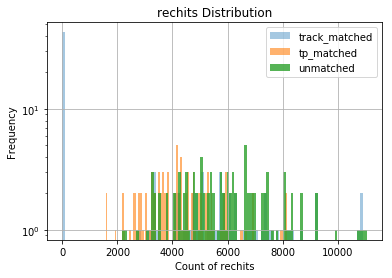

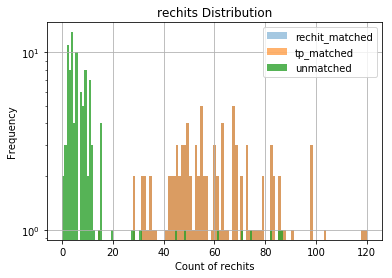

In [303]:
plot_matched_vs_unmatched(rechit_count_, ["track_matched", "tp_matched", "unmatched"], 'rechits')
plot_matched_vs_unmatched(track_count_, ["rechit_matched", "tp_matched", "unmatched"], 'rechits')

## Compare Track and Matched Rechit Eta

In [200]:
%%time

'''
Calculate the difference in track and rechit eta per event
Note: Gets Rechit Eta Values from Rechit Global DF
'''

# lists of delta-eta between tracks and matched rechits indexed by global_track_id
# also contains the mean of these values stored in a separate array using index 'mean_difference'
matched_track_eta_difference_ = {}

for event_id_ in range(number_of_events_):
    #event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    # iterate over the selected tracks and the rechit ids matched to each track
    matched_track_eta_difference_[event_id_] = {}
    for track_id_ in track_ids_['matched'][event_id_]:
        trk_eta_diff_ = []
        track_id_ = int(track_id_)
        # Retrieve eta for the track
        trk_eta_ = track_param_global_df_.iloc[track_id_]['track_eta']
        rechit_ids_for_track_ = track_global_df_.iloc[track_id_]['rechit_ids']
        for rechit_id_ in rechit_ids_for_track_:
            rechit_id_ = int(rechit_id_)
            trk_eta_diff_.append(trk_eta_ - rechit_param_global_df_.iloc[rechit_id_]['rechit_eta'])
        matched_track_eta_difference_[event_id_][track_id_] = trk_eta_diff_
    matched_track_eta_difference_[event_id_]['mean_difference'] = [sum(diff_list_)/len(diff_list_) for diff_list_ in matched_track_eta_difference_[event_id_].values()] 
    


CPU times: user 13.2 s, sys: 186 ms, total: 13.4 s
Wall time: 13.3 s


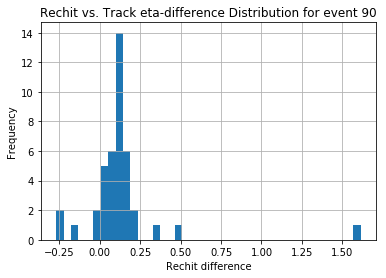

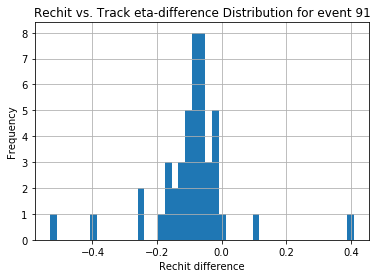

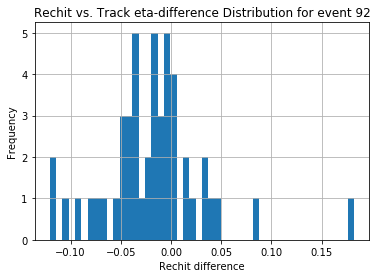

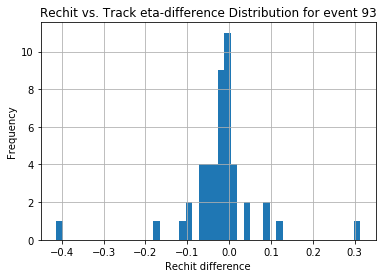

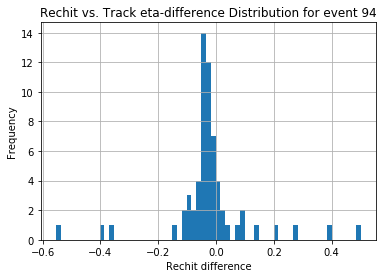

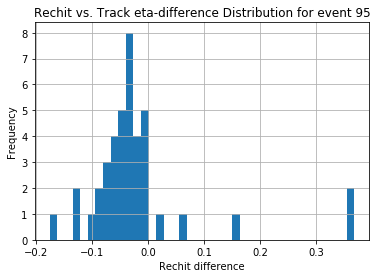

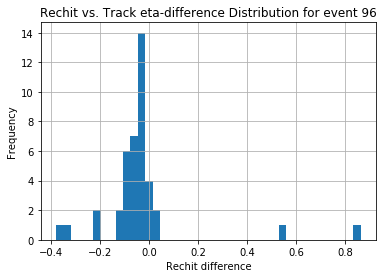

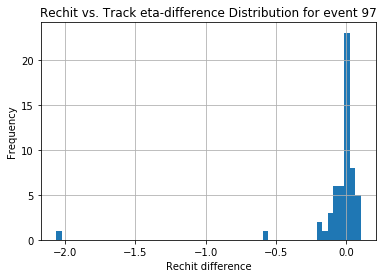

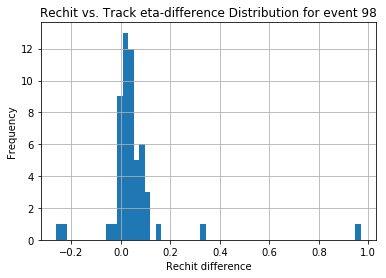

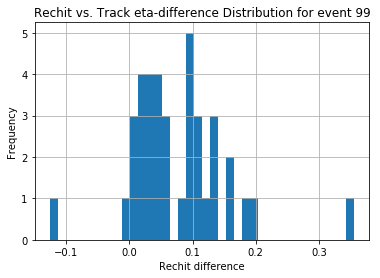

In [201]:
'''
Visualize the Difference in Eta between tracks and rechits belonging to the same track.
Repeat for SPECIFIED NUMBER OF events in the dataset.
'''

# TODO: Try to make this an aminated single graph constantly updating
# Issue: Matplotlib has problems with 'inline' and 'notebook' 
# (interactive plots) used in the same Jupyter Notebook

# plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('alpha', ['0.2', '0.4', '0.6', '0.8'])))
# print rechit_param_global_df_.iloc[:50]['rechit_eta']

for event_id_ in range(len(matched_track_eta_difference_.keys())-10, len(matched_track_eta_difference_.keys())):
    if len(matched_track_eta_difference_[event_id_]['mean_difference']) == 0:
        continue
    ax_ = plt.subplot()
    ax_.hist(matched_track_eta_difference_[event_id_]['mean_difference'], histtype='stepfilled', 
             bins=len(matched_track_eta_difference_[event_id_]['mean_difference']), 
             orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    plt.xlabel('Rechit difference')
    plt.title('Rechit vs. Track eta-difference Distribution for event ' + str(event_id_))
    #plt.savefig('plots/' + gen_event_ + '/track/' + key + 'tracks')
    plt.show()
    #plt.pause(2)
    

## Plot Track Parameters

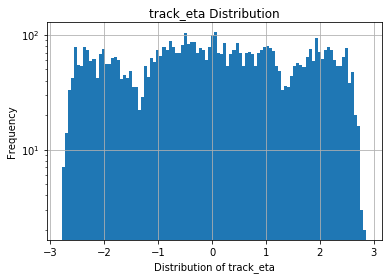

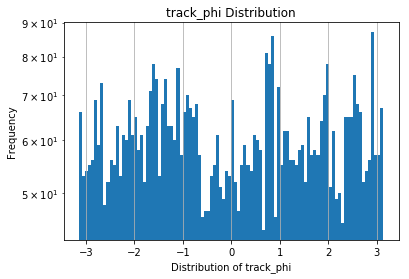

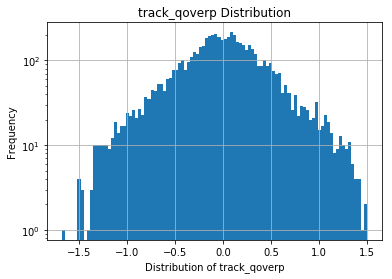

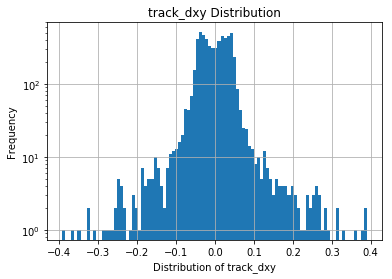

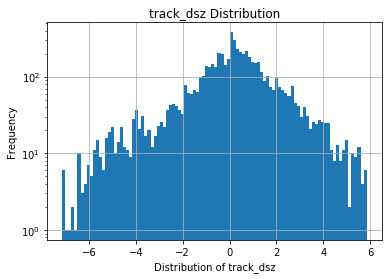

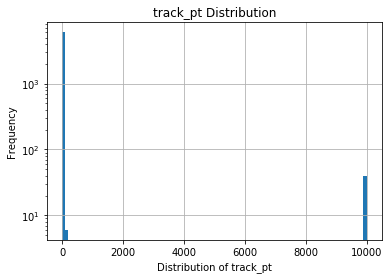

In [202]:
%matplotlib inline
# Iterate over 5 track parameters and plot their distribution
# Note: THIS IS LOG SCALE

for key in track_param_global_df_.columns:
    if key == 'track_id':
        continue
    ax_ = plt.subplot()
    ax_.hist(track_param_global_df_[key], histtype='stepfilled', bins=100, orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    
    # Comment the next line for a linear scale
    plt.yscale('log')
    
    plt.xlabel('Distribution of ' + key)
    plt.title(key + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/track/' + key)
    plt.show()

### Filter High-Pt Events

Iterating over track pt from 6041 tracks


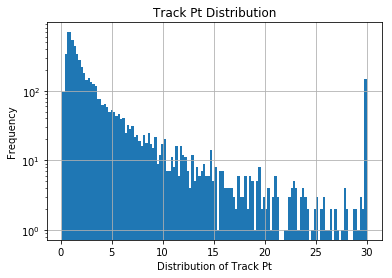

In [203]:
# Additional visualization discarding high-pt events for more clarity

track_pt_ = data_.array('trackPt')
concat_track_pt_ = []
high_pt_events_ = {}

for event_ in range(len(track_pt_)):
    for trk_pt_val_ in track_pt_[event_]:
        
        # What is a reasonable general threshold for Track Pt?
        if trk_pt_val_ < 30:
            concat_track_pt_.append(trk_pt_val_)
        else:
            if event_ in high_pt_events_:
                high_pt_events_[event_] += 1
            else:
                high_pt_events_[event_] = 1
            concat_track_pt_.append(30)
            
print "Iterating over track pt from", len(concat_track_pt_), "tracks"

plt.clf()
ax_ = plt.subplot()
ax_.hist(concat_track_pt_, histtype='stepfilled', bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.yscale('log')
plt.xlabel('Distribution of Track Pt')
plt.title('Track Pt Distribution')
plt.savefig('plots/' + gen_event_ + '/track/track-pt')
plt.show()

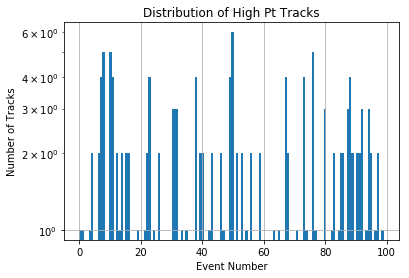

In [204]:
# Events with high pt tracks and their distribution

plt.clf()
ax_ = plt.subplot()
ax_.hist(high_pt_events_.keys(), weights=high_pt_events_.values(), bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Number of Tracks')
plt.yscale('log')
plt.xlabel('Event Number')
plt.title('Distribution of High Pt Tracks')
plt.savefig('plots/' + gen_event_ + '/track/high-pt-events')
plt.show()


# Plot SimHit Distribution in X and Y Axes

In [224]:
%matplotlib inline

def plot_2d_rechit_coordinates(params_, rechit_type_, n_bins_=300, figsize_x_=10, figsize_y_=10, uncut_rechit_ids_=None):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i: str

    :rtype: None 
    '''
    # Add updates to filter uncut Rechit IDs
    if uncut_rechit_ids_ is not None:
        print "Method not defined to filter by uncut ids"
    else:
        x_coordinate_ = data_.array(params_[0])
        y_coordinate_ = data_.array(params_[1])

        if len(x_coordinate_) == len(y_coordinate_):
            concat_x_ = []
            concat_y_ = []

            for i in range(len(mono_x_)):
                concat_x_.extend(x_coordinate_[i])
                concat_y_.extend(y_coordinate_[i])

        plt.figure(figsize=(figsize_x_, figsize_y_))
        ax_ = plt.subplot(1,1,1)
        plt.xlabel(params_[0])
        plt.ylabel(params_[1])
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + ' Distribution')
        ax_.patch.set_facecolor('black')
        ax_.hist2d(concat_x_, concat_y_, bins=n_bins_, norm=matplotlib.colors.LogNorm(), cmap='hot')
        plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/2drechitdistribution')
        plt.show()
    return

In [225]:
%matplotlib inline
'''
Function to plot the rechit parameters as a histogram
'''
def plot_rechit_parameters(params_, rechit_type_, n_bins_=50, figsize_x_=8, figsize_y_=6):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i_: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i_: str

    :rtype: None 
    '''
    # Define a loop that plots R, Phi, and Eta for Rechits
    for property_ in params_:
        param_array_ = data_.array(property_)
        concat_param_array_ = []

        for i in range(len(param_array_)):
                concat_param_array_.extend(param_array_[i])

        plt.clf()
        fig, ax_ = plt.subplots(figsize=(figsize_x_, figsize_y_))
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + 'Rechit Distribution of ' + property_)
        ax_.hist(concat_param_array_, bins=n_bins_, histtype='stepfilled', align='mid', orientation='vertical', density=True)
        plt.xlabel('Value of ' + property_)
        plt.ylabel('Distribution of ' + property_)
        plt.title(property_ + ' Distribution')
        plt.grid(True)
        plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/' + property_)
        plt.show()
    return

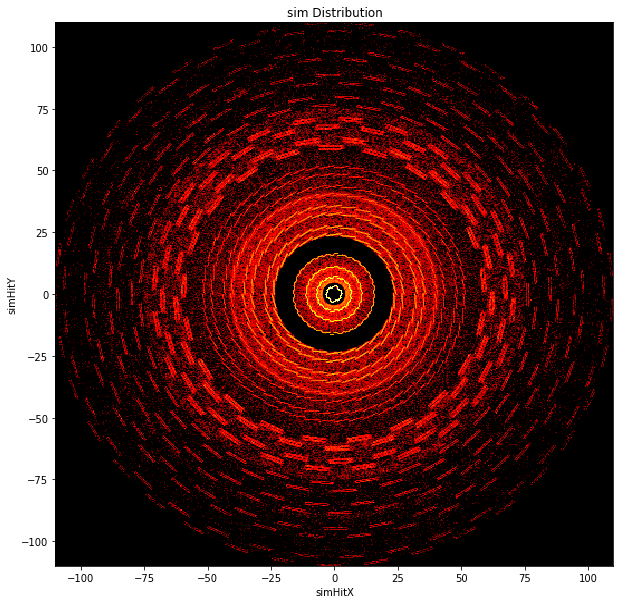

In [226]:
plot_2d_rechit_coordinates(["simHitX", "simHitY"], 'sim', n_bins_=500)

### Count Simhits Matched to Tracks

In [207]:
%%time
'''
Extract the Simhits Matched to Tracks already from the C++ code
'''

# Count the simhit matches to tracks
simhit_tp_match_ = data_.array("simHitMatch")
simhit_count_ = {'track_matched': [], 'total': []}

for event_id_ in range(number_of_events_):
    match_count_ = 0
    for tp_ in simhit_tp_match_[event_id_]:
        # Change this to == 0 in the next set of ttbar outfiles
        if tp_ > 0:
            match_count_ += 1
        else:
            continue
    simhit_count_['total'].append(len(simhit_tp_match_[event_id_]))
    simhit_count_['track_matched'].append(match_count_)

count_total_ = []
count_matched_ = []
print "Event, Total Hit Count, Matched Hit Count"

for i in range(number_of_events_):
    count_total_.append(simhit_count_['total'][i])
    count_matched_.append(simhit_count_['track_matched'][i])
    if simhit_count_['track_matched'][i] == 0:
        print i, "\t", simhit_count_['total'][i], "\t", simhit_count_['track_matched'][i]

print float(sum(count_matched_))/float(sum(count_total_))

Event, Total Hit Count, Matched Hit Count
7 472505 0
8 714058 0
10 446368 0
29 464284 0
77 205020 0
88 529569 0
0.00279273372853
CPU times: user 1min 4s, sys: 927 ms, total: 1min 4s
Wall time: 1min 4s


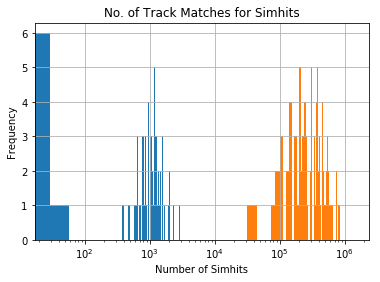

In [208]:
plt.clf()
ax_ = plt.subplot()
ax_.hist(simhit_count_['track_matched'], bins=len(simhit_count_['track_matched']), orientation='vertical', label='track_matched simhits')
ax_.hist(simhit_count_['total'], bins=len(simhit_count_['total']), orientation='vertical', label='track_matched simhits')
plt.grid(True)
plt.ylabel('Frequency')
plt.xlabel('Number of Simhits')
plt.xscale('log')
plt.title('No. of Track Matches for Simhits')
#plt.savefig('plots/' + gen_event_ + '/simhit/track-matches')
plt.show()

### Plot the Hole in the Data (2D Plot; 3D Axes)

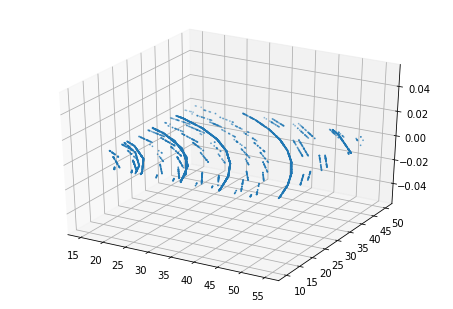

In [210]:
%matplotlib inline

# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?
fig_ = plt.figure()
ax_ = Axes3D(fig_)
concat_mono_x_ = []
concat_mono_y_ = []
concat_mono_z_ = []

for event_ in range(10):
    for x, y, z, in zip(mono_x_[event_], mono_y_[event_], mono_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_mono_x_.append(x)
            concat_mono_y_.append(y)
            concat_mono_z_.append(z)   

ax_.scatter3D(concat_mono_x_, concat_mono_y_, s=0.6)
#ax_.scatter3D(concat_mono_x_, concat_mono_y_, concat_mono_z_, s=0.6)

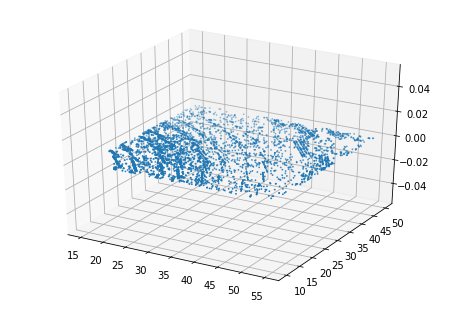

In [211]:
% matplotlib inline

# These are the SIMHITS lying along the same cross-section
# Clearly there is no hole in the Simhits

fig_ = plt.figure()
ax_ = Axes3D(fig_)

concat_simhit_x_ = []
concat_simhit_y_ = []
concat_simhit_z_ = []

for event_ in range(8):
    for x, y, z, in zip(simhit_x_[event_], simhit_y_[event_], simhit_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_simhit_x_.append(x)
            concat_simhit_y_.append(y)
            concat_simhit_z_.append(z)   

ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, s=0.6)  # Better visualization
# ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)

### Visualize the Mono Rechits

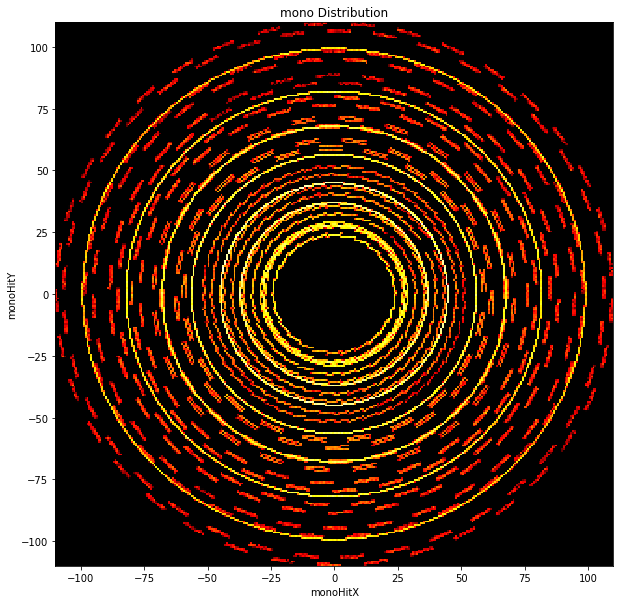

In [209]:
plot_2d_rechit_coordinates(["monoHitX", "monoHitY"], 'mono')

## Plot Rechit Parameters

<Figure size 432x288 with 0 Axes>

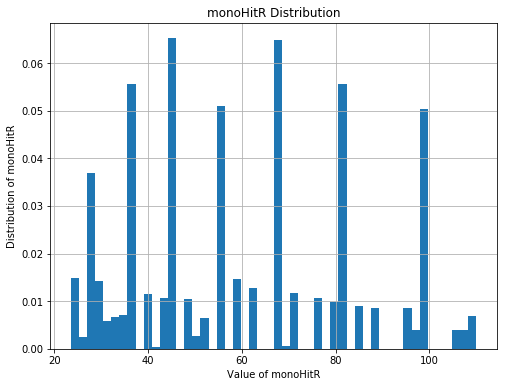

<Figure size 432x288 with 0 Axes>

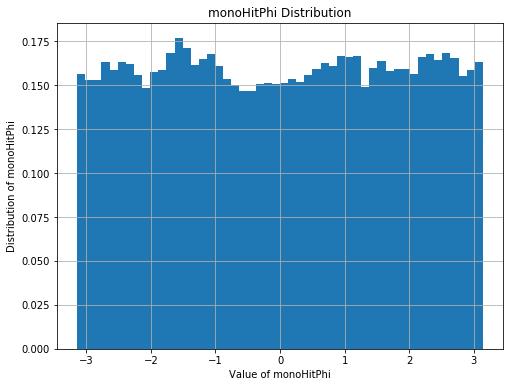

<Figure size 432x288 with 0 Axes>

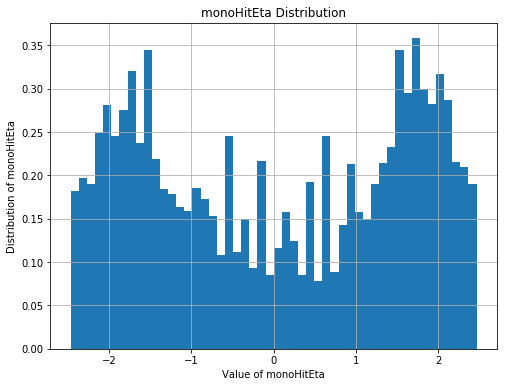

In [213]:
# Call the plot function to plot histograms of rechit parameters
plot_rechit_parameters(["monoHitR", "monoHitPhi", "monoHitEta"], 'mono')

## Visualize the Stereo Rechits

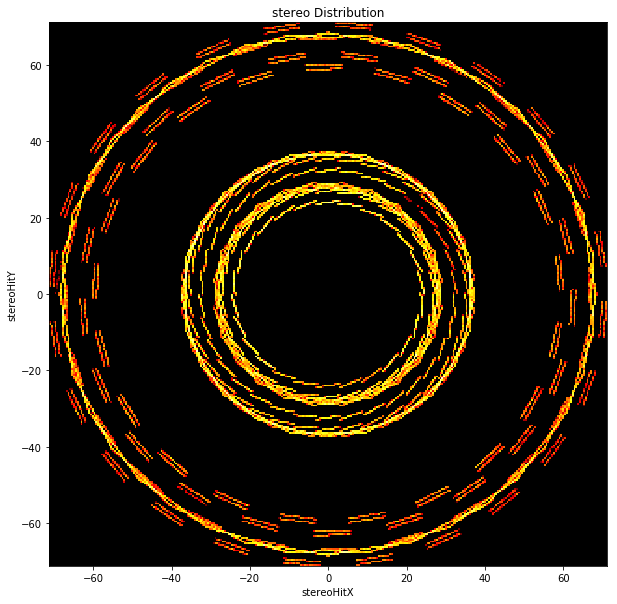

In [214]:
plot_2d_rechit_coordinates(["stereoHitX", "stereoHitY"], 'stereo')

<Figure size 432x288 with 0 Axes>

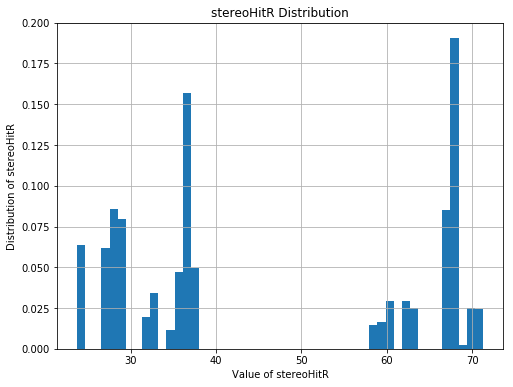

<Figure size 432x288 with 0 Axes>

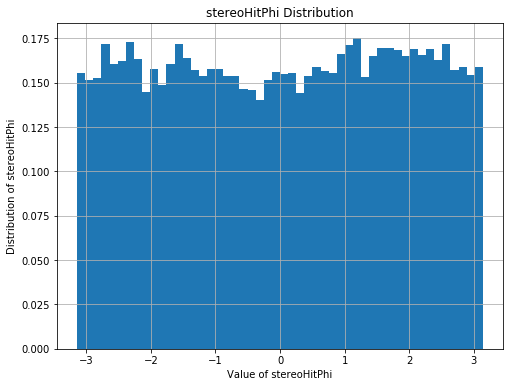

<Figure size 432x288 with 0 Axes>

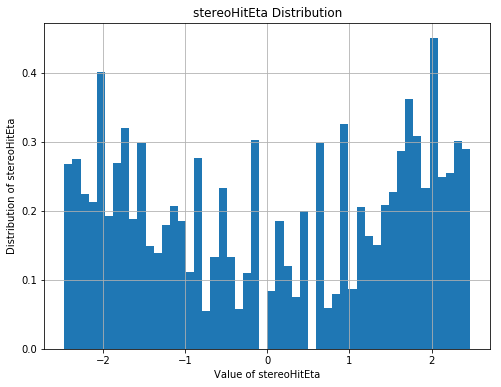

In [215]:
# Plot R, Phi, and Eta for Stereo Hits
plot_rechit_parameters(["stereoHitR", "stereoHitPhi", "stereoHitEta"], 'stereo')


### Testing Integrity of internal data storage 

In [216]:
%%time
# Correlate the above data to confirm the dataframe is correct
# TODO: Delete above code block as it takes too much time
hit_tp_count_ = {}

for id_, tp_idx_list_ in rechit_global_df_["rechit_tp_index"].items():
    tp_len_ = len(tp_idx_list_)
    if tp_len_ in hit_tp_count_:
        hit_tp_count_[tp_len_] += 1
    else:
        hit_tp_count_[tp_len_] = 1
print hit_tp_count_

{0: 166358, 1: 429164, 2: 4501, 3: 253, 4: 42, 5: 13, 6: 6, 7: 4, 8: 2, 9: 4}
CPU times: user 230 ms, sys: 13.2 ms, total: 243 ms
Wall time: 223 ms


In [217]:
# Check that the same number of entries are recorded for stereo rechits
concat_stereo_tp_idx_ = []
for i in range(len(stereo_tp_idx_)):
    concat_stereo_tp_idx_.extend(stereo_tp_idx_[i])
    
print len(concat_stereo_tp_idx_) == len(concat_stereo_param_)

True


## Store Data as Serialized DataFrames

In [218]:
import msgpack

In [167]:
%%time
# --------------------------------------------- Writing to serialized format fails in case of copied dataframes 
# as the columns are not updated from sets to lists -----------------------------------------------------------
# Iterate over all Global DataFrames, find the columns to replace, 
# and replace with lists instead of sets so that they are serializable

i = 0
# List of strings with dataframe names to set as filenames for storage
name_list_ = ['track_global_df_', 'track_param_global_df_', 'rechit_global_df_', 'rechit_param_global_df_']

for dataframe_ in [track_global_df_, track_param_global_df_, rechit_global_df_, rechit_param_global_df_]:
    dataframe_to_update_ = dataframe_.copy(deep=True)
    columns_to_replace_ = ['rechit_ids', 'rechit_tp_index', 'track_tp_index', 'track_matches']
    for column_name_ in columns_to_replace_:    
        if column_name_ in dataframe_to_update_:
            list_arr_ = []
            for set_ in dataframe_to_update_[column_name_]:
                list_arr_.append(list(set_))
            dataframe_to_update_.update(pd.Series(list_arr_, name=column_name_))
    filename_ = 'data/' + name_list_[i] + '.msgpack'
    dataframe_to_update_.to_msgpack(filename_)
    i += 1


CPU times: user 3.08 ms, sys: 10.5 ms, total: 13.6 ms
Wall time: 11.6 ms


## Convert to Adjacency Matrix for each Track

In [ ]:
import tensorflow as tf

In [ ]:

for event_id_ in range(number_of_events_):
    
    # Obtain subset of global dataframe for the respective event
    event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    
    